In [128]:
%matplotlib inline

from Memory import ReplayMemory
from SACV2 import SoftActorCritic
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import sys
sys.path.append("..")
from behavioral_sim.custom_envs import BehavSimEnv
from behavioral_sim.custom_envs import HourlySimEnv
import IPython
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
"""
My rough code to train and experiment with SACV2, I pretty much just call the train function below


"""

replay_size = 10000


total_numsteps = 60
start_steps = 30
batch_size = 1
action_star = None

## Helper functions

In [3]:

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def series_to_supervised(data,
                         n_in,
                         target_features,
                         col_names=None,
                         n_out=1,
                         dropnan=True,
                         initial_excluded_timesteps=0,
                         removed_features=[],
                         only_current_timestep_features=[]):
    """Takes time series data and converts it into a supervised learning
    problem framework.

        Parameters:
            - data (pd.Dataframe) -- the time series data to be converted.
            - n_in (int) -- Number of time steps to use as lag for the feature 
                matrix
            - col_names (List[str]) -- list of strings to use as column names,
                that get converted into features for each time lag
            - target_features (List[str]) -- List of features that will be used
                as dependent variables in the target matrix.
            - n_out (int) -- Number of time steps to use as lag for the target
                matrix
            - dropnan (bool) -- Whether to drop nan values
            - initial_excluded_timesteps (int) -- The number of input timesteps to 
                ignore before starting the time lag.
            - removed_features (List[str]) -- List of features that should be removed
                from the dataframe. 
            - only_current_timestep_features (List[str]) -- Features that should
            only be included in the current timestep, not any before (e.g.) to avoid
            unintended dependencies
            
            - [Planned] exclude_current_day (bool) -- Whether to include values 
                from the current day. If this parameter is false, then the time lag 
                will always start with the day preceding the current time 
                step.
                
        Outputs:
            - (X, y): (Feature matrix, target matrix)
    """
    
    if col_names is None:
        col_names = data.columns
        
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data).drop(removed_features, axis=1)
    col_names = [x for x in col_names if x not in removed_features]
    cols, names = list(), list()      
        
    only_prev_time_features = df.drop(only_current_timestep_features, axis=1)
    only_prev_column_names = [x for x in col_names if x in only_prev_time_features.columns]

    # (t-n, ... t-1) --> i.e. steps into the past
    for i in range(n_in + initial_excluded_timesteps, initial_excluded_timesteps, -1):
        cols.append(only_prev_time_features.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in only_prev_column_names]

    # (t, t+1, ... t+n) --> i.e. steps into the future
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col)) for col in col_names]
        else:
            names += [('%s(t + %d)' % (col, i)) for col in col_names]

    # concat
    agg = pd.concat(cols, axis=1)
#     agg.columns = names

    # dropnan
    if dropnan:
        agg.dropna(inplace=True)
    
    if target_features: 
        Y_vals_cols = ([('%s(t)' % (col)) for col in target_features] + 
            ['%s(t + %d)' % (col, i) for col in target_features for i in range(1, n_out)])

        Y_vals = agg[Y_vals_cols]
        X_vals = agg.drop(Y_vals_cols, axis=1)

        agg.columns = names
              
        return X_vals, Y_vals # X_vals.values, Y_vals.values
    
    else:
        return agg, _



In [15]:
def planning_prediction(action, day_of_week, loaded_model):

    ## load the minMaxScalers
    with open ("scaler_X.pickle", "rb") as input_file:
        scaler_X = pickle.load(input_file) 
    with open ("scaler_y.pickle", "rb") as input_file:
        scaler_y = pickle.load(input_file) 

    ## prepare the data

    d_X = pd.DataFrame(data = { "action"  : action, "dow" : day_of_week } )
    scaled_X = scaler_X.transform(d_X)
    sxr = scaled_X.reshape((scaled_X.shape[0], 1, scaled_X.shape[1])) 

    preds = loaded_model.predict(sxr)

    inv_preds = scaler_y.inverse_transform(preds)  

    return np.squeeze(inv_preds)

## Train the planning model with more data 

In [47]:
def train_planning_model(
    energy_today, 
    action, 
    day_of_week, 
    loaded_model, 
    filename_to_save = "GPyOpt_planning_model"
):
    
    ## load the minMaxScalers
    with open ("scaler_X.pickle", "rb") as input_file:
        scaler_X = pickle.load(input_file) 
    with open ("scaler_y.pickle", "rb") as input_file:
        scaler_y = pickle.load(input_file) 

    ## prepare the data

    d_X = pd.DataFrame(data = { "action" : action, "dow" : day_of_week } )
    scaled_X = scaler_X.transform(d_X)
    sxr = scaled_X.reshape((scaled_X.shape[0], 1, scaled_X.shape[1])) 
    
    d_y = pd.DataFrame(data = {"energy" : energy_today})
    scaled_y = scaler_y.transform(d_y)
    
    loaded_model.fit(
            sxr,    ## these all need to be changed if the GPyOpt evaluates differently
            scaled_y,
            epochs=100,
            batch_size=10,
            validation_split=0.0,
            verbose=0,
        )
    
    model_json = loaded_model.to_json()
    with open(filename_to_save + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    loaded_model.save_weights(filename_to_save + ".h5")
    print("Saved model to disk")
    
    return

## load model

In [37]:
def load_model_from_disk(file_name = "GPyOpt_planning_model"):
    json_file = open(file_name + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(file_name + ".h5")
    print("Loaded model from disk")

    loaded_model.compile(loss="mse", optimizer="adam")
    return loaded_model

## Train function


In [93]:
def train(response_type_str, 
    extra_train, 
    planning_iterations,
    one_day = False, 
    energy=True, 
    day_of_week=True, 
    planning_model = False,
    train_planning_model_with_new_data = False,
    ):
    """
    Args: 
        Response_type_str = 'theshold_exp' or 'sin' or 'mixed' or 'linear'
        Extra_Train = Number of iterations to "overtrain"
        planning_iterations = number of times to query the planning model
        One_day: Whether to train from a single day's price signal 
        Energy: Whether or not to include previous day energy in the state
        Day_of_Week: Whether or not to include day_of_week multiplier
        planning_model: whether or not to use the planning model
        train_planning_model_with_new_data= whether to train the planning model
    
    Summary:
        This code 'simulates' a run of SACV2 training and acting over 30 days (takes a step each day)

    """
    if(response_type_str == 'threshold_exp'):
        #env = HourlySimEnv(response='t', one_day=True, energy_in_state=False)
        env2 = BehavSimEnv(response='t', one_day = one_day, energy_in_state=energy, yesterday_in_state=False,
                            day_of_week = day_of_week)
    elif(response_type_str == 'sin'):
        #env = HourlySimEnv(response='s',one_day=True, energy_in_state=False)
        env2 = BehavSimEnv(response='s', one_day=one_day, energy_in_state=energy, yesterday_in_state=False,
                            day_of_week = day_of_week)
    elif(response_type_str == 'mixed'):
        #env = HourlySimEnv(response='s',one_day=True, energy_in_state=False)
        env2 = BehavSimEnv(response='m', one_day=one_day, energy_in_state=energy, yesterday_in_state=False,
                            day_of_week = day_of_week)
    elif(response_type_str == 'linear'):
        #env = HourlySimEnv(response='l',one_day=True, energy_in_state=False)
        env2 = BehavSimEnv(response='l', one_day=one_day, energy_in_state=energy,yesterday_in_state=False,
                            day_of_week = day_of_week)
    
    else:
        raise NotImplementedError

    #rewards in environment that agents see
    rewards = []

    #optional rewards list for environment that agent doesn't see (used in one-day training -> generalization case)
    rewards2 = []

    min_combined_losses = []
    min_policy_losses = []
    min_alpha_losses = []
    num_iters_list = []
    overall_best_action = None

    memory = ReplayMemory(replay_size)

    #Sometimes use 2 environment, this is used to default to 1 env. 
    #Change if you want to use 2 environments
    env = env2

    action_star = []
    state = None


    agent = SoftActorCritic(env.observation_space, env.action_space, memory)

    reward_planning = []
    
    # Actions 2 save and energy_usage for data_generation
    # actions_2_save = []
    # energy_usage = []

    # Flag corresp to whether first state has been initialized
    start_flag = False

    while (env.day <= 60):
        step = env.day
        day_of_week = env.day % 7 
        print("Day: " + str(step))
        if (not start_flag):
            action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            state = np.copy(next_state)
            start_flag = True
            continue

        if env.day <= 30:
            action = env.action_space.sample()  # Sample random action
            next_state, reward, done, info = env.step(action)

            memory.push((state, action, reward, next_state, done))

            state = np.copy(next_state)
            continue
            
        else:
            if(memory.get_len() > batch_size):
                critic_1_losses = [None]
                critic_2_losses = [None]
                policy_losses = [None]
                alpha_losses = [None]
                actions = []
                for extra_step in range(extra_train):
                    print("--"*10)
                    print(" Extra Train " + str(extra_step))
                    q1_prev_loss = critic_1_losses[-1]
                    q2_prev_loss = critic_2_losses[-1]
                    policy_loss = policy_losses[-1]
                    alpha_loss = alpha_losses[-1]
                    return_update = agent.update_params(batch_size, memory_type = "replay")
                    print(return_update)
                    print("--"*10)
                    critic_1_loss = return_update[0]
                    critic_2_loss = return_update[1]
                    policy_loss = return_update[2]
                    alpha_loss = return_update[3]

                    critic_1_losses.append(critic_1_loss)
                    critic_2_losses.append(critic_2_loss)
                    policy_losses.append(policy_loss)
                    alpha_losses.append(alpha_loss)

                energy_yesterday = np.copy(next_state[:10])

                if planning_model:
                    
                    ## load model from disk now   
                    if train_planning_model_with_new_data:
                        if (env.day==31):
                            loaded_model = load_model_from_disk("GPyOpt_planning_model")
                        else:
                            loaded_model = load_model_from_disk("GPyOpt_planning_model_training")
                    else: 
                        loaded_model = load_model_from_disk("GPyOpt_planning_model")
            
                    for planning_step in range(planning_iterations):
                        print("--"*10)
                        print(" planning step " + str(planning_step))
                        q1_prev_loss = critic_1_losses[-1]
                        q2_prev_loss = critic_2_losses[-1]
                        policy_loss = policy_losses[-1]
                        alpha_loss = alpha_losses[-1]

                        grid_prices_today = env.prices[env.day] # assuming that the env.day here correctly is set to the correct day
                        grid_prices_tmr = env.prices[(env.day + 1) % 365]
                        # state is defined as [previous day energy, current day prices] 
                        # I don't currently want this to change, as it should be the same to allow agent to explore

                        state = np.concatenate((energy_yesterday, grid_prices_today))
                        action = agent.get_action(state)
                     
                        planned_energy_consumption = planning_prediction(action, day_of_week, loaded_model)
                        
                        # will define next state as [energy, grid prices tomorrow]

                        next_state = np.concatenate((planned_energy_consumption, grid_prices_tmr))
                        reward = env.get_reward_planning_model(grid_prices_today, planned_energy_consumption) 
                        done = True

                        agent.planning_replay_memory.push((state, action, reward, next_state, done))
                        
                        return_update = agent.update_params(batch_size, memory_type = "planning")

#                         IPython.embed()
                        
                        print(return_update)
                        print("--"*10)
                        critic_1_loss = return_update[0]
                        critic_2_loss = return_update[1]
                        policy_loss = return_update[2]
                        alpha_loss = return_update[3]

                        critic_1_losses.append(critic_1_loss)
                        critic_2_losses.append(critic_2_loss)
                        policy_losses.append(policy_loss)
                        alpha_losses.append(alpha_loss)
                        reward_planning.append(reward)
                        # num_iters_list.append(num_iters)
                        # actions.append(agent.get_action(state))
            
            #Finds the action corresp to the lowest combined q-loss
            # combined_q_loss = np.array(critic_1_losses[1:]) + np.array(critic_2_losses[1:])
            # min_loss = np.amin(combined_q_loss)
            # min_combined_losses.append(min_loss)
            # index_of_min = np.where(combined_q_loss == min_loss)[0][0]
            
            action = agent.get_action(state)

            # min_policy_losses.append(np.amin(np.array(policy_losses)))
            # min_alpha_losses.append(np.amin(np.array(alpha_losses)))

            next_state, reward, done, info = env.step(action)

            memory.push((state, action, reward, next_state, done))
            
            # train the planning model 
            energy_today = np.copy(next_state[:10])
                        
            # if training the planning model is the flag that we'll change, then 
            # change over to "planning_model_training" and train it 
            
            if train_planning_model_with_new_data:
                if env.day == 31:
                    loaded_model = load_model_from_disk("GPyOpt_planning_model_training")
                    
                train_planning_model(    
                    energy_today = energy_today, 
                    action = action, 
                    day_of_week = day_of_week, 
                    loaded_model = loaded_model
                )
            
            state = np.copy(next_state)

            if(done):
                rewards.append(reward)
            print("--------" * 10)
    
    return rewards, critic_1_losses, critic_2_losses, policy_losses, alpha_losses, reward_planning



In [67]:
def train_curve_finder(max_iter, response_type_str):
    def train_store_rewards(response_type_str):
        sampled_days = [19,16,29,18,14,23,9,21,10,30]
        #Key = Day | Val = list for SAC Reward
        rewards_dict = {i: [] for i in range(1,max_iter,10)}
        for iteration in range(1,max_iter,10):
            #Add error bounds, just for loop then return avg, pointwise-max/min
            for i in range(5):
                curr_rewards_sac = train(response_type_str,iteration, energy=True, day_of_week=True)
                rewards_dict[iteration].append(curr_rewards_sac)   
        return rewards_dict
        
    sac_rewards_dict = train_store_rewards(response_type_str)
    for et in sac_rewards_dict.keys():
        sac_rewards_iter_et = sac_rewards_dict[et]
        print(sac_rewards_iter_et)
        print("----\n"*2)
        np.save("SACV2_" + response_type_str + "_" + str(et) + "_rewards_no_seed",sac_rewards_iter_et)

In [7]:
rewards_both, critic_1_losses_both, critic_2_losses_both, policy_losses_both, alpha_losses_both = train(response_type_str = "mixed", 
         extra_train = 40, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 10
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
--------------------
 Extra Train 40
(34683364.0, 34534568.0, 215.89706420898438, -0.0)
--------------------
--------------------
 Extra Train 40
(16438818.0, 16350577.0, 202.16371154785156, -0.062017772346735)
--------------------
--------------------
 Extra Train 40
(19999352.0, 19908194.0, 187.90110778808594, -0.11395933479070663)
--------------------
--------------------
 Extra Train 40
(10616145.0, 10595111.0, 179.09400939941406, -0.1628684103488922)
--------------------
--------------------
 Extra Train 40
(30836828.0, 30749992.0, 191.8766632080078, -0.23605185747146606)
--------------------
--------------------
 Extra Train 40
(5906036.5, 5915489.5, 181.79933166503906, -0.27248498797416687)
-----------------

(31921916.0, 32360672.0, 221.776611328125, -4.080333232879639)
--------------------
--------------------
 Extra Train 40
(50349988.0, 51171292.0, 240.4234619140625, -4.115583419799805)
--------------------
--------------------
 Extra Train 40
(38370596.0, 38827648.0, 216.82965087890625, -4.116969585418701)
--------------------
--------------------
 Extra Train 40
(6710689.0, 6952551.0, 222.91954040527344, -4.072764873504639)
--------------------
--------------------
 Extra Train 40
(25257418.0, 25629896.0, 209.05181884765625, -3.990147113800049)
--------------------
--------------------
 Extra Train 40
(8434790.0, 8709528.0, 191.953125, -3.3747222423553467)
--------------------
--------------------
 planning step 0
Loaded model from disk
(18910798.0, 19422892.0, 252.78372192382812, -4.648316383361816)
--------------------
--------------------
 planning step 1
Loaded model from disk
(18540430.0, 19053494.0, 241.36219787597656, -4.381800651550293)
--------------------
-------------------

(17933464.0, 19059568.0, 278.6094970703125, -5.518123149871826)
--------------------
--------------------
 planning step 8
Loaded model from disk
(18336578.0, 19494532.0, 301.8077392578125, -6.408750057220459)
--------------------
--------------------
 planning step 9
Loaded model from disk
(18922258.0, 20116290.0, 276.31878662109375, -5.331784725189209)
--------------------
--------------------------------------------------------------------------------
Day: 34
--------------------
 Extra Train 40
(15123149.0, 15903829.0, 289.9373779296875, -7.417239665985107)
--------------------
--------------------
 Extra Train 40
(32871448.0, 34499764.0, 306.33673095703125, -6.443312644958496)
--------------------
--------------------
 Extra Train 40
(21950140.0, 23017046.0, 283.1272277832031, -6.701587677001953)
--------------------
--------------------
 Extra Train 40
(27222750.0, 28632082.0, 326.644775390625, -7.669950485229492)
--------------------
--------------------
 Extra Train 40
(3140039

(26261422.0, 31606006.0, 685.211181640625, -11.24804401397705)
--------------------
--------------------
 Extra Train 40
(36035008.0, 40128592.0, 514.1924438476562, -10.939825057983398)
--------------------
--------------------
 Extra Train 40
(7783955.5, 10489079.0, 621.699951171875, -10.268317222595215)
--------------------
--------------------
 Extra Train 40
(3876314.0, 6226300.5, 713.7515869140625, -11.35509204864502)
--------------------
--------------------
 planning step 0
Loaded model from disk
(41230476.0, 45989324.0, 510.5998229980469, -9.045613288879395)
--------------------
--------------------
 planning step 1
Loaded model from disk
(19739560.0, 24466650.0, 694.12060546875, -11.542738914489746)
--------------------
--------------------
 planning step 2
Loaded model from disk
(15916679.0, 19904948.0, 646.9581909179688, -10.503984451293945)
--------------------
--------------------
 planning step 3
Loaded model from disk
(36277248.0, 40915776.0, 544.56689453125, -10.4389114

Loaded model from disk
(37656960.0, 47605040.0, 929.732421875, -12.889081001281738)
--------------------
--------------------------------------------------------------------------------
Day: 37
--------------------
 Extra Train 40
(25490730.0, 36445728.0, 1188.115966796875, -15.506593704223633)
--------------------
--------------------
 Extra Train 40
(6420261.5, 11345200.0, 1022.0653076171875, -14.436394691467285)
--------------------
--------------------
 Extra Train 40
(11348121.0, 18670500.0, 1098.4764404296875, -11.232694625854492)
--------------------
--------------------
 Extra Train 40
(81110816.0, 102774432.0, 1316.5887451171875, -14.426143646240234)
--------------------
--------------------
 Extra Train 40
(11501009.0, 18123492.0, 1058.795654296875, -14.904729843139648)
--------------------
--------------------
 Extra Train 40
(3376063.5, 7637771.5, 1118.864013671875, -14.9787015914917)
--------------------
--------------------
 Extra Train 40
(6213022.5, 11419182.0, 1076.996

(7813927.5, 19849610.0, 1846.281005859375, -18.091651916503906)
--------------------
--------------------
 Extra Train 40
(6219125.0, 18628160.0, 2028.1307373046875, -19.721837997436523)
--------------------
--------------------
 Extra Train 40
(6730817.0, 19511930.0, 2004.22802734375, -17.718618392944336)
--------------------
--------------------
 Extra Train 40
(21512040.0, 47631492.0, 2460.75439453125, -19.06365203857422)
--------------------
--------------------
 Extra Train 40
(19988942.0, 36849644.0, 1773.50341796875, -17.002771377563477)
--------------------
--------------------
 Extra Train 40
(15496140.0, 29533446.0, 1665.893798828125, -16.475597381591797)
--------------------
--------------------
 Extra Train 40
(3185808.5, 16202685.0, 2415.250732421875, -16.550264358520508)
--------------------
--------------------
 Extra Train 40
(7232575.0, 19839016.0, 1957.69384765625, -18.665494918823242)
--------------------
--------------------
 Extra Train 40
(30787504.0, 52068896.0, 

Loaded model from disk
(678691.1875, 12874892.0, 2957.7353515625, -21.264892578125)
--------------------
--------------------
 planning step 1
Loaded model from disk
(4693794.0, 32775434.0, 3738.129150390625, -19.13932228088379)
--------------------
--------------------
 planning step 2
Loaded model from disk
(609922.5, 12850063.0, 2984.33935546875, -19.641490936279297)
--------------------
--------------------
 planning step 3
Loaded model from disk
(708315.375, 12811181.0, 2913.11865234375, -21.627870559692383)
--------------------
--------------------
 planning step 4
Loaded model from disk
(2444982.0, 25237264.0, 3653.9072265625, -21.520095825195312)
--------------------
--------------------
 planning step 5
Loaded model from disk
(2127059.25, 23619656.0, 3607.307373046875, -22.198068618774414)
--------------------
--------------------
 planning step 6
Loaded model from disk
(2347630.75, 25352946.0, 3687.934814453125, -20.08513641357422)
--------------------
--------------------
 p

(16761740.0, 66018284.0, 4187.9287109375, -25.637985229492188)
--------------------
--------------------
 Extra Train 40
(14586547.0, 58915976.0, 4021.3408203125, -27.023128509521484)
--------------------
--------------------
 Extra Train 40
(3114799.25, 30015428.0, 3897.3447265625, -24.405466079711914)
--------------------
--------------------
 Extra Train 40
(9830815.0, 51519064.0, 4205.94140625, -26.873294830322266)
--------------------
--------------------
 Extra Train 40
(6085684.5, 58986256.0, 5376.82861328125, -28.374197006225586)
--------------------
--------------------
 Extra Train 40
(561679.25, 30612316.0, 4935.3466796875, -26.42403221130371)
--------------------
--------------------
 Extra Train 40
(3107983.0, 35107076.0, 4327.8466796875, -27.51880645751953)
--------------------
--------------------
 Extra Train 40
(6665942.5, 43606832.0, 4197.89013671875, -28.83344841003418)
--------------------
--------------------
 Extra Train 40
(30094514.0, 130073176.0, 6097.752441406

Loaded model from disk
(18876568.0, 106218928.0, 6159.99365234375, -30.04954719543457)
--------------------
--------------------
 planning step 6
Loaded model from disk
(206087.625, 36410292.0, 6718.65576171875, -29.90093231201172)
--------------------
--------------------
 planning step 7
Loaded model from disk
(18769786.0, 106453384.0, 6183.94384765625, -31.821022033691406)
--------------------
--------------------
 planning step 8
Loaded model from disk
(25468.294921875, 23521160.0, 5177.1640625, -26.97305679321289)
--------------------
--------------------
 planning step 9
Loaded model from disk
(11307592.0, 70222744.0, 5180.2763671875, -30.902427673339844)
--------------------
--------------------------------------------------------------------------------
Day: 43
--------------------
 Extra Train 40
(420775.84375, 46515656.0, 6324.919921875, -30.710460662841797)
--------------------
--------------------
 Extra Train 40
(13188048.0, 71304368.0, 4970.166015625, -30.722047805786133)

(22538746.0, 170794240.0, 8478.16015625, -34.271358489990234)
--------------------
--------------------
 Extra Train 40
(1028915.0625, 72198128.0, 7653.1240234375, -36.62380599975586)
--------------------
--------------------
 Extra Train 40
(141950.859375, 50024796.0, 7658.07666015625, -35.974937438964844)
--------------------
--------------------
 Extra Train 40
(48403.65234375, 33258098.0, 6131.01025390625, -36.279441833496094)
--------------------
--------------------
 planning step 0
Loaded model from disk
(2848656.75, 55387368.0, 5973.76513671875, -34.64970016479492)
--------------------
--------------------
 planning step 1
Loaded model from disk
(73655.5234375, 32828044.0, 6157.896484375, -35.33069610595703)
--------------------
--------------------
 planning step 2
Loaded model from disk
(12340884.0, 90500776.0, 6120.958984375, -31.88886070251465)
--------------------
--------------------
 planning step 3
Loaded model from disk
(63421.33984375, 66640036.0, 8120.7978515625, -35

(14730450.0, 142185312.0, 8278.1845703125, -41.330509185791016)
--------------------
--------------------------------------------------------------------------------
Day: 46
--------------------
 Extra Train 40
(51789.359375, 53992636.0, 7733.93408203125, -38.762142181396484)
--------------------
--------------------
 Extra Train 40
(142815.71875, 68316472.0, 8034.82666015625, -38.124267578125)
--------------------
--------------------
 Extra Train 40
(778284.9375, 80459568.0, 8228.216796875, -39.711936950683594)
--------------------
--------------------
 Extra Train 40
(199867.0625, 47640192.0, 7573.96337890625, -41.859004974365234)
--------------------
--------------------
 Extra Train 40
(59809.859375, 54921540.0, 7801.30029296875, -41.04591369628906)
--------------------
--------------------
 Extra Train 40
(140188.078125, 59735840.0, 7499.86767578125, -40.919010162353516)
--------------------
--------------------
 Extra Train 40
(3319025.75, 65274164.0, 6466.056640625, -39.1145324

(498837.34375, 95502368.0, 9193.71484375, -42.976741790771484)
--------------------
--------------------
 Extra Train 40
(1451053.125, 147326752.0, 11038.8193359375, -46.613162994384766)
--------------------
--------------------
 Extra Train 40
(2660071.75, 39208028.0, 8019.84375, -43.4716911315918)
--------------------
--------------------
 Extra Train 40
(10858.9013671875, 86062440.0, 9275.8681640625, -43.9454345703125)
--------------------
--------------------
 Extra Train 40
(228689.4375, 92274560.0, 9261.728515625, -46.290748596191406)
--------------------
--------------------
 Extra Train 40
(812446.9375, 105289728.0, 9516.234375, -46.61638259887695)
--------------------
--------------------
 Extra Train 40
(1318768.5, 87117304.0, 8335.068359375, -44.07681655883789)
--------------------
--------------------
 planning step 0
Loaded model from disk
(3468000.5, 90462296.0, 7858.2353515625, -42.65449905395508)
--------------------
--------------------
 planning step 1
Loaded model fr

Loaded model from disk
(2721897.5, 92350488.0, 8204.708984375, -47.72719955444336)
--------------------
--------------------
 planning step 8
Loaded model from disk
(13131989.0, 200896240.0, 10728.1220703125, -46.96367645263672)
--------------------
--------------------
 planning step 9
Loaded model from disk
(3684390.25, 60416096.0, 9924.3994140625, -48.7076301574707)
--------------------
--------------------------------------------------------------------------------
Day: 49
--------------------
 Extra Train 40
(745166.8125, 74806312.0, 9638.181640625, -49.80647277832031)
--------------------
--------------------
 Extra Train 40
(58540.84375, 94410792.0, 10088.0947265625, -49.992767333984375)
--------------------
--------------------
 Extra Train 40
(18652884.0, 226504000.0, 10865.0283203125, -47.04072570800781)
--------------------
--------------------
 Extra Train 40
(888494.0, 75604960.0, 9833.9560546875, -50.08413314819336)
--------------------
--------------------
 Extra Train 4

(10482317.0, 153104176.0, 9305.5, -53.72357940673828)
--------------------
--------------------
 Extra Train 40
(1650755.75, 142643296.0, 10864.1171875, -49.892635345458984)
--------------------
--------------------
 Extra Train 40
(12285648.0, 176524848.0, 9896.9091796875, -50.40419006347656)
--------------------
--------------------
 Extra Train 40
(784800.5, 126915408.0, 12382.3896484375, -54.895835876464844)
--------------------
--------------------
 Extra Train 40
(777727.625, 127463704.0, 12396.3466796875, -53.55833435058594)
--------------------
--------------------
 Extra Train 40
(164454.015625, 145622784.0, 11718.720703125, -47.297000885009766)
--------------------
--------------------
 Extra Train 40
(5978192.0, 114342712.0, 13333.630859375, -54.251922607421875)
--------------------
--------------------
 Extra Train 40
(575722.3125, 159381280.0, 11986.0302734375, -50.05622482299805)
--------------------
--------------------
 Extra Train 40
(1272769.625, 179329472.0, 12382.76

Loaded model from disk
(3565816.25, 128699344.0, 9653.6708984375, -57.61073684692383)
--------------------
--------------------
 planning step 1
Loaded model from disk
(324786.46875, 121108480.0, 10703.103515625, -58.44792175292969)
--------------------
--------------------
 planning step 2
Loaded model from disk
(2056949.75, 157520784.0, 11383.1474609375, -58.153648376464844)
--------------------
--------------------
 planning step 3
Loaded model from disk
(11400060.0, 189401456.0, 10487.12890625, -58.79616928100586)
--------------------
--------------------
 planning step 4
Loaded model from disk
(1856637.75, 160938416.0, 14270.5009765625, -58.93547058105469)
--------------------
--------------------
 planning step 5
Loaded model from disk
(140297.796875, 101313960.0, 10562.3779296875, -58.17664337158203)
--------------------
--------------------
 planning step 6
Loaded model from disk
(770628.5, 159930848.0, 13756.046875, -58.445465087890625)
--------------------
-------------------

(12728492.0, 219856544.0, 11401.251953125, -63.817466735839844)
--------------------
--------------------
 Extra Train 40
(16249756.0, 154073888.0, 16661.93359375, -63.26696014404297)
--------------------
--------------------
 Extra Train 40
(5412220.5, 206850720.0, 12088.5517578125, -63.28179168701172)
--------------------
--------------------
 Extra Train 40
(7788770.5, 182613312.0, 10902.5849609375, -64.3954849243164)
--------------------
--------------------
 Extra Train 40
(10797026.0, 286760832.0, 13924.017578125, -64.03868103027344)
--------------------
--------------------
 planning step 0
Loaded model from disk
(4932086.0, 121027736.0, 13470.388671875, -64.06348419189453)
--------------------
--------------------
 planning step 1
Loaded model from disk
(5059582.5, 198029312.0, 16540.13671875, -63.675479888916016)
--------------------
--------------------
 planning step 2
Loaded model from disk
(1821880.375, 204096320.0, 15908.6025390625, -63.34379959106445)
-------------------

Loaded model from disk
(2122225.75, 240898048.0, 17154.494140625, -65.27810668945312)
--------------------
--------------------------------------------------------------------------------
Day: 55
--------------------
 Extra Train 40
(854758.0625, 254346112.0, 15090.8466796875, -66.56061553955078)
--------------------
--------------------
 Extra Train 40
(27569196.0, 274253280.0, 11592.5078125, -67.9671401977539)
--------------------
--------------------
 Extra Train 40
(23318270.0, 293468960.0, 12405.5654296875, -67.51795196533203)
--------------------
--------------------
 Extra Train 40
(8332530.5, 273831648.0, 13931.251953125, -66.41377258300781)
--------------------
--------------------
 Extra Train 40
(30378.37890625, 161248160.0, 12806.509765625, -68.04901123046875)
--------------------
--------------------
 Extra Train 40
(2572424.5, 310081408.0, 16091.3466796875, -66.62785339355469)
--------------------
--------------------
 Extra Train 40
(2300145.5, 241936512.0, 14267.1376953

(8040.3447265625, 186686192.0, 13841.2109375, -72.18773651123047)
--------------------
--------------------
 Extra Train 40
(5135176.5, 197968176.0, 12091.126953125, -71.85954284667969)
--------------------
--------------------
 Extra Train 40
(297136.78125, 219721616.0, 14361.8447265625, -72.36700439453125)
--------------------
--------------------
 Extra Train 40
(659050.625, 206821536.0, 13858.166015625, -72.3058853149414)
--------------------
--------------------
 Extra Train 40
(15803901.0, 204939712.0, 18518.787109375, -72.46793365478516)
--------------------
--------------------
 Extra Train 40
(17570252.0, 178725440.0, 17844.056640625, -71.01956176757812)
--------------------
--------------------
 Extra Train 40
(2129025.75, 148026272.0, 13686.92578125, -72.6397476196289)
--------------------
--------------------
 Extra Train 40
(15305486.0, 206044304.0, 18488.8125, -71.1375961303711)
--------------------
--------------------
 Extra Train 40
(814696.625, 208762512.0, 13835.8330

Loaded model from disk
(11073049.0, 447635744.0, 18031.703125, -76.32981872558594)
--------------------
--------------------
 planning step 3
Loaded model from disk
(9276260.0, 302817440.0, 14652.603515625, -76.55817413330078)
--------------------
--------------------
 planning step 4
Loaded model from disk
(2985052.5, 296794816.0, 19236.37109375, -75.0635757446289)
--------------------
--------------------
 planning step 5
Loaded model from disk
(7663056.5, 185587696.0, 16647.33203125, -76.10484313964844)
--------------------
--------------------
 planning step 6
Loaded model from disk
(10037548.0, 266312592.0, 13427.2275390625, -76.38232421875)
--------------------
--------------------
 planning step 7
Loaded model from disk
(7521295.5, 187402256.0, 16687.421875, -75.94776153564453)
--------------------
--------------------
 planning step 8
Loaded model from disk
(2017370.875, 188953408.0, 15195.1875, -76.84494018554688)
--------------------
--------------------
 planning step 9
Load

(3835095.0, 430801152.0, 18744.58203125, -76.77294921875)
--------------------
--------------------
 Extra Train 40
(4076108.75, 198833792.0, 16141.83203125, -80.92286682128906)
--------------------
--------------------
 Extra Train 40
(1810060.125, 353737120.0, 17763.640625, -80.72936248779297)
--------------------
--------------------
 Extra Train 40
(1772497.0, 395234592.0, 18586.8203125, -80.6136245727539)
--------------------
--------------------
 Extra Train 40
(9591209.0, 311213024.0, 14785.81640625, -81.88215637207031)
--------------------
--------------------
 Extra Train 40
(4715480.0, 261876064.0, 14313.5693359375, -81.26316833496094)
--------------------
--------------------
 Extra Train 40
(3888579.75, 200834960.0, 16166.20703125, -81.47521209716797)
--------------------
--------------------
 planning step 0
Loaded model from disk
(10137191.0, 344588608.0, 15678.736328125, -80.4297103881836)
--------------------
--------------------
 planning step 1
Loaded model from disk


Loaded model from disk
(5321663.5, 353906336.0, 21337.349609375, -77.48040008544922)
--------------------
--------------------
 planning step 8
Loaded model from disk
(3519808.25, 381442784.0, 21708.05078125, -83.5500717163086)
--------------------
--------------------
 planning step 9
Loaded model from disk
(23512.5078125, 282508064.0, 17266.30859375, -83.74954986572266)
--------------------
--------------------------------------------------------------------------------


In [11]:
rewards_extra_train, critic_1_losses_extra_train, critic_2_losses_extra_train, policy_losses_extra_train, alpha_losses_extra_train = train(response_type_str = "mixed", 
         extra_train = 40, 
         energy = True,
         day_of_week = True,
         planning_model = False,
         planning_iterations = 10
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
--------------------
 Extra Train 0
(30600502.0, 27421494.0, 437.92230224609375, -0.0)
--------------------
--------------------
 Extra Train 1
(29564568.0, 26564270.0, 427.10296630859375, -0.07575112581253052)
--------------------
--------------------
 Extra Train 2
(4517009.5, 3334255.0, 446.3385009765625, -0.1509958803653717)
--------------------
--------------------
 Extra Train 3
(18337288.0, 15771878.0, 464.69073486328125, -0.22479236125946045)
--------------------
--------------------
 Extra Train 4
(17409336.0, 14502686.0, 499.564453125, -0.3026440739631653)
--------------------
--------------------
 Extra Train 5
(30472320.0, 27251550.0, 454.74993896484375, -0.3770979940891266)
--------------------
-------

(9557372.0, 6169971.0, 856.88037109375, -4.16705846786499)
--------------------
--------------------
 Extra Train 30
(26923492.0, 21617120.0, 770.1005859375, -4.207213878631592)
--------------------
--------------------
 Extra Train 31
(46519912.0, 37622040.0, 941.5084228515625, -4.301180362701416)
--------------------
--------------------
 Extra Train 32
(16158893.0, 11352191.0, 900.4778442382812, -4.12753438949585)
--------------------
--------------------
 Extra Train 33
(9543936.0, 6029494.5, 892.0479736328125, -4.391577243804932)
--------------------
--------------------
 Extra Train 34
(22247860.0, 16397675.0, 920.10498046875, -4.163244724273682)
--------------------
--------------------
 Extra Train 35
(21941814.0, 17372150.0, 767.0989379882812, -4.354979038238525)
--------------------
--------------------
 Extra Train 36
(100075464.0, 86200328.0, 971.876220703125, -4.588294982910156)
--------------------
--------------------
 Extra Train 37
(16036200.0, 11021447.0, 945.08990478

(22051770.0, 11660718.0, 1759.4503173828125, -7.6405158042907715)
--------------------
--------------------
 Extra Train 37
(40028316.0, 22329990.0, 2148.718994140625, -7.944006443023682)
--------------------
--------------------
 Extra Train 38
(44943708.0, 26247590.0, 2114.67041015625, -7.952391624450684)
--------------------
--------------------
 Extra Train 39
(5901217.5, 699637.6875, 2113.9921875, -7.501314640045166)
--------------------
--------------------------------------------------------------------------------
Day: 35
--------------------
 Extra Train 0
(5902934.0, 678080.25, 2148.343994140625, -8.066162109375)
--------------------
--------------------
 Extra Train 1
(21874114.0, 10370763.0, 1975.3145751953125, -7.817624568939209)
--------------------
--------------------
 Extra Train 2
(39736260.0, 21507266.0, 2240.08154296875, -7.843214511871338)
--------------------
--------------------
 Extra Train 3
(28695796.0, 17311926.0, 1664.7066650390625, -8.229459762573242)
-----

(27603198.0, 9750479.0, 3059.507080078125, -11.405704498291016)
--------------------
--------------------
 Extra Train 31
(9568439.0, 153658.265625, 3796.37060546875, -10.56596851348877)
--------------------
--------------------
 Extra Train 32
(27555554.0, 9570712.0, 3087.426513671875, -10.662816047668457)
--------------------
--------------------
 Extra Train 33
(24891962.0, 8188654.5, 3028.3603515625, -11.050824165344238)
--------------------
--------------------
 Extra Train 34
(21034724.0, 5518722.0, 3245.158203125, -11.383337020874023)
--------------------
--------------------
 Extra Train 35
(13018792.0, 1765955.5, 3316.085205078125, -11.806293487548828)
--------------------
--------------------
 Extra Train 36
(21006502.0, 4437310.5, 3567.39111328125, -11.80351448059082)
--------------------
--------------------
 Extra Train 37
(72664400.0, 39785984.0, 3255.9296875, -11.956907272338867)
--------------------
--------------------
 Extra Train 38
(4562422.0, 445499.53125, 3987.241

(24946766.0, 4087429.75, 4765.87158203125, -14.707666397094727)
--------------------
--------------------
 Extra Train 22
(22859974.0, 5069757.0, 4121.88916015625, -14.664923667907715)
--------------------
--------------------
 Extra Train 23
(19909552.0, 1011044.0, 5526.5869140625, -14.801241874694824)
--------------------
--------------------
 Extra Train 24
(12889306.0, 272346.875, 4927.2216796875, -14.252496719360352)
--------------------
--------------------
 Extra Train 25
(18870362.0, 1555172.125, 5013.5634765625, -13.859786987304688)
--------------------
--------------------
 Extra Train 26
(24713424.0, 5374328.5, 4301.89501953125, -15.44398021697998)
--------------------
--------------------
 Extra Train 27
(10600296.0, 74806.2578125, 4878.65771484375, -15.373331069946289)
--------------------
--------------------
 Extra Train 28
(21355532.0, 3392413.5, 4529.97607421875, -13.886372566223145)
--------------------
--------------------
 Extra Train 29
(82055912.0, 28293132.0, 606

(4531257.5, 806281.25, 6778.732421875, -18.258832931518555)
--------------------
--------------------
 Extra Train 27
(3468838.0, 761179.5625, 6261.5078125, -18.46001434326172)
--------------------
--------------------
 Extra Train 28
(8345544.0, 8826.1806640625, 6249.4541015625, -19.62710189819336)
--------------------
--------------------
 Extra Train 29
(14441648.0, 547562.4375, 6886.80517578125, -19.271331787109375)
--------------------
--------------------
 Extra Train 30
(788873.5625, 3016589.0, 6030.0263671875, -18.80173110961914)
--------------------
--------------------
 Extra Train 31
(5716487.5, 209371.484375, 6711.66943359375, -20.058446884155273)
--------------------
--------------------
 Extra Train 32
(15998926.0, 2886334.0, 5424.3017578125, -18.50276756286621)
--------------------
--------------------
 Extra Train 33
(7503302.0, 45104.80078125, 5938.43359375, -20.219890594482422)
--------------------
--------------------
 Extra Train 34
(64440096.0, 22920946.0, 7509.802

(8984670.0, 463203.875, 8101.0771484375, -23.420146942138672)
--------------------
--------------------
 Extra Train 16
(3187312.75, 49312.83984375, 6918.27685546875, -23.424633026123047)
--------------------
--------------------
 Extra Train 17
(14337457.0, 1927436.0, 9060.216796875, -23.371362686157227)
--------------------
--------------------
 Extra Train 18
(12386626.0, 3146341.5, 6433.078125, -23.591421127319336)
--------------------
--------------------
 Extra Train 19
(2265862.75, 231037.46875, 7338.1298828125, -23.191858291625977)
--------------------
--------------------
 Extra Train 20
(11368234.0, 1143387.5, 8958.4921875, -23.19896697998047)
--------------------
--------------------
 Extra Train 21
(2198505.5, 366862.09375, 7877.77490234375, -23.707958221435547)
--------------------
--------------------
 Extra Train 22
(29205406.0, 12704435.0, 6658.533203125, -23.81796646118164)
--------------------
--------------------
 Extra Train 23
(3675375.75, 2178.08154296875, 7217.01

(909805.8125, 4348143.5, 8056.20068359375, -27.39971160888672)
--------------------
--------------------
 Extra Train 12
(97134.484375, 414031.28125, 7884.5166015625, -27.492218017578125)
--------------------
--------------------
 Extra Train 13
(281494.5, 2630389.75, 8386.9248046875, -27.78847312927246)
--------------------
--------------------
 Extra Train 14
(4821041.5, 1876624.375, 7190.73046875, -27.907018661499023)
--------------------
--------------------
 Extra Train 15
(92289.28125, 364018.375, 7880.8583984375, -27.38848114013672)
--------------------
--------------------
 Extra Train 16
(8810450.0, 4731294.0, 7154.630859375, -27.69134521484375)
--------------------
--------------------
 Extra Train 17
(1526274.5, 56077.38671875, 8176.8662109375, -28.05469512939453)
--------------------
--------------------
 Extra Train 18
(948969.9375, 4013662.0, 8062.93994140625, -27.536039352416992)
--------------------
--------------------
 Extra Train 19
(29334558.0, 17113170.0, 10077.493

--------------------------------------------------------------------------------
Day: 46
--------------------
 Extra Train 0
(23446582.0, 16796502.0, 10943.6396484375, -30.724458694458008)
--------------------
--------------------
 Extra Train 1
(6770851.0, 4155362.75, 8195.5859375, -30.53618049621582)
--------------------
--------------------
 Extra Train 2
(5024659.5, 3421911.0, 7898.7822265625, -31.48146629333496)
--------------------
--------------------
 Extra Train 3
(6888402.5, 4541550.0, 7977.30859375, -31.68535804748535)
--------------------
--------------------
 Extra Train 4
(268872.625, 23671.205078125, 9272.0546875, -31.51618766784668)
--------------------
--------------------
 Extra Train 5
(15407377.0, 12235697.0, 8675.8466796875, -31.00684356689453)
--------------------
--------------------
 Extra Train 6
(15255718.0, 12026570.0, 8722.904296875, -31.54387855529785)
--------------------
--------------------
 Extra Train 7
(42706.0, 474206.40625, 8865.7421875, -31.6073818

(95573.9609375, 46577.984375, 11298.83984375, -34.762657165527344)
--------------------
--------------------
 Extra Train 28
(21601.248046875, 50904.4375, 9768.84765625, -35.18043899536133)
--------------------
--------------------
 Extra Train 29
(3538359.5, 2810505.0, 8895.552734375, -34.97661209106445)
--------------------
--------------------
 Extra Train 30
(249496.34375, 552921.5, 9777.5732421875, -34.92962646484375)
--------------------
--------------------
 Extra Train 31
(1126.5069580078125, 161785.421875, 13075.759765625, -34.9021110534668)
--------------------
--------------------
 Extra Train 32
(32955044.0, 30017890.0, 10506.8544921875, -35.224098205566406)
--------------------
--------------------
 Extra Train 33
(6152003.5, 9031686.0, 12971.9326171875, -34.9842414855957)
--------------------
--------------------
 Extra Train 34
(357187.15625, 162331.078125, 8965.693359375, -35.04583740234375)
--------------------
--------------------
 Extra Train 35
(2940538.25, 2118972.

(6270593.0, 6600895.0, 9602.78515625, -39.576290130615234)
--------------------
--------------------
 Extra Train 35
(5788798.5, 6314717.5, 13778.2314453125, -39.271419525146484)
--------------------
--------------------
 Extra Train 36
(38738384.0, 39777460.0, 11243.8681640625, -39.320091247558594)
--------------------
--------------------
 Extra Train 37
(116665.609375, 129368.7734375, 13955.67578125, -40.27123260498047)
--------------------
--------------------
 Extra Train 38
(3900439.75, 3293058.75, 13679.208984375, -39.715145111083984)
--------------------
--------------------
 Extra Train 39
(9239617.0, 9895147.0, 9611.2763671875, -40.03881072998047)
--------------------
--------------------------------------------------------------------------------
Day: 50
--------------------
 Extra Train 0
(2348.178466796875, 0.7402048110961914, 14065.3544921875, -39.08364486694336)
--------------------
--------------------
 Extra Train 1
(1716642.5, 1525205.75, 11945.7119140625, -40.3564033

(348123.0625, 1192440.5, 15300.462890625, -42.38501739501953)
--------------------
--------------------
 Extra Train 35
(3571623.75, 5366928.0, 13396.8271484375, -44.26873779296875)
--------------------
--------------------
 Extra Train 36
(18873476.0, 12841913.0, 12293.408203125, -43.14657974243164)
--------------------
--------------------
 Extra Train 37
(938487.9375, 327323.65625, 13665.017578125, -43.826541900634766)
--------------------
--------------------
 Extra Train 38
(30220.291015625, 99656.75, 14636.4921875, -44.400474548339844)
--------------------
--------------------
 Extra Train 39
(29806.80859375, 99333.3125, 14658.322265625, -43.20950698852539)
--------------------
--------------------------------------------------------------------------------
Day: 52
--------------------
 Extra Train 0
(703033.125, 128996.015625, 13136.498046875, -44.53509521484375)
--------------------
--------------------
 Extra Train 1
(1219307.625, 2464483.0, 13518.576171875, -44.8036003112793)

(11708881.0, 9429853.0, 12799.755859375, -48.567955017089844)
--------------------
--------------------
 Extra Train 38
(815788.25, 1395877.625, 14531.51171875, -47.69869613647461)
--------------------
--------------------
 Extra Train 39
(6897481.5, 5033169.5, 13021.546875, -49.10590744018555)
--------------------
--------------------------------------------------------------------------------
Day: 54
--------------------
 Extra Train 0
(402952.1875, 660584.8125, 13754.4375, -48.70524215698242)
--------------------
--------------------
 Extra Train 1
(2687271.75, 2141589.25, 12619.03515625, -49.248165130615234)
--------------------
--------------------
 Extra Train 2
(2363050.5, 790421.6875, 16584.615234375, -48.31877899169922)
--------------------
--------------------
 Extra Train 3
(446180.9375, 1824815.75, 14213.498046875, -49.33041000366211)
--------------------
--------------------
 Extra Train 4
(3946283.25, 1872760.125, 14802.0654296875, -49.231224060058594)
-------------------

(4567975.5, 3120574.0, 15669.0556640625, -52.3477897644043)
--------------------
--------------------
 Extra Train 28
(2821586.25, 2968009.0, 19715.181640625, -52.5533447265625)
--------------------
--------------------
 Extra Train 29
(2886554.5, 1783137.75, 17623.701171875, -52.23677062988281)
--------------------
--------------------
 Extra Train 30
(630982.0, 694803.625, 16839.892578125, -53.01504898071289)
--------------------
--------------------
 Extra Train 31
(256805.453125, 373633.71875, 14714.8310546875, -53.03476333618164)
--------------------
--------------------
 Extra Train 32
(3640411.75, 3942381.0, 15449.2119140625, -52.4971809387207)
--------------------
--------------------
 Extra Train 33
(4741982.5, 5142096.5, 16758.705078125, -52.61671447753906)
--------------------
--------------------
 Extra Train 34
(152288.96875, 92786.2734375, 15460.21875, -51.499366760253906)
--------------------
--------------------
 Extra Train 35
(28777316.0, 30747804.0, 19374.40625, -53.

(536557.6875, 587070.25, 15256.9375, -56.759559631347656)
--------------------
--------------------
 Extra Train 23
(3670595.75, 2890215.75, 15823.626953125, -56.18933868408203)
--------------------
--------------------
 Extra Train 24
(1384402.75, 1241605.25, 15992.7421875, -57.10019302368164)
--------------------
--------------------
 Extra Train 25
(434.42120361328125, 144213.765625, 16250.20703125, -56.63021469116211)
--------------------
--------------------
 Extra Train 26
(11103057.0, 8618066.0, 17961.330078125, -56.97270584106445)
--------------------
--------------------
 Extra Train 27
(20810348.0, 19636478.0, 17579.6015625, -56.571468353271484)
--------------------
--------------------
 Extra Train 28
(7957512.0, 7147069.5, 17628.291015625, -56.9593620300293)
--------------------
--------------------
 Extra Train 29
(16511.498046875, 315366.6875, 16488.001953125, -57.333274841308594)
--------------------
--------------------
 Extra Train 30
(3092349.75, 2012208.75, 16220.217

(740356.0625, 99867.109375, 17290.9609375, -61.1364631652832)
--------------------
--------------------
 Extra Train 27
(6137029.0, 7047625.0, 22715.5625, -60.79682922363281)
--------------------
--------------------
 Extra Train 28
(7449690.5, 7121799.0, 15531.171875, -60.145896911621094)
--------------------
--------------------
 Extra Train 29
(5141591.5, 4677099.0, 17829.48828125, -61.19466018676758)
--------------------
--------------------
 Extra Train 30
(539791.5625, 1877001.625, 17420.52734375, -61.264732360839844)
--------------------
--------------------
 Extra Train 31
(2150989.0, 1746790.75, 18533.158203125, -61.246368408203125)
--------------------
--------------------
 Extra Train 32
(87.3421630859375, 11099.7744140625, 17082.59765625, -61.21086120605469)
--------------------
--------------------
 Extra Train 33
(2776776.25, 2609837.0, 15596.7783203125, -62.08026123046875)
--------------------
--------------------
 Extra Train 34
(43820936.0, 42178200.0, 18413.56640625, 

In [16]:
rewards_plan, critic_1_losses_plan, critic_2_losses_plan, policy_losses_plan, alpha_losses_plan = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 40
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(14343116.0, 15861702.0, 428.32598876953125, -0.0)
--------------------
--------------------
 planning step 1
(14280516.0, 15829024.0, 438.1231994628906, -0.07580889761447906)
--------------------
--------------------
 planning step 2
(14138724.0, 15712969.0, 445.02490234375, -0.15170998871326447)
--------------------
--------------------
 planning step 3
(14137321.0, 15745489.0, 451.56689453125, -0.2273496687412262)
--------------------
--------------------
 planning step 4
(14020156.0, 15656129.0, 456.666259765625, -0.30108150839805603)
--------------------
--------------------
 planning step 5
(14096661.0, 15771616.0, 456.9759521484375, -0.366260707378

(11537163.0, 15161894.0, 879.4359130859375, -4.7785868644714355)
--------------------
--------------------
 planning step 24
(11486105.0, 15151275.0, 886.3309326171875, -4.820948600769043)
--------------------
--------------------
 planning step 25
(14072499.0, 18854770.0, 990.952392578125, -4.922492027282715)
--------------------
--------------------
 planning step 26
(11392423.0, 15145733.0, 904.8302612304688, -4.991507053375244)
--------------------
--------------------
 planning step 27
(11343488.0, 15141773.0, 914.23486328125, -5.076962947845459)
--------------------
--------------------
 planning step 28
(13873001.0, 18830964.0, 1022.1270751953125, -5.150706768035889)
--------------------
--------------------
 planning step 29
(13789649.0, 18804774.0, 1032.18115234375, -5.215322971343994)
--------------------
--------------------
 planning step 30
(13741505.0, 18822350.0, 1041.0179443359375, -5.250307083129883)
--------------------
--------------------
 planning step 31
(13668639

(7822977.0, 14951150.0, 1621.5643310546875, -9.588968276977539)
--------------------
--------------------
 planning step 9
(29066892.0, 40278652.0, 1472.2362060546875, -9.755936622619629)
--------------------
--------------------
 planning step 10
(28976052.0, 40300452.0, 1485.407470703125, -9.833765029907227)
--------------------
--------------------
 planning step 11
(28847516.0, 40282356.0, 1498.9564208984375, -9.908966064453125)
--------------------
--------------------
 planning step 12
(28740614.0, 40295872.0, 1512.8212890625, -9.973898887634277)
--------------------
--------------------
 planning step 13
(7475252.5, 14947976.0, 1699.646728515625, -9.889124870300293)
--------------------
--------------------
 planning step 14
(28467634.0, 40273908.0, 1541.438232421875, -10.067581176757812)
--------------------
--------------------
 planning step 15
(7317086.0, 14934221.0, 1737.504150390625, -10.162286758422852)
--------------------
--------------------
 planning step 16
(8529812.

(3242378.75, 14642936.0, 2834.836669921875, -12.605462074279785)
--------------------
--------------------
 planning step 35
(24411330.0, 46636108.0, 2637.93310546875, -12.25475025177002)
--------------------
--------------------
 planning step 36
(1540584.625, 8383647.5, 2343.461669921875, -12.317971229553223)
--------------------
--------------------
 planning step 37
(25722608.0, 48864976.0, 2680.30712890625, -12.469894409179688)
--------------------
--------------------
 planning step 38
(17786136.0, 37835208.0, 2699.4697265625, -12.402384757995605)
--------------------
--------------------
 planning step 39
(2936940.0, 14615043.0, 2947.18017578125, -12.872384071350098)
--------------------
--------------------------------------------------------------------------------
Day: 36
Loaded model from disk
--------------------
 planning step 0
(19807968.0, 40114124.0, 2636.811279296875, -12.385339736938477)
--------------------
--------------------
 planning step 1
(19655116.0, 40104868.

(12411323.0, 39701452.0, 3965.639892578125, -15.86774730682373)
--------------------
--------------------
 planning step 20
(12323919.0, 39678348.0, 3986.400634765625, -15.979883193969727)
--------------------
--------------------
 planning step 21
(121582.2890625, 16246198.0, 5198.48681640625, -16.265037536621094)
--------------------
--------------------
 planning step 22
(16380353.0, 48806776.0, 4197.9130859375, -15.879545211791992)
--------------------
--------------------
 planning step 23
(94618.1171875, 16172121.0, 5257.1044921875, -16.258913040161133)
--------------------
--------------------
 planning step 24
(82182.4453125, 16126777.0, 5286.41552734375, -16.24639129638672)
--------------------
--------------------
 planning step 25
(16763.421875, 9473889.0, 4589.51416015625, -16.31781005859375)
--------------------
--------------------
 planning step 26
(64073.5, 16048981.0, 5334.78857421875, -16.328475952148438)
--------------------
--------------------
 planning step 27
(11

(9269973.0, 37152000.0, 5036.068359375, -19.83008575439453)
--------------------
--------------------
 planning step 5
(9221904.0, 37077812.0, 5051.6748046875, -19.804195404052734)
--------------------
--------------------
 planning step 6
(46712.7578125, 8963162.0, 4632.56884765625, -20.049299240112305)
--------------------
--------------------
 planning step 7
(43741.23046875, 8939125.0, 4641.9287109375, -19.537353515625)
--------------------
--------------------
 planning step 8
(427086.5, 7817930.0, 5734.9736328125, -20.47907829284668)
--------------------
--------------------
 planning step 9
(7577624.5, 35448172.0, 5345.96240234375, -20.44149398803711)
--------------------
--------------------
 planning step 10
(8992455.0, 36762608.0, 5139.05908203125, -20.148601531982422)
--------------------
--------------------
 planning step 11
(251211.921875, 12481447.0, 6706.2626953125, -20.170072555541992)
--------------------
--------------------
 planning step 12
(8875395.0, 36608532.0, 

(748825.75, 8609968.0, 8042.53662109375, -24.013652801513672)
--------------------
--------------------
 planning step 31
(750939.0, 7543908.5, 7747.44677734375, -23.981395721435547)
--------------------
--------------------
 planning step 32
(28609.376953125, 5350536.0, 5432.2158203125, -23.910913467407227)
--------------------
--------------------
 planning step 33
(57885.3515625, 7774454.0, 6742.90625, -24.65155792236328)
--------------------
--------------------
 planning step 34
(689813.0, 7300866.0, 7747.7158203125, -24.447341918945312)
--------------------
--------------------
 planning step 35
(6718935.0, 28938958.0, 6206.9912109375, -24.113054275512695)
--------------------
--------------------
 planning step 36
(642583.875, 11057003.0, 5649.69775390625, -24.007888793945312)
--------------------
--------------------
 planning step 37
(8499081.0, 30768050.0, 5956.1484375, -24.01154327392578)
--------------------
--------------------
 planning step 38
(8490963.0, 30611442.0, 596

(3706256.75, 26776.3359375, 7549.7333984375, -27.760499954223633)
--------------------
--------------------
 planning step 17
(2300939.5, 11071021.0, 6732.30810546875, -27.78630828857422)
--------------------
--------------------
 planning step 18
(3684148.5, 13279.298828125, 7543.85498046875, -28.03995132446289)
--------------------
--------------------
 planning step 19
(9807598.0, 23235916.0, 6453.19580078125, -28.156312942504883)
--------------------
--------------------
 planning step 20
(5.6964263916015625, 3334458.0, 7309.71240234375, -28.64768409729004)
--------------------
--------------------
 planning step 21
(1084307.375, 1531084.75, 8719.7705078125, -28.21259307861328)
--------------------
--------------------
 planning step 22
(9976406.0, 22893342.0, 6451.32568359375, -28.09821319580078)
--------------------
--------------------
 planning step 23
(1163682.625, 6885120.0, 6121.95703125, -27.678878784179688)
--------------------
--------------------
 planning step 24
(10087

(34513.0390625, 366159.71875, 7551.6884765625, -31.49183464050293)
--------------------
--------------------
 planning step 2
(2064027.5, 4552118.0, 6381.61279296875, -31.7618465423584)
--------------------
--------------------
 planning step 3
(2547253.5, 562355.75, 7863.4501953125, -31.835798263549805)
--------------------
--------------------
 planning step 4
(169390.125, 1211402.25, 7631.2548828125, -32.649105072021484)
--------------------
--------------------
 planning step 5
(178167.671875, 1206613.25, 7632.5224609375, -32.457740783691406)
--------------------
--------------------
 planning step 6
(122281.6875, 270776.9375, 8780.8134765625, -32.339195251464844)
--------------------
--------------------
 planning step 7
(887540.625, 293.86798095703125, 9112.12890625, -31.76292610168457)
--------------------
--------------------
 planning step 8
(14452.3134765625, 339007.09375, 7577.9501953125, -32.210479736328125)
--------------------
--------------------
 planning step 9
(755142

(1574406.125, 2635945.75, 6924.669921875, -35.94845199584961)
--------------------
--------------------
 planning step 28
(10088592.0, 12942983.0, 7932.5595703125, -36.01729965209961)
--------------------
--------------------
 planning step 29
(3790771.0, 5579763.5, 7934.63525390625, -36.026390075683594)
--------------------
--------------------
 planning step 30
(16431.283203125, 226448.65625, 8640.6025390625, -36.403079986572266)
--------------------
--------------------
 planning step 31
(3776298.25, 2108908.0, 8919.904296875, -35.850013732910156)
--------------------
--------------------
 planning step 32
(625965.3125, 51183.31640625, 10334.5849609375, -36.01744842529297)
--------------------
--------------------
 planning step 33
(1786082.125, 2802977.25, 6970.7822265625, -36.433677673339844)
--------------------
--------------------
 planning step 34
(3843219.5, 2232975.75, 8940.37890625, -36.40220642089844)
--------------------
--------------------
 planning step 35
(126212.2734

(307786.5625, 540373.5625, 7409.61083984375, -39.75928497314453)
--------------------
--------------------
 planning step 13
(29186.751953125, 141240.171875, 8159.80029296875, -39.61377716064453)
--------------------
--------------------
 planning step 14
(45549.73046875, 111098.5234375, 9263.5048828125, -40.141578674316406)
--------------------
--------------------
 planning step 15
(3676622.75, 2682119.5, 9574.212890625, -39.456024169921875)
--------------------
--------------------
 planning step 16
(3090660.25, 3890981.75, 8559.8876953125, -40.17560958862305)
--------------------
--------------------
 planning step 17
(1002642.375, 1521264.5, 8720.9228515625, -40.214962005615234)
--------------------
--------------------
 planning step 18
(33114.046875, 94513.609375, 9342.1533203125, -40.71156311035156)
--------------------
--------------------
 planning step 19
(11889061.0, 13409017.0, 8259.47265625, -40.115718841552734)
--------------------
--------------------
 planning step 20


(959278.6875, 1282231.125, 9449.6611328125, -44.00462341308594)
--------------------
--------------------
 planning step 39
(11962087.0, 12913544.0, 8923.650390625, -44.3212890625)
--------------------
--------------------------------------------------------------------------------
Day: 49
Loaded model from disk
--------------------
 planning step 0
(11358763.0, 12311258.0, 9334.158203125, -44.38573455810547)
--------------------
--------------------
 planning step 1
(775003.375, 1015744.125, 8171.37158203125, -43.967857360839844)
--------------------
--------------------
 planning step 2
(1302351.25, 914020.0, 11731.1162109375, -44.016380310058594)
--------------------
--------------------
 planning step 3
(1338323.625, 939146.5, 11757.9833984375, -44.136295318603516)
--------------------
--------------------
 planning step 4
(4683337.5, 3834435.25, 10551.43359375, -44.50374221801758)
--------------------
--------------------
 planning step 5
(126185.9140625, 49438.9140625, 10156.8984

(3239690.75, 2886836.5, 12343.4775390625, -48.032989501953125)
--------------------
--------------------
 planning step 25
(13145.607421875, 35082.3125, 9448.8818359375, -47.9706916809082)
--------------------
--------------------
 planning step 26
(1199737.25, 1471271.875, 10098.1904296875, -48.205772399902344)
--------------------
--------------------
 planning step 27
(3144090.0, 3523352.75, 9947.1572265625, -48.330474853515625)
--------------------
--------------------
 planning step 28
(439737.34375, 274878.0, 10215.990234375, -48.007118225097656)
--------------------
--------------------
 planning step 29
(104961.4453125, 53792.73828125, 10765.673828125, -48.17463302612305)
--------------------
--------------------
 planning step 30
(699350.0, 947329.625, 9045.638671875, -47.5230598449707)
--------------------
--------------------
 planning step 31
(3692226.0, 4133529.75, 10010.646484375, -48.71990966796875)
--------------------
--------------------
 planning step 32
(743249.4375

(7775.31298828125, 21520.087890625, 10115.1611328125, -52.14726257324219)
--------------------
--------------------
 planning step 10
(6421.42431640625, 85.00335693359375, 10199.30078125, -52.04165267944336)
--------------------
--------------------
 planning step 11
(1399930.375, 1657583.375, 10812.4833984375, -51.54999923706055)
--------------------
--------------------
 planning step 12
(1457256.875, 1722887.0, 10828.8251953125, -52.17244338989258)
--------------------
--------------------
 planning step 13
(3448670.25, 3797204.0, 10668.7158203125, -52.68515396118164)
--------------------
--------------------
 planning step 14
(1236448.5, 1568993.5, 10609.8603515625, -52.01451873779297)
--------------------
--------------------
 planning step 15
(662236.75, 918059.6875, 10633.0068359375, -51.881412506103516)
--------------------
--------------------
 planning step 16
(34249.9375, 72928.4765625, 11582.673828125, -52.32568359375)
--------------------
--------------------
 planning ste

(4015045.25, 4125948.75, 10571.8779296875, -55.738155364990234)
--------------------
--------------------
 planning step 35
(2351391.75, 2053055.25, 14336.9658203125, -56.368648529052734)
--------------------
--------------------
 planning step 36
(27717.373046875, 47086.8828125, 10637.9501953125, -55.348514556884766)
--------------------
--------------------
 planning step 37
(3179587.0, 3324796.0, 10635.5185546875, -56.62958526611328)
--------------------
--------------------
 planning step 38
(56614.71875, 87876.9296875, 10678.45703125, -56.18021011352539)
--------------------
--------------------
 planning step 39
(34408.4375, 50359.48046875, 12027.5810546875, -56.226234436035156)
--------------------
--------------------------------------------------------------------------------
Day: 54
Loaded model from disk
--------------------
 planning step 0
(198459.8125, 124648.3046875, 11444.349609375, -56.472511291503906)
--------------------
--------------------
 planning step 1
(1425857

(9252570.0, 10574151.0, 12085.6552734375, -60.30501937866211)
--------------------
--------------------
 planning step 20
(282821.40625, 82520.4140625, 13901.3603515625, -60.773277282714844)
--------------------
--------------------
 planning step 21
(359411.96875, 267844.65625, 13765.9990234375, -60.699825286865234)
--------------------
--------------------
 planning step 22
(8997281.0, 7653706.0, 15808.837890625, -60.164390563964844)
--------------------
--------------------
 planning step 23
(446725.125, 799985.25, 11464.66015625, -60.021812438964844)
--------------------
--------------------
 planning step 24
(8268185.5, 6604287.5, 16423.69921875, -60.64010238647461)
--------------------
--------------------
 planning step 25
(419361.21875, 191777.28125, 13926.1376953125, -60.7996940612793)
--------------------
--------------------
 planning step 26
(1336015.375, 857067.3125, 16101.93359375, -61.13505554199219)
--------------------
--------------------
 planning step 27
(2359227.0,

(2017448.5, 1926140.125, 12860.7763671875, -65.18508911132812)
--------------------
--------------------
 planning step 5
(181180.75, 197142.9375, 12944.740234375, -65.14824676513672)
--------------------
--------------------
 planning step 6
(6254932.5, 6314850.0, 14131.4775390625, -64.34274291992188)
--------------------
--------------------
 planning step 7
(4351119.0, 4743765.0, 15800.0927734375, -64.25442504882812)
--------------------
--------------------
 planning step 8
(3611469.75, 3999199.25, 15775.337890625, -64.17802429199219)
--------------------
--------------------
 planning step 9
(1300430.625, 1248797.5, 12451.310546875, -64.61038970947266)
--------------------
--------------------
 planning step 10
(154635.578125, 91437.7265625, 12013.796875, -64.99486541748047)
--------------------
--------------------
 planning step 11
(178889.34375, 119714.6484375, 13815.060546875, -65.43175506591797)
--------------------
--------------------
 planning step 12
(4822622.0, 4469210.5

(3720871.5, 3199602.0, 16685.572265625, -66.85721588134766)
--------------------
--------------------
 planning step 31
(433.810791015625, 12863.857421875, 14689.5830078125, -68.33336639404297)
--------------------
--------------------
 planning step 32
(8387.6259765625, 30346.728515625, 12741.458984375, -68.94365692138672)
--------------------
--------------------
 planning step 33
(2188382.75, 2654468.25, 12116.142578125, -69.77748107910156)
--------------------
--------------------
 planning step 34
(7203594.0, 6267541.5, 15027.5009765625, -69.91863250732422)
--------------------
--------------------
 planning step 35
(2436.92626953125, 28834.294921875, 12882.3046875, -69.73888397216797)
--------------------
--------------------
 planning step 36
(5881747.5, 4941759.5, 17391.44140625, -68.61011505126953)
--------------------
--------------------
 planning step 37
(3641816.75, 4053738.0, 12834.9453125, -69.45271301269531)
--------------------
--------------------
 planning step 38
(6

(1896489.375, 2092503.5, 12286.11328125, -72.32575988769531)
--------------------
--------------------
 planning step 17
(1207.08740234375, 6408.28369140625, 13442.5263671875, -73.30449676513672)
--------------------
--------------------
 planning step 18
(295298.84375, 240970.734375, 14058.623046875, -73.70270538330078)
--------------------
--------------------
 planning step 19
(1804168.375, 2018086.625, 12354.3818359375, -73.51988983154297)
--------------------
--------------------
 planning step 20
(7533899.0, 6671899.0, 18366.15234375, -73.53313446044922)
--------------------
--------------------
 planning step 21
(4314.078125, 22396.9921875, 15354.458984375, -73.3776626586914)
--------------------
--------------------
 planning step 22
(6623540.5, 6254292.5, 17706.451171875, -73.01421356201172)
--------------------
--------------------
 planning step 23
(1725895.5, 1980943.5, 14416.5810546875, -73.49852752685547)
--------------------
--------------------
 planning step 24
(9040.4

In [ ]:
rewards_wo, critic_1_losses_wo, critic_2_losses_wo, policy_losses_wo, alpha_losses_wo = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = False,
         planning_iterations = 10
         )

## Plotting

Text(0,0.5,'Rewards')

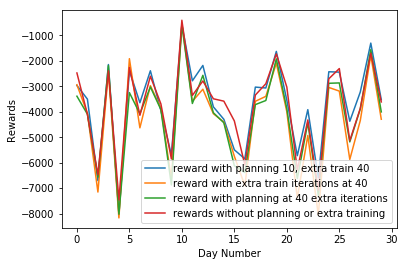

In [22]:
plt.figure()
plt.plot(rewards_both, label = 'reward with planning 10, extra train 40')
plt.plot(rewards_extra_train, label = "reward with extra train iterations at 40")
plt.plot(rewards_plan, label = "reward with planning at 40 extra iterations")
plt.plot(rewards_wo, label = "rewards without planning or extra training")
plt.legend()
plt.xlabel("Day Number")
plt.ylabel("Rewards")



In [27]:
print("total reward without:" + str(sum(rewards_wo)))
print("total reward with extra train:" + str(sum(rewards_extra_train)))
print("total reward with planning:" + str(sum(rewards_plan)))
print("total reward with both:" + str(sum(rewards_both)))

total reward without:-113642.31469338658
total reward with extra train:-129226.22927744042
total reward with planning:-125111.46310461816
total reward with both:-111316.40735969838


Text(0,0.5,'Rewards')

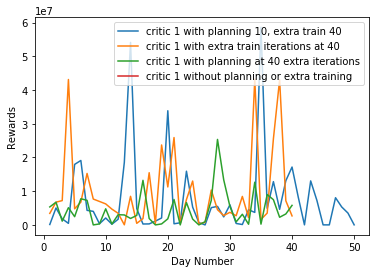

In [29]:
plt.figure()
plt.plot(critic_1_losses_both, label = 'critic 1 with planning 10, extra train 40')
plt.plot(critic_1_losses_extra_train, label = "critic 1 with extra train iterations at 40")
plt.plot(critic_1_losses_plan, label = "critic 1 with planning at 40 extra iterations")
plt.plot(critic_1_losses_wo, label = "critic 1 without planning or extra training")
plt.legend()
plt.xlabel("Day Number")
plt.ylabel("Rewards")

## Testing different numbers of planning iterations

In [30]:
rewards_plan_10, critic_1_losses_plan_10, critic_2_losses_plan_10, policy_losses_plan_10, alpha_losses_plan_10 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 10
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(17864164.0, 17722600.0, 279.4324645996094, -0.0)
--------------------
--------------------
 planning step 1
(17836558.0, 17677472.0, 271.277099609375, -0.05021260678768158)
--------------------
--------------------
 planning step 2
(16612638.0, 16441756.0, 267.40789794921875, -0.09500893205404282)
--------------------
--------------------
 planning step 3
(16627707.0, 16439661.0, 269.535888671875, -0.140153706073761)
--------------------
--------------------
 planning step 4
(16371803.0, 16168820.0, 269.68035888671875, -0.18089944124221802)
--------------------
--------------------
 planning step 5
(16000766.0, 15793299.0, 262.86358642578125, -0.20803759

--------------------------------------------------------------------------------
Day: 37
Loaded model from disk
--------------------
 planning step 0
(13675274.0, 12859618.0, 514.9154663085938, -2.241880416870117)
--------------------
--------------------
 planning step 1
(8294209.0, 7767165.0, 427.7475280761719, -1.7432197332382202)
--------------------
--------------------
 planning step 2
(40258164.0, 38917988.0, 474.31683349609375, -2.0091018676757812)
--------------------
--------------------
 planning step 3
(23361598.0, 21970144.0, 604.6221313476562, -2.147587776184082)
--------------------
--------------------
 planning step 4
(8141513.5, 7603230.0, 444.5698547363281, -1.9063316583633423)
--------------------
--------------------
 planning step 5
(40200360.0, 38821468.0, 503.9795227050781, -2.3062925338745117)
--------------------
--------------------
 planning step 6
(8084856.5, 7538452.5, 445.682861328125, -1.7890253067016602)
--------------------
--------------------
 planni

(6953326.0, 6171730.0, 801.8330688476562, -3.0824203491210938)
--------------------
--------------------
 planning step 2
(11538053.0, 10287724.0, 957.880859375, -3.364614725112915)
--------------------
--------------------
 planning step 3
(27197198.0, 25270350.0, 978.201171875, -3.928072690963745)
--------------------
--------------------
 planning step 4
(12841194.0, 11188958.0, 1170.15771484375, -3.3483996391296387)
--------------------
--------------------
 planning step 5
(20303944.0, 18202530.0, 1180.6103515625, -3.15997576713562)
--------------------
--------------------
 planning step 6
(3985042.75, 3214224.0, 1066.1158447265625, -3.496845006942749)
--------------------
--------------------
 planning step 7
(34593012.0, 32464382.0, 932.3148193359375, -3.5113279819488525)
--------------------
--------------------
 planning step 8
(36278572.0, 34080484.0, 925.910400390625, -2.911210060119629)
--------------------
--------------------
 planning step 9
(10893524.0, 9823381.0, 853.

(5943325.0, 4330544.5, 1607.3067626953125, -4.526068210601807)
--------------------
--------------------
 planning step 4
(8323250.5, 6449926.0, 1708.7691650390625, -4.2664690017700195)
--------------------
--------------------
 planning step 5
(5871769.0, 4243658.5, 1600.8328857421875, -2.9995734691619873)
--------------------
--------------------
 planning step 6
(17938150.0, 14350291.0, 1945.5286865234375, -3.1472201347351074)
--------------------
--------------------
 planning step 7
(8698106.0, 6071137.0, 2232.9521484375, -4.459258079528809)
--------------------
--------------------
 planning step 8
(8398729.0, 6260617.5, 1879.1640625, -4.958085060119629)
--------------------
--------------------
 planning step 9
(14549159.0, 11105638.0, 2288.614013671875, -4.488744258880615)
--------------------
--------------------------------------------------------------------------------
Day: 50
Loaded model from disk
--------------------
 planning step 0
(9402060.0, 7467138.0, 1600.735107421

(5338983.5, 3297589.0, 2712.0615234375, -5.708510398864746)
--------------------
--------------------
 planning step 6
(6181570.0, 3330347.75, 2997.028564453125, -6.1325459480285645)
--------------------
--------------------
 planning step 7
(3715406.75, 2127451.5, 2417.6689453125, -4.710431098937988)
--------------------
--------------------
 planning step 8
(3483767.0, 1806441.625, 2577.332275390625, -3.7635788917541504)
--------------------
--------------------
 planning step 9
(3449061.5, 1777230.75, 2608.65771484375, -4.411015033721924)
--------------------
--------------------------------------------------------------------------------
Day: 56
Loaded model from disk
--------------------
 planning step 0
(3540067.5, 1815232.5, 2621.81494140625, -4.589019298553467)
--------------------
--------------------
 planning step 1
(12403848.0, 7813574.0, 3730.8955078125, -4.043529033660889)
--------------------
--------------------
 planning step 2
(4274484.5, 1898853.75, 3608.2734375, -4.

In [31]:
rewards_plan_30, critic_1_losses_plan_30, critic_2_losses_plan_30, policy_losses_plan_30, alpha_losses_plan_30 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 30
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(13022578.0, 12996620.0, 240.21534729003906, -0.0)
--------------------
--------------------
 planning step 1
(12980652.0, 12977218.0, 234.10873413085938, -0.06721147149801254)
--------------------
--------------------
 planning step 2
(12952337.0, 12971425.0, 232.56224060058594, -0.1318109929561615)
--------------------
--------------------
 planning step 3
(12927503.0, 12969128.0, 231.7638397216797, -0.19403041899204254)
--------------------
--------------------
 planning step 4
(12883368.0, 12947505.0, 230.49459838867188, -0.2532074749469757)
--------------------
--------------------
 planning step 5
(12894736.0, 12981558.0, 232.43643188476562, -0.3143

(15625499.0, 16378207.0, 354.24627685546875, -3.2146308422088623)
--------------------
--------------------
 planning step 3
(12022925.0, 12573157.0, 318.821044921875, -3.204737901687622)
--------------------
--------------------
 planning step 4
(11990264.0, 12537851.0, 324.62457275390625, -3.3229308128356934)
--------------------
--------------------
 planning step 5
(11976054.0, 12522418.0, 322.5133056640625, -3.2944865226745605)
--------------------
--------------------
 planning step 6
(15560375.0, 16312866.0, 364.1923522949219, -3.4094340801239014)
--------------------
--------------------
 planning step 7
(15527858.0, 16270554.0, 369.09869384765625, -3.5019359588623047)
--------------------
--------------------
 planning step 8
(11949754.0, 12493455.0, 327.94891357421875, -3.4171853065490723)
--------------------
--------------------
 planning step 9
(34917428.0, 35732480.0, 323.66412353515625, -3.6448333263397217)
--------------------
--------------------
 planning step 10
(119

(7204925.5, 7425502.5, 434.420166015625, -6.402812480926514)
--------------------
--------------------
 planning step 8
(14212716.0, 14635255.0, 565.7203979492188, -6.488513946533203)
--------------------
--------------------
 planning step 9
(11106326.0, 11419241.0, 505.8699035644531, -6.91896390914917)
--------------------
--------------------
 planning step 10
(7183008.5, 7392045.0, 441.37158203125, -6.512120723724365)
--------------------
--------------------
 planning step 11
(43278228.0, 43838968.0, 481.21923828125, -6.563273906707764)
--------------------
--------------------
 planning step 12
(43224236.0, 43773280.0, 485.39990234375, -6.645965099334717)
--------------------
--------------------
 planning step 13
(14187039.0, 14569357.0, 587.2325439453125, -6.755681991577148)
--------------------
--------------------
 planning step 14
(7150909.5, 7335179.0, 444.8365478515625, -6.477873802185059)
--------------------
--------------------
 planning step 15
(7160990.5, 7339830.5, 4

(31501312.0, 31157918.0, 751.91064453125, -9.605459213256836)
--------------------
--------------------
 planning step 13
(12131333.0, 11787306.0, 978.47314453125, -9.599626541137695)
--------------------
--------------------
 planning step 14
(6283728.0, 6133476.5, 712.3814697265625, -9.61766242980957)
--------------------
--------------------
 planning step 15
(9100607.0, 8845481.0, 859.6661376953125, -9.854650497436523)
--------------------
--------------------
 planning step 16
(12016026.0, 11627016.0, 1000.406982421875, -9.358465194702148)
--------------------
--------------------
 planning step 17
(31139364.0, 30708694.0, 776.9976806640625, -9.278369903564453)
--------------------
--------------------
 planning step 18
(13904724.0, 13490569.0, 979.88623046875, -9.549915313720703)
--------------------
--------------------
 planning step 19
(31120898.0, 30644814.0, 804.1563720703125, -10.019893646240234)
--------------------
--------------------
 planning step 20
(40083292.0, 39475

(5026471.0, 3864673.25, 1328.874755859375, -12.163091659545898)
--------------------
--------------------
 planning step 18
(9335892.0, 7604101.0, 1388.0523681640625, -11.905473709106445)
--------------------
--------------------
 planning step 19
(9073026.0, 6604424.5, 1967.581298828125, -13.199813842773438)
--------------------
--------------------
 planning step 20
(4907699.5, 3701513.5, 1357.317626953125, -11.949268341064453)
--------------------
--------------------
 planning step 21
(4930839.5, 3702295.0, 1379.8450927734375, -12.85281753540039)
--------------------
--------------------
 planning step 22
(36258652.0, 32167496.0, 1566.170166015625, -12.555126190185547)
--------------------
--------------------
 planning step 23
(10777951.0, 8029668.5, 1936.41259765625, -12.243180274963379)
--------------------
--------------------
 planning step 24
(7855191.5, 6102603.0, 1469.71240234375, -12.892109870910645)
--------------------
--------------------
 planning step 25
(3104980.0, 1

(7579798.0, 3154160.5, 3163.59130859375, -15.317665100097656)
--------------------
--------------------
 planning step 23
(3583963.0, 1485910.375, 2249.527587890625, -14.606790542602539)
--------------------
--------------------
 planning step 24
(7417508.0, 4044109.25, 2357.787109375, -14.178767204284668)
--------------------
--------------------
 planning step 25
(5704953.0, 1806687.125, 3384.233154296875, -16.044193267822266)
--------------------
--------------------
 planning step 26
(4658431.0, 1632910.875, 2859.074462890625, -15.482309341430664)
--------------------
--------------------
 planning step 27
(5064746.0, 1901406.0, 2814.685791015625, -15.059345245361328)
--------------------
--------------------
 planning step 28
(1354778.125, 91942.203125, 2765.9169921875, -14.440461158752441)
--------------------
--------------------
 planning step 29
(5497325.0, 1605605.125, 3462.724609375, -15.005537033081055)
--------------------
--------------------------------------------------

(2876850.0, 291463.4375, 3970.990234375, -17.532957077026367)
--------------------
--------------------
 planning step 28
(6104933.5, 2298287.0, 3327.0390625, -16.37837791442871)
--------------------
--------------------
 planning step 29
(4538945.0, 1376688.0, 3359.968017578125, -18.28780174255371)
--------------------
--------------------------------------------------------------------------------
Day: 44
Loaded model from disk
--------------------
 planning step 0
(380953.5625, 243492.125, 3876.96630859375, -19.620534896850586)
--------------------
--------------------
 planning step 1
(5449814.0, 1941512.25, 3257.23291015625, -17.91948699951172)
--------------------
--------------------
 planning step 2
(885156.1875, 13949.9970703125, 3717.74560546875, -18.183717727661133)
--------------------
--------------------
 planning step 3
(2752511.75, 254977.65625, 4061.48095703125, -19.164234161376953)
--------------------
--------------------
 planning step 4
(2162794.5, 314050.25, 3264.

(773301.25, 171214.921875, 5882.5849609375, -19.081022262573242)
--------------------
--------------------
 planning step 2
(16049210.0, 9465011.0, 4304.78173828125, -17.760866165161133)
--------------------
--------------------
 planning step 3
(4111982.0, 1261199.75, 4204.1220703125, -19.645980834960938)
--------------------
--------------------
 planning step 4
(1887688.125, 24645.78125, 5679.81201171875, -20.698383331298828)
--------------------
--------------------
 planning step 5
(1724755.125, 9937.5, 5690.56298828125, -20.54340362548828)
--------------------
--------------------
 planning step 6
(3467976.0, 993082.3125, 4144.884765625, -19.67643928527832)
--------------------
--------------------
 planning step 7
(7053626.5, 2978211.5, 4429.25, -18.412508010864258)
--------------------
--------------------
 planning step 8
(7089771.0, 2902458.0, 4637.716796875, -21.17292022705078)
--------------------
--------------------
 planning step 9
(1149277.75, 66995.9140625, 4020.586181

(2150096.75, 660756.25, 5011.9287109375, -21.250211715698242)
--------------------
--------------------
 planning step 7
(1791.4635009765625, 908537.5625, 7046.62451171875, -21.35048484802246)
--------------------
--------------------
 planning step 8
(1308824.25, 271767.21875, 4931.744140625, -23.140390396118164)
--------------------
--------------------
 planning step 9
(16741451.0, 11652119.0, 5420.61083984375, -21.776920318603516)
--------------------
--------------------
 planning step 10
(190950.65625, 81296.8203125, 5869.52880859375, -26.768373489379883)
--------------------
--------------------
 planning step 11
(388797.0, 2569.519775390625, 4769.392578125, -23.39406394958496)
--------------------
--------------------
 planning step 12
(48539.3203125, 1195840.5, 6899.787109375, -24.526718139648438)
--------------------
--------------------
 planning step 13
(2477585.25, 944992.8125, 4808.2236328125, -22.31976318359375)
--------------------
--------------------
 planning step 14

(2726778.25, 1849076.75, 5677.224609375, -19.655574798583984)
--------------------
--------------------
 planning step 11
(10202534.0, 8562870.0, 5615.32421875, -20.961610794067383)
--------------------
--------------------
 planning step 12
(820895.25, 1475610.5, 6171.07861328125, -21.447999954223633)
--------------------
--------------------
 planning step 13
(1300078.75, 781197.0625, 5471.677734375, -20.320863723754883)
--------------------
--------------------
 planning step 14
(186428.71875, 501149.9375, 5889.494140625, -20.268781661987305)
--------------------
--------------------
 planning step 15
(174209.234375, 475303.1875, 5900.17041015625, -20.81048011779785)
--------------------
--------------------
 planning step 16
(3637639.75, 2680375.0, 5752.560546875, -23.0520076751709)
--------------------
--------------------
 planning step 17
(1987004.125, 1306780.5, 5755.1884765625, -22.312152862548828)
--------------------
--------------------
 planning step 18
(241702.34375, 7623

(75423.71875, 11914.8740234375, 5829.44677734375, -20.468454360961914)
--------------------
--------------------
 planning step 16
(651672.25, 395381.21875, 6912.93896484375, -22.34946060180664)
--------------------
--------------------
 planning step 17
(8481985.0, 7415545.5, 6470.70166015625, -23.822359085083008)
--------------------
--------------------
 planning step 18
(2710734.0, 2081293.625, 6805.86865234375, -18.399137496948242)
--------------------
--------------------
 planning step 19
(2655028.5, 2016806.375, 6605.9033203125, -20.039772033691406)
--------------------
--------------------
 planning step 20
(106624.5703125, 2207.210205078125, 8270.6162109375, -19.995553970336914)
--------------------
--------------------
 planning step 21
(1350998.75, 791536.875, 8479.9931640625, -23.645116806030273)
--------------------
--------------------
 planning step 22
(44323.203125, 3932.600341796875, 8341.6787109375, -24.875940322875977)
--------------------
--------------------
 plan

(1419354.625, 1181340.75, 6916.0693359375, -26.033449172973633)
--------------------
--------------------
 planning step 21
(11661888.0, 10998625.0, 7460.1201171875, -27.211328506469727)
--------------------
--------------------
 planning step 22
(13466366.0, 12762523.0, 7475.56982421875, -25.495004653930664)
--------------------
--------------------
 planning step 23
(200970.96875, 301498.0625, 8069.98095703125, -28.960693359375)
--------------------
--------------------
 planning step 24
(12349150.0, 11644213.0, 7533.1337890625, -27.456560134887695)
--------------------
--------------------
 planning step 25
(286907.21875, 425902.1875, 8234.0576171875, -25.299543380737305)
--------------------
--------------------
 planning step 26
(2793163.0, 3303112.75, 9886.787109375, -26.131498336791992)
--------------------
--------------------
 planning step 27
(242995.078125, 360851.875, 8159.83056640625, -30.388017654418945)
--------------------
--------------------
 planning step 28
(906503.

(886942.75, 826285.4375, 8107.82763671875, -28.54709243774414)
--------------------
--------------------
 planning step 26
(587725.125, 677832.1875, 7912.57958984375, -25.903764724731445)
--------------------
--------------------
 planning step 27
(2602033.75, 2878957.25, 10371.4072265625, -26.547021865844727)
--------------------
--------------------
 planning step 28
(89.23237609863281, 2501.07421875, 7492.39697265625, -26.05443000793457)
--------------------
--------------------
 planning step 29
(2022620.125, 1835625.375, 7391.68359375, -29.442333221435547)
--------------------
--------------------------------------------------------------------------------
Day: 57
Loaded model from disk
--------------------
 planning step 0
(124965.359375, 167100.109375, 8553.3212890625, -28.758516311645508)
--------------------
--------------------
 planning step 1
(2914152.5, 2774547.5, 8171.20654296875, -26.663789749145508)
--------------------
--------------------
 planning step 2
(2762146.5, 

--------------------------------------------------------------------------------
Day: 59
Loaded model from disk
--------------------
 planning step 0
(3033552.0, 2960162.25, 7802.16162109375, -27.52419662475586)
--------------------
--------------------
 planning step 1
(12718.068359375, 59039.984375, 10580.6630859375, -30.43234634399414)
--------------------
--------------------
 planning step 2
(1335428.5, 1569549.0, 10955.091796875, -30.331785202026367)
--------------------
--------------------
 planning step 3
(62163.78515625, 22079.0859375, 8199.9814453125, -28.15591049194336)
--------------------
--------------------
 planning step 4
(289280.09375, 372027.3125, 9419.6787109375, -33.720157623291016)
--------------------
--------------------
 planning step 5
(1093266.25, 994523.125, 10340.3564453125, -32.750511169433594)
--------------------
--------------------
 planning step 6
(274767.40625, 354890.125, 9438.8203125, -30.292770385742188)
--------------------
--------------------


In [56]:
rewards_plan_50, critic_1_losses_plan_50, critic_2_losses_plan_50, policy_losses_plan_50, alpha_losses_plan_50, reward_planning_50 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 50
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(17589050.0, 18275988.0, 278.5548400878906, -0.0)
--------------------
--------------------
 planning step 1
(17494258.0, 18206802.0, 272.2568054199219, -0.0587289035320282)
--------------------
--------------------
 planning step 2
(17490954.0, 18231140.0, 273.4970703125, -0.1151764765381813)
--------------------
--------------------
 planning step 3
(17349638.0, 18114624.0, 277.0526123046875, -0.1714525669813156)
--------------------
--------------------
 planning step 4
(17335882.0, 18128730.0, 283.658935546875, -0.23052829504013062)
--------------------
--------------------
 planning step 5
(17321166.0, 18140686.0, 283.02410888671875, -0.2800387740135

(15572500.0, 18286894.0, 481.1360168457031, -2.523329973220825)
--------------------
--------------------
 planning step 14
(15626390.0, 18384252.0, 488.590087890625, -2.6097395420074463)
--------------------
--------------------
 planning step 15
(20704438.0, 24615640.0, 571.4103393554688, -2.752241849899292)
--------------------
--------------------
 planning step 16
(20661938.0, 24622112.0, 578.1961059570312, -2.811330556869507)
--------------------
--------------------
 planning step 17
(20472726.0, 24474322.0, 580.8323364257812, -2.7833285331726074)
--------------------
--------------------
 planning step 18
(15302386.0, 18195402.0, 501.4833068847656, -2.630999803543091)
--------------------
--------------------
 planning step 19
(15450817.0, 18401092.0, 507.0061340332031, -2.671600818634033)
--------------------
--------------------
 planning step 20
(15432040.0, 18425036.0, 510.5820617675781, -2.6945104598999023)
--------------------
--------------------
 planning step 21
(20495

(12583071.0, 18906326.0, 958.9129638671875, -5.2103495597839355)
--------------------
--------------------
 planning step 30
(12517482.0, 18921930.0, 965.2246704101562, -5.002180576324463)
--------------------
--------------------
 planning step 31
(33259438.0, 42757660.0, 937.1484375, -5.457040786743164)
--------------------
--------------------
 planning step 32
(16369385.0, 25797214.0, 1187.57763671875, -5.163639545440674)
--------------------
--------------------
 planning step 33
(16320553.0, 25880352.0, 1209.934326171875, -5.499194145202637)
--------------------
--------------------
 planning step 34
(12373294.0, 19141394.0, 1022.463134765625, -5.562493324279785)
--------------------
--------------------
 planning step 35
(12351173.0, 19215818.0, 1020.3984375, -5.202712535858154)
--------------------
--------------------
 planning step 36
(16571214.0, 26589376.0, 1246.8104248046875, -5.425309658050537)
--------------------
--------------------
 planning step 37
(32906726.0, 43206

(10248877.0, 28894578.0, 2334.20263671875, -7.728643417358398)
--------------------
--------------------
 planning step 46
(25554150.0, 45288076.0, 1825.2352294921875, -7.930548667907715)
--------------------
--------------------
 planning step 47
(9247984.0, 27714184.0, 2369.78662109375, -7.532304763793945)
--------------------
--------------------
 planning step 48
(7645620.5, 21046568.0, 1962.6097412109375, -7.272684097290039)
--------------------
--------------------
 planning step 49
(9075934.0, 27900122.0, 2414.7119140625, -7.198161602020264)
--------------------
--------------------------------------------------------------------------------
Day: 35
Loaded model from disk
--------------------
 planning step 0
(25151282.0, 45642700.0, 1878.29931640625, -6.892638206481934)
--------------------
--------------------
 planning step 1
(7396750.5, 21149028.0, 2029.1015625, -7.659451961517334)
--------------------
--------------------
 planning step 2
(25054806.0, 45989100.0, 1924.80590

(15718995.0, 49798556.0, 3225.9609375, -8.983636856079102)
--------------------
--------------------
 planning step 12
(28546888.0, 74017256.0, 3396.20068359375, -8.665034294128418)
--------------------
--------------------
 planning step 13
(1239528.375, 16234411.0, 3060.572509765625, -9.602646827697754)
--------------------
--------------------
 planning step 14
(15604062.0, 50870656.0, 3335.231201171875, -10.99693775177002)
--------------------
--------------------
 planning step 15
(2446261.75, 24797238.0, 3553.51513671875, -9.646946907043457)
--------------------
--------------------
 planning step 16
(2027033.5, 32168880.0, 4416.7626953125, -10.70096206665039)
--------------------
--------------------
 planning step 17
(29708184.0, 78551248.0, 3565.850341796875, -9.81696605682373)
--------------------
--------------------
 planning step 18
(26453442.0, 73818672.0, 3592.45849609375, -10.085853576660156)
--------------------
--------------------
 planning step 19
(1229868.5, 237835

(587.5653076171875, 29203210.0, 5591.90087890625, -13.270447731018066)
--------------------
--------------------
 planning step 28
(41498.94140625, 31901984.0, 5608.1025390625, -13.23896598815918)
--------------------
--------------------
 planning step 29
(35888.41796875, 21511334.0, 4612.19775390625, -13.746026039123535)
--------------------
--------------------
 planning step 30
(6463.90869140625, 39250416.0, 6495.388671875, -13.262301445007324)
--------------------
--------------------
 planning step 31
(15287233.0, 80584952.0, 5209.26416015625, -12.150995254516602)
--------------------
--------------------
 planning step 32
(29618.275390625, 21735728.0, 4637.8828125, -13.003132820129395)
--------------------
--------------------
 planning step 33
(315.33990478515625, 41060144.0, 6527.88916015625, -11.60341739654541)
--------------------
--------------------
 planning step 34
(16030702.0, 83208144.0, 5257.48779296875, -12.122952461242676)
--------------------
--------------------
 

(13353.7890625, 28611336.0, 5336.9931640625, -14.369850158691406)
--------------------
--------------------
 planning step 43
(15062794.0, 96216880.0, 6081.14453125, -15.979130744934082)
--------------------
--------------------
 planning step 44
(91340.0078125, 51048444.0, 7563.2685546875, -14.36476993560791)
--------------------
--------------------
 planning step 45
(21762.876953125, 39699240.0, 6589.7578125, -16.289627075195312)
--------------------
--------------------
 planning step 46
(158977.8125, 51766372.0, 7744.154296875, -16.94809913635254)
--------------------
--------------------
 planning step 47
(109055.7109375, 40840648.0, 6171.6728515625, -14.599604606628418)
--------------------
--------------------
 planning step 48
(25890.5078125, 39731208.0, 6627.83544921875, -16.264625549316406)
--------------------
--------------------
 planning step 49
(7877442.5, 72347816.0, 5793.2373046875, -13.526252746582031)
--------------------
--------------------------------------------

(59115.9375, 33634812.0, 6200.087890625, -16.00368309020996)
--------------------
--------------------
 planning step 7
(219192.21875, 50960572.0, 6785.31201171875, -18.769067764282227)
--------------------
--------------------
 planning step 8
(119205.65625, 37832700.0, 5940.93310546875, -17.015182495117188)
--------------------
--------------------
 planning step 9
(74762.1953125, 33777540.0, 6254.595703125, -19.06173324584961)
--------------------
--------------------
 planning step 10
(68589.515625, 65920604.0, 8539.1357421875, -19.285585403442383)
--------------------
--------------------
 planning step 11
(54730.1796875, 34326972.0, 6275.6904296875, -18.799907684326172)
--------------------
--------------------
 planning step 12
(1636721.625, 45506152.0, 5629.2294921875, -17.314430236816406)
--------------------
--------------------
 planning step 13
(145026.71875, 38699960.0, 5959.63671875, -17.56803321838379)
--------------------
--------------------
 planning step 14
(18959128

(104278.8515625, 64671180.0, 7836.47607421875, -21.784284591674805)
--------------------
--------------------
 planning step 23
(8571731.0, 103207960.0, 7380.4296875, -22.07125473022461)
--------------------
--------------------
 planning step 24
(5377260.5, 91691096.0, 7432.53271484375, -22.325260162353516)
--------------------
--------------------
 planning step 25
(114310.3515625, 65360040.0, 7844.8505859375, -21.92287254333496)
--------------------
--------------------
 planning step 26
(80539.28125, 45666180.0, 7233.9873046875, -21.680572509765625)
--------------------
--------------------
 planning step 27
(67150.0703125, 46350180.0, 7236.66259765625, -20.637880325317383)
--------------------
--------------------
 planning step 28
(3833033.5, 35320984.0, 8098.494140625, -21.390525817871094)
--------------------
--------------------
 planning step 29
(124439.796875, 66264300.0, 7904.1650390625, -22.025333404541016)
--------------------
--------------------
 planning step 30
(34756

(1716033.5, 79605712.0, 10422.5390625, -25.404420852661133)
--------------------
--------------------
 planning step 39
(4313716.0, 46041216.0, 9010.197265625, -24.95743179321289)
--------------------
--------------------
 planning step 40
(1633833.125, 80468192.0, 10408.6357421875, -23.749799728393555)
--------------------
--------------------
 planning step 41
(173342.125, 63662640.0, 7679.650390625, -26.992048263549805)
--------------------
--------------------
 planning step 42
(118336.0, 81682552.0, 8792.171875, -26.700050354003906)
--------------------
--------------------
 planning step 43
(1007847.375, 94246840.0, 10832.0302734375, -27.284774780273438)
--------------------
--------------------
 planning step 44
(54421.5078125, 81508808.0, 9380.578125, -27.035966873168945)
--------------------
--------------------
 planning step 45
(8913274.0, 123755912.0, 8253.4951171875, -26.48883628845215)
--------------------
--------------------
 planning step 46
(16356.13671875, 60207840.0

(838022.25, 119624224.0, 12034.6787109375, -29.02519989013672)
--------------------
--------------------
 planning step 4
(35784.51953125, 98410392.0, 10274.67578125, -29.818315505981445)
--------------------
--------------------
 planning step 5
(6151209.0, 129557280.0, 9056.9541015625, -28.128652572631836)
--------------------
--------------------
 planning step 6
(2762450.25, 88827384.0, 7913.89453125, -28.59096908569336)
--------------------
--------------------
 planning step 7
(35537.03515625, 99475576.0, 10328.751953125, -29.881853103637695)
--------------------
--------------------
 planning step 8
(1610405.625, 99230472.0, 11427.2919921875, -28.857202529907227)
--------------------
--------------------
 planning step 9
(9237587.0, 144656992.0, 9102.2578125, -30.81472396850586)
--------------------
--------------------
 planning step 10
(19599280.0, 191750208.0, 9589.8369140625, -30.56914520263672)
--------------------
--------------------
 planning step 11
(1732588.625, 103552

(16413141.0, 212530704.0, 10652.4306640625, -33.268165588378906)
--------------------
--------------------
 planning step 20
(4884661.0, 75160432.0, 11022.0654296875, -31.214845657348633)
--------------------
--------------------
 planning step 21
(187392.609375, 120766424.0, 11513.0576171875, -31.449010848999023)
--------------------
--------------------
 planning step 22
(8979598.0, 169563328.0, 10145.27734375, -32.51287078857422)
--------------------
--------------------
 planning step 23
(14.187287330627441, 94104568.0, 9902.0615234375, -32.79730224609375)
--------------------
--------------------
 planning step 24
(2484182.25, 135419472.0, 13318.6376953125, -34.15184783935547)
--------------------
--------------------
 planning step 25
(3321549.0, 111259584.0, 8933.7861328125, -28.728294372558594)
--------------------
--------------------
 planning step 26
(378798.1875, 98471856.0, 9448.44921875, -31.491201400756836)
--------------------
--------------------
 planning step 27
(152

(502017.90625, 140118432.0, 11202.0654296875, -36.17778015136719)
--------------------
--------------------
 planning step 36
(5564581.5, 130640192.0, 9286.2490234375, -37.01161575317383)
--------------------
--------------------
 planning step 37
(1101230.875, 115517512.0, 9825.462890625, -36.807125091552734)
--------------------
--------------------
 planning step 38
(3145382.0, 92052704.0, 11557.3076171875, -36.96579360961914)
--------------------
--------------------
 planning step 39
(11711595.0, 194439472.0, 10647.634765625, -36.926029205322266)
--------------------
--------------------
 planning step 40
(1785083.875, 163654272.0, 14232.744140625, -36.8673210144043)
--------------------
--------------------
 planning step 41
(24032802.0, 256376352.0, 11212.603515625, -37.38662338256836)
--------------------
--------------------
 planning step 42
(374062.4375, 142368128.0, 11393.087890625, -36.6995964050293)
--------------------
--------------------
 planning step 43
(1571612.375,

(426581.1875, 187743808.0, 13271.400390625, -40.749000549316406)
--------------------
--------------------
 planning step 1
(666753.5625, 164892480.0, 12210.2607421875, -40.71622085571289)
--------------------
--------------------
 planning step 2
(2206568.0, 184603760.0, 15286.814453125, -39.246463775634766)
--------------------
--------------------
 planning step 3
(19308102.0, 288274240.0, 12707.1357421875, -41.06288146972656)
--------------------
--------------------
 planning step 4
(415868.8125, 138930096.0, 11231.8369140625, -40.351383209228516)
--------------------
--------------------
 planning step 5
(2032476.25, 185956400.0, 15282.7294921875, -40.53660583496094)
--------------------
--------------------
 planning step 6
(4917211.0, 184860832.0, 15877.650390625, -40.65573501586914)
--------------------
--------------------
 planning step 7
(98806.46875, 137785184.0, 11647.67578125, -41.279808044433594)
--------------------
--------------------
 planning step 8
(4863446.5, 158

(4873729.0, 209859312.0, 16754.671875, -43.832679748535156)
--------------------
--------------------
 planning step 17
(4715336.0, 133188936.0, 13907.083984375, -43.72270202636719)
--------------------
--------------------
 planning step 18
(144855.3125, 196546512.0, 14515.4423828125, -44.07280731201172)
--------------------
--------------------
 planning step 19
(3315248.0, 226587904.0, 17034.12109375, -44.508277893066406)
--------------------
--------------------
 planning step 20
(20849470.0, 317854144.0, 13363.6591796875, -42.983516693115234)
--------------------
--------------------
 planning step 21
(1166262.875, 218271040.0, 13917.044921875, -43.48798751831055)
--------------------
--------------------
 planning step 22
(7494703.0, 236038784.0, 12801.7421875, -44.421871185302734)
--------------------
--------------------
 planning step 23
(216135.09375, 162748304.0, 12451.3828125, -44.87982940673828)
--------------------
--------------------
 planning step 24
(4124286.75, 21375

(6714566.5, 204377072.0, 11847.08203125, -46.420135498046875)
--------------------
--------------------
 planning step 33
(1874845.5, 218054880.0, 13626.3017578125, -46.9822883605957)
--------------------
--------------------
 planning step 34
(1898846.375, 240150416.0, 17105.044921875, -47.291500091552734)
--------------------
--------------------
 planning step 35
(411070.0625, 186238448.0, 13237.1181640625, -47.568607330322266)
--------------------
--------------------
 planning step 36
(243061.515625, 220954896.0, 14429.556640625, -46.94639587402344)
--------------------
--------------------
 planning step 37
(3540906.0, 230296928.0, 13443.2822265625, -47.91211700439453)
--------------------
--------------------
 planning step 38
(10997339.0, 284209152.0, 13610.19921875, -47.648380279541016)
--------------------
--------------------
 planning step 39
(5942158.5, 200899792.0, 11960.3984375, -46.12362289428711)
--------------------
--------------------
 planning step 40
(2001887.875,

(7648357.5, 274280576.0, 19412.103515625, -50.19790267944336)
--------------------
--------------------------------------------------------------------------------
Day: 52
Loaded model from disk
--------------------
 planning step 0
(7576380.0, 241296000.0, 13010.11328125, -49.49799728393555)
--------------------
--------------------
 planning step 1
(6686830.5, 290917184.0, 19803.080078125, -50.81317901611328)
--------------------
--------------------
 planning step 2
(3091731.5, 263520080.0, 14676.0078125, -51.027244567871094)
--------------------
--------------------
 planning step 3
(25596.25, 252460416.0, 15770.8310546875, -49.47758865356445)
--------------------
--------------------
 planning step 4
(7777012.0, 243229456.0, 13024.5322265625, -46.77370834350586)
--------------------
--------------------
 planning step 5
(17755154.0, 390307392.0, 15594.958984375, -50.49482345581055)
--------------------
--------------------
 planning step 6
(4544.392578125, 219458304.0, 14970.20507

(7285908.5, 297199136.0, 20142.216796875, -54.370304107666016)
--------------------
--------------------
 planning step 16
(8307669.0, 277915648.0, 14030.7998046875, -54.53268051147461)
--------------------
--------------------
 planning step 17
(954355.375, 246506992.0, 14800.236328125, -53.86159896850586)
--------------------
--------------------
 planning step 18
(5328622.0, 309814048.0, 20146.515625, -53.23289489746094)
--------------------
--------------------
 planning step 19
(5198052.5, 310348704.0, 20136.80859375, -54.120697021484375)
--------------------
--------------------
 planning step 20
(9681.099609375, 289096640.0, 16944.146484375, -54.25538635253906)
--------------------
--------------------
 planning step 21
(19822.109375, 289879424.0, 16922.1640625, -53.64845657348633)
--------------------
--------------------
 planning step 22
(381354.5, 245744576.0, 15296.80859375, -53.72282028198242)
--------------------
--------------------
 planning step 23
(6976016.0, 33911465

(4007929.75, 324641088.0, 16260.3369140625, -57.17737579345703)
--------------------
--------------------
 planning step 33
(7511582.0, 301518272.0, 14771.384765625, -55.632301330566406)
--------------------
--------------------
 planning step 34
(10612935.0, 368481696.0, 22568.986328125, -58.09698486328125)
--------------------
--------------------
 planning step 35
(4025650.25, 326397152.0, 16303.48046875, -56.99518585205078)
--------------------
--------------------
 planning step 36
(17217978.0, 478040832.0, 17755.970703125, -57.82285690307617)
--------------------
--------------------
 planning step 37
(1422470.875, 324603488.0, 17034.90234375, -53.8199577331543)
--------------------
--------------------
 planning step 38
(3902546.25, 343165632.0, 16797.109375, -58.222747802734375)
--------------------
--------------------
 planning step 39
(1193616.0, 280275808.0, 15760.6357421875, -57.42050552368164)
--------------------
--------------------
 planning step 40
(258533.515625, 277

(4165202.75, 380755200.0, 17672.90234375, -59.32706832885742)
--------------------
--------------------
 planning step 49
(530934.25, 311214592.0, 17163.77734375, -60.90557861328125)
--------------------
--------------------------------------------------------------------------------
Day: 56
Loaded model from disk
--------------------
 planning step 0
(34174288.0, 451828256.0, 15664.3798828125, -61.671630859375)
--------------------
--------------------
 planning step 1
(5503.78515625, 314970976.0, 17926.02734375, -61.389583587646484)
--------------------
--------------------
 planning step 2
(7512224.5, 380823264.0, 22462.880859375, -60.93501663208008)
--------------------
--------------------
 planning step 3
(2015318.5, 366765664.0, 17927.638671875, -60.88723373413086)
--------------------
--------------------
 planning step 4
(6685406.0, 276942720.0, 19375.62890625, -60.00703048706055)
--------------------
--------------------
 planning step 5
(9629967.0, 346570592.0, 15593.0644531

(20850782.0, 590627840.0, 19861.658203125, -63.74860382080078)
--------------------
--------------------
 planning step 15
(10079596.0, 382947680.0, 16651.2109375, -64.40447235107422)
--------------------
--------------------
 planning step 16
(55041.55859375, 364617152.0, 19115.013671875, -63.81293869018555)
--------------------
--------------------
 planning step 17
(98219.8046875, 434359584.0, 20786.373046875, -64.85781860351562)
--------------------
--------------------
 planning step 18
(110895.5078125, 437949696.0, 20850.666015625, -64.33917236328125)
--------------------
--------------------
 planning step 19
(2091164.5, 503091744.0, 24133.994140625, -64.8423843383789)
--------------------
--------------------
 planning step 20
(38832.859375, 404484224.0, 20339.037109375, -64.62873840332031)
--------------------
--------------------
 planning step 21
(31210.880859375, 368139008.0, 19264.5546875, -63.85054016113281)
--------------------
--------------------
 planning step 22
(651

(12702207.0, 440392192.0, 17603.236328125, -66.37529754638672)
--------------------
--------------------
 planning step 32
(125729.8046875, 411723744.0, 20187.24609375, -64.61405944824219)
--------------------
--------------------
 planning step 33
(11207783.0, 474612000.0, 25338.171875, -68.15848541259766)
--------------------
--------------------
 planning step 34
(2153843.0, 559248384.0, 25378.353515625, -67.82085418701172)
--------------------
--------------------
 planning step 35
(4869288.5, 455874304.0, 19405.654296875, -67.50959777832031)
--------------------
--------------------
 planning step 36
(137406.328125, 488631712.0, 21996.833984375, -67.92625427246094)
--------------------
--------------------
 planning step 37
(20292.892578125, 476857056.0, 21958.9921875, -68.47390747070312)
--------------------
--------------------
 planning step 38
(4554931.5, 477422240.0, 19924.875, -67.99369049072266)
--------------------
--------------------
 planning step 39
(36019900.0, 550002

(1672147.0, 429311520.0, 19689.95703125, -69.81654357910156)
--------------------
--------------------
 planning step 49
(17375040.0, 479565440.0, 17995.064453125, -70.17681121826172)
--------------------
--------------------------------------------------------------------------------
Day: 60
Loaded model from disk
--------------------
 planning step 0
(8018188.5, 500138720.0, 19801.59375, -71.6254653930664)
--------------------
--------------------
 planning step 1
(429616.25, 510987360.0, 23355.21875, -68.51897430419922)
--------------------
--------------------
 planning step 2
(1573074.5, 445262496.0, 20085.185546875, -71.29107666015625)
--------------------
--------------------
 planning step 3
(956808.75, 613297216.0, 26011.58203125, -71.45894622802734)
--------------------
--------------------
 planning step 4
(7565948.5, 526517760.0, 20415.28515625, -70.9425048828125)
--------------------
--------------------
 planning step 5
(12279111.0, 456966528.0, 18140.74609375, -71.384811

In [33]:
rewards_plan_100, critic_1_losses_plan_100, critic_2_losses_plan_100, policy_losses_plan_100, alpha_losses_plan_100 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 100
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(16944270.0, 17393750.0, 69.08904266357422, -0.0)
--------------------
--------------------
 planning step 1
(16889480.0, 17322192.0, 69.31834411621094, -0.03950157016515732)
--------------------
--------------------
 planning step 2
(16846266.0, 17264902.0, 81.75672912597656, -0.0842730849981308)
--------------------
--------------------
 planning step 3
(16952910.0, 17354758.0, 55.050559997558594, -0.10162992030382156)
--------------------
--------------------
 planning step 4
(16889274.0, 17274750.0, 83.21516418457031, -0.16135285794734955)
--------------------
--------------------
 planning step 5
(16876744.0, 17246516.0, 80.3991470336914, -0.19197732

(13169875.0, 14043293.0, 309.7362976074219, -2.257028579711914)
--------------------
--------------------
 planning step 64
(14916298.0, 15870686.0, 304.96539306640625, -2.098358154296875)
--------------------
--------------------
 planning step 65
(13810284.0, 14741757.0, 312.06439208984375, -2.186551094055176)
--------------------
--------------------
 planning step 66
(14504568.0, 15482286.0, 325.6805725097656, -2.3369834423065186)
--------------------
--------------------
 planning step 67
(12995008.0, 13962410.0, 316.84063720703125, -2.1348185539245605)
--------------------
--------------------
 planning step 68
(14290104.0, 15312234.0, 341.90771484375, -2.590625286102295)
--------------------
--------------------
 planning step 69
(14738478.0, 15816882.0, 343.15911865234375, -2.5236923694610596)
--------------------
--------------------
 planning step 70
(13520018.0, 14577998.0, 357.06744384765625, -2.7298433780670166)
--------------------
--------------------
 planning step 71
(

(11501426.0, 14270969.0, 689.918212890625, -4.425475120544434)
--------------------
--------------------
 planning step 30
(13618028.0, 16912902.0, 757.6907348632812, -4.77577018737793)
--------------------
--------------------
 planning step 31
(12816403.0, 15820075.0, 713.5057373046875, -4.783608913421631)
--------------------
--------------------
 planning step 32
(13529611.0, 16913898.0, 777.3328857421875, -4.926910877227783)
--------------------
--------------------
 planning step 33
(10505819.0, 13331532.0, 733.914306640625, -5.0297770500183105)
--------------------
--------------------
 planning step 34
(12926481.0, 16336690.0, 806.1275024414062, -5.412267684936523)
--------------------
--------------------
 planning step 35
(12398295.0, 15543865.0, 741.641357421875, -4.789178371429443)
--------------------
--------------------
 planning step 36
(11997471.0, 15156187.0, 755.3937377929688, -5.062269687652588)
--------------------
--------------------
 planning step 37
(10721500.0

(8816765.0, 15046891.0, 1434.897705078125, -7.523956775665283)
--------------------
--------------------
 planning step 97
(8401333.0, 15355144.0, 1568.393310546875, -5.992116928100586)
--------------------
--------------------
 planning step 98
(7863722.0, 13951004.0, 1469.6326904296875, -7.958887100219727)
--------------------
--------------------
 planning step 99
(8178295.5, 14438282.0, 1463.338134765625, -6.91130256652832)
--------------------
--------------------------------------------------------------------------------
Day: 33
Loaded model from disk
--------------------
 planning step 0
(7975560.5, 14255492.0, 1486.524169921875, -7.303651332855225)
--------------------
--------------------
 planning step 1
(8514705.0, 15887373.0, 1638.6134033203125, -6.347377777099609)
--------------------
--------------------
 planning step 2
(9278735.0, 17038924.0, 1658.1383056640625, -6.5269775390625)
--------------------
--------------------
 planning step 3
(8119004.5, 14672375.0, 1540.89

(3379514.0, 12870326.0, 2680.611328125, -10.716803550720215)
--------------------
--------------------
 planning step 63
(3460306.5, 14809720.0, 2999.96630859375, -10.14657211303711)
--------------------
--------------------
 planning step 64
(3803711.25, 13924325.0, 2707.82080078125, -9.635627746582031)
--------------------
--------------------
 planning step 65
(3696802.25, 15541223.0, 3045.33154296875, -10.020814895629883)
--------------------
--------------------
 planning step 66
(19681912.0, 35363608.0, 2323.7060546875, -9.703387260437012)
--------------------
--------------------
 planning step 67
(3478856.0, 15337152.0, 3092.06396484375, -9.838479042053223)
--------------------
--------------------
 planning step 68
(2793733.5, 13947236.0, 3121.3271484375, -10.169593811035156)
--------------------
--------------------
 planning step 69
(3453758.25, 13762557.0, 2824.9208984375, -10.241442680358887)
--------------------
--------------------
 planning step 70
(3038660.0, 14762853.

(12819881.0, 33792296.0, 3619.748779296875, -13.178616523742676)
--------------------
--------------------
 planning step 29
(324195.6875, 10486930.0, 4324.48291015625, -13.408470153808594)
--------------------
--------------------
 planning step 30
(11716754.0, 32167176.0, 3665.403564453125, -13.803476333618164)
--------------------
--------------------
 planning step 31
(438046.84375, 11275902.0, 4364.71435546875, -12.91624641418457)
--------------------
--------------------
 planning step 32
(12568457.0, 33766348.0, 3699.035888671875, -13.177236557006836)
--------------------
--------------------
 planning step 33
(11636475.0, 32382680.0, 3704.31982421875, -11.506085395812988)
--------------------
--------------------
 planning step 34
(326688.71875, 10910119.0, 4449.828125, -13.342623710632324)
--------------------
--------------------
 planning step 35
(132474.3125, 11961969.0, 5003.0166015625, -14.00900650024414)
--------------------
--------------------
 planning step 36
(112455

(132203.25, 8032798.5, 6196.82373046875, -13.39236831665039)
--------------------
--------------------
 planning step 95
(6920.56640625, 8477481.0, 5560.78076171875, -13.562249183654785)
--------------------
--------------------
 planning step 96
(705.1773681640625, 8094290.5, 5586.07666015625, -14.699088096618652)
--------------------
--------------------
 planning step 97
(1934.9688720703125, 7640495.0, 5573.0205078125, -12.205155372619629)
--------------------
--------------------
 planning step 98
(7847606.0, 26491368.0, 4718.73291015625, -14.924293518066406)
--------------------
--------------------
 planning step 99
(8973441.0, 28551510.0, 4736.7138671875, -15.485575675964355)
--------------------
--------------------------------------------------------------------------------
Day: 35
Loaded model from disk
--------------------
 planning step 0
(175615.015625, 7466089.5, 6313.93896484375, -14.61905288696289)
--------------------
--------------------
 planning step 1
(2112.4077148

(14986.0390625, 3585066.75, 5058.7890625, -18.865459442138672)
--------------------
--------------------
 planning step 61
(473.211181640625, 3196824.5, 5072.484375, -18.06282615661621)
--------------------
--------------------
 planning step 62
(438.6038513183594, 3169773.5, 5072.68359375, -17.70960235595703)
--------------------
--------------------
 planning step 63
(133076.40625, 3817969.0, 6749.04541015625, -18.668432235717773)
--------------------
--------------------
 planning step 64
(253478.8125, 3236162.0, 6768.81982421875, -19.485912322998047)
--------------------
--------------------
 planning step 65
(8040727.5, 22656792.0, 5699.54052734375, -19.158710479736328)
--------------------
--------------------
 planning step 66
(11395.9794921875, 3355878.75, 5110.5146484375, -16.426719665527344)
--------------------
--------------------
 planning step 67
(594.7120361328125, 3036074.0, 5122.705078125, -18.428016662597656)
--------------------
--------------------
 planning step 68

(13800354.0, 26497134.0, 6764.61669921875, -20.971803665161133)
--------------------
--------------------
 planning step 27
(4953635.0, 13331266.0, 6800.53662109375, -19.70979881286621)
--------------------
--------------------
 planning step 28
(49815.4921875, 1120623.875, 6084.59765625, -18.325138092041016)
--------------------
--------------------
 planning step 29
(5583166.5, 14141155.0, 6833.634765625, -22.155885696411133)
--------------------
--------------------
 planning step 30
(12844692.0, 24491122.0, 6796.89990234375, -20.20393943786621)
--------------------
--------------------
 planning step 31
(34639.42578125, 1124902.625, 6126.53173828125, -19.582361221313477)
--------------------
--------------------
 planning step 32
(50232.015625, 1026304.5625, 6153.73486328125, -21.414182662963867)
--------------------
--------------------
 planning step 33
(5619293.5, 13863485.0, 6888.06689453125, -20.50875473022461)
--------------------
--------------------
 planning step 34
(29466

(1357254.625, 70832.390625, 9294.349609375, -25.146928787231445)
--------------------
--------------------
 planning step 94
(1433298.875, 99228.3828125, 9270.275390625, -20.31485939025879)
--------------------
--------------------
 planning step 95
(1294829.5, 37690.7734375, 9208.7421875, -22.098913192749023)
--------------------
--------------------
 planning step 96
(14021.427734375, 304562.25, 6990.34521484375, -21.808326721191406)
--------------------
--------------------
 planning step 97
(4763387.0, 8304168.0, 7807.7421875, -21.62612533569336)
--------------------
--------------------
 planning step 98
(1044138.6875, 43204.30078125, 9299.1376953125, -23.162683486938477)
--------------------
--------------------
 planning step 99
(3949678.75, 1095391.125, 10383.703125, -21.241193771362305)
--------------------
--------------------------------------------------------------------------------
Day: 37
Loaded model from disk
--------------------
 planning step 0
(13744749.0, 18942802.

(95785.4140625, 16597.189453125, 9412.033203125, -22.0805606842041)
--------------------
--------------------
 planning step 59
(245859.09375, 430457.71875, 7084.5146484375, -23.592571258544922)
--------------------
--------------------
 planning step 60
(75590.625, 465.40478515625, 9356.904296875, -26.564455032348633)
--------------------
--------------------
 planning step 61
(318980.625, 515847.28125, 7082.35791015625, -23.425167083740234)
--------------------
--------------------
 planning step 62
(277203.78125, 460441.09375, 7116.3955078125, -26.077274322509766)
--------------------
--------------------
 planning step 63
(2722.923583984375, 11770.130859375, 9910.1318359375, -25.897245407104492)
--------------------
--------------------
 planning step 64
(1775.91455078125, 12901.3212890625, 9883.099609375, -25.77436637878418)
--------------------
--------------------
 planning step 65
(300633.75, 469552.84375, 7090.01513671875, -25.77117347717285)
--------------------
-------------

(21497494.0, 22618496.0, 8708.3291015625, -27.113510131835938)
--------------------
--------------------
 planning step 24
(8099299.0, 8836540.0, 8797.7001953125, -24.166057586669922)
--------------------
--------------------
 planning step 25
(21424458.0, 22522606.0, 8746.2236328125, -26.638376235961914)
--------------------
--------------------
 planning step 26
(8420952.0, 9223618.0, 8847.2802734375, -26.859973907470703)
--------------------
--------------------
 planning step 27
(20151104.0, 21311820.0, 8813.4052734375, -25.755355834960938)
--------------------
--------------------
 planning step 28
(184902.09375, 344763.34375, 7939.154296875, -21.649595260620117)
--------------------
--------------------
 planning step 29
(7516647.0, 8364697.5, 8954.7314453125, -26.984935760498047)
--------------------
--------------------
 planning step 30
(183065.3125, 24542.09765625, 10612.5595703125, -30.131940841674805)
--------------------
--------------------
 planning step 31
(7708518.5, 8

(8527.9091796875, 84414.078125, 9603.2724609375, -26.94565200805664)
--------------------
--------------------
 planning step 91
(1034751.875, 632430.3125, 12014.25, -30.34225845336914)
--------------------
--------------------
 planning step 92
(6555840.0, 5129623.5, 13470.26171875, -29.759693145751953)
--------------------
--------------------
 planning step 93
(854342.75, 371274.8125, 11925.3984375, -29.83408546447754)
--------------------
--------------------
 planning step 94
(69790.390625, 212105.21875, 9047.6845703125, -31.86603355407715)
--------------------
--------------------
 planning step 95
(16552.1796875, 1755.397216796875, 9673.2529296875, -32.5162239074707)
--------------------
--------------------
 planning step 96
(1126094.0, 755991.1875, 12034.4306640625, -32.58344650268555)
--------------------
--------------------
 planning step 97
(6392877.5, 7252549.0, 10120.0732421875, -33.340579986572266)
--------------------
--------------------
 planning step 98
(954116.875,

(3287238.0, 3818520.5, 9648.1865234375, -29.47159767150879)
--------------------
--------------------
 planning step 58
(25566010.0, 26247510.0, 10622.33203125, -31.455495834350586)
--------------------
--------------------
 planning step 59
(981556.5625, 828523.0625, 12707.2666015625, -32.81032943725586)
--------------------
--------------------
 planning step 60
(364011.90625, 492794.40625, 9541.5595703125, -27.441680908203125)
--------------------
--------------------
 planning step 61
(5088840.0, 4472452.5, 14247.623046875, -34.62662887573242)
--------------------
--------------------
 planning step 62
(477065.40625, 376363.09375, 12720.9775390625, -32.96070098876953)
--------------------
--------------------
 planning step 63
(99937.484375, 20591.970703125, 12605.8466796875, -32.78812026977539)
--------------------
--------------------
 planning step 64
(500219.125, 409743.75, 13327.921875, -29.668821334838867)
--------------------
--------------------
 planning step 65
(411893.18

(6162413.5, 7173012.5, 11846.095703125, -36.021629333496094)
--------------------
--------------------
 planning step 24
(2137972.25, 1516570.625, 14829.376953125, -38.206363677978516)
--------------------
--------------------
 planning step 25
(22962122.0, 24897458.0, 11847.0615234375, -35.08449935913086)
--------------------
--------------------
 planning step 26
(5549061.0, 6572889.0, 11938.7568359375, -35.94765090942383)
--------------------
--------------------
 planning step 27
(2621733.25, 3527617.75, 10826.3427734375, -32.8455696105957)
--------------------
--------------------
 planning step 28
(1786.9609375, 29787.927734375, 11447.5068359375, -32.94209289550781)
--------------------
--------------------
 planning step 29
(892023.0625, 326654.65625, 14244.7724609375, -39.400390625)
--------------------
--------------------
 planning step 30
(19911.580078125, 5762.79638671875, 11525.0263671875, -34.95794677734375)
--------------------
--------------------
 planning step 31
(796

(3536243.5, 4024420.0, 11492.84765625, -34.8982048034668)
--------------------
--------------------
 planning step 91
(419561.09375, 212582.234375, 15013.328125, -40.02015686035156)
--------------------
--------------------
 planning step 92
(2653370.5, 3134908.75, 13111.86328125, -38.611572265625)
--------------------
--------------------
 planning step 93
(2033971.75, 1864883.625, 15927.8955078125, -38.094669342041016)
--------------------
--------------------
 planning step 94
(26443860.0, 27032902.0, 12665.0087890625, -33.82194137573242)
--------------------
--------------------
 planning step 95
(2680267.75, 3153062.75, 13147.431640625, -38.80896759033203)
--------------------
--------------------
 planning step 96
(750204.6875, 474734.46875, 15082.568359375, -39.089237213134766)
--------------------
--------------------
 planning step 97
(1406415.375, 1227079.75, 16011.5869140625, -41.276268005371094)
--------------------
--------------------
 planning step 98
(6515715.0, 6849164

(4385535.5, 4665752.0, 13571.7451171875, -39.9022102355957)
--------------------
--------------------
 planning step 57
(9012297.0, 8951959.0, 13175.76171875, -36.866363525390625)
--------------------
--------------------
 planning step 58
(1212465.5, 1232533.625, 15709.5625, -40.04123306274414)
--------------------
--------------------
 planning step 59
(4531643.0, 4810371.5, 13581.2421875, -40.527835845947266)
--------------------
--------------------
 planning step 60
(7390205.0, 7205130.0, 17569.08203125, -39.83194351196289)
--------------------
--------------------
 planning step 61
(12743436.0, 12716405.0, 13188.5908203125, -33.41504669189453)
--------------------
--------------------
 planning step 62
(3684266.5, 4129897.25, 14811.2529296875, -41.120906829833984)
--------------------
--------------------
 planning step 63
(4631806.0, 4913469.5, 13601.7900390625, -41.87506866455078)
--------------------
--------------------
 planning step 64
(1740523.625, 1773500.875, 12608.49609

(894282.375, 1151255.625, 12688.392578125, -42.90934753417969)
--------------------
--------------------
 planning step 24
(905694.25, 1163672.125, 12711.9208984375, -40.671966552734375)
--------------------
--------------------
 planning step 25
(5781897.5, 6562693.0, 12869.3291015625, -43.22216796875)
--------------------
--------------------
 planning step 26
(7617012.5, 8173702.5, 14260.9345703125, -44.49880599975586)
--------------------
--------------------
 planning step 27
(407859.34375, 549285.0625, 13613.1357421875, -44.95672607421875)
--------------------
--------------------
 planning step 28
(191923.5625, 294093.3125, 13645.2919921875, -45.945796966552734)
--------------------
--------------------
 planning step 29
(5650231.0, 6462851.5, 12964.916015625, -43.10026550292969)
--------------------
--------------------
 planning step 30
(5525759.5, 5469728.5, 15918.2783203125, -40.385189056396484)
--------------------
--------------------
 planning step 31
(5085875.0, 5877135.

(43568636.0, 42701044.0, 14166.20703125, -44.3142204284668)
--------------------
--------------------
 planning step 92
(16195256.0, 15907338.0, 14293.9619140625, -43.08485794067383)
--------------------
--------------------
 planning step 93
(6736057.5, 6995854.5, 14734.3837890625, -47.498443603515625)
--------------------
--------------------
 planning step 94
(159247.765625, 176060.546875, 17102.19921875, -44.035987854003906)
--------------------
--------------------
 planning step 95
(12197358.0, 12143013.0, 14414.9765625, -42.24311447143555)
--------------------
--------------------
 planning step 96
(9766418.0, 10287718.0, 13133.9326171875, -40.23988342285156)
--------------------
--------------------
 planning step 97
(40348436.0, 40367980.0, 14458.326171875, -37.72142791748047)
--------------------
--------------------
 planning step 98
(8827653.0, 9426969.0, 13219.9794921875, -45.632286071777344)
--------------------
--------------------
 planning step 99
(35907620.0, 36297848

(47069180.0, 46146904.0, 15110.6630859375, -50.442161560058594)
--------------------
--------------------
 planning step 59
(40660688.0, 39768988.0, 15096.9072265625, -47.74642562866211)
--------------------
--------------------
 planning step 60
(9962598.0, 9341171.0, 14927.5400390625, -47.719539642333984)
--------------------
--------------------
 planning step 61
(414967.46875, 522302.625, 18979.833984375, -44.000831604003906)
--------------------
--------------------
 planning step 62
(307377.125, 372288.28125, 19043.94140625, -46.28279113769531)
--------------------
--------------------
 planning step 63
(3734639.25, 4369267.5, 17057.3046875, -50.719154357910156)
--------------------
--------------------
 planning step 64
(9062763.0, 8599969.0, 15004.376953125, -47.748600006103516)
--------------------
--------------------
 planning step 65
(12811730.0, 12696410.0, 15304.7734375, -50.416168212890625)
--------------------
--------------------
 planning step 66
(2341414.0, 2436541.0

(9360540.0, 8970715.0, 21153.443359375, -54.82571029663086)
--------------------
--------------------
 planning step 26
(8549890.0, 8150724.0, 21169.107421875, -56.19972610473633)
--------------------
--------------------
 planning step 27
(11755476.0, 12321533.0, 14354.4326171875, -49.482818603515625)
--------------------
--------------------
 planning step 28
(3540950.0, 4019332.0, 17772.177734375, -49.81902313232422)
--------------------
--------------------
 planning step 29
(4918536.5, 4210151.0, 21317.18359375, -56.48235321044922)
--------------------
--------------------
 planning step 30
(7384562.0, 7056411.0, 15609.75, -55.636539459228516)
--------------------
--------------------
 planning step 31
(11416922.0, 11059808.0, 15613.5087890625, -56.71587371826172)
--------------------
--------------------
 planning step 32
(209858.828125, 203693.546875, 18911.3984375, -54.57230758666992)
--------------------
--------------------
 planning step 33
(4761286.0, 4074500.0, 21317.11914

(16735362.0, 18098062.0, 15174.078125, -57.734317779541016)
--------------------
--------------------
 planning step 94
(2844783.0, 3176707.5, 14990.4248046875, -51.48501968383789)
--------------------
--------------------
 planning step 95
(2857965.25, 3184820.25, 15008.6689453125, -47.32510757446289)
--------------------
--------------------
 planning step 96
(14064500.0, 15170356.0, 15165.2158203125, -49.43326950073242)
--------------------
--------------------
 planning step 97
(2858038.0, 3066575.5, 16054.6015625, -59.31087112426758)
--------------------
--------------------
 planning step 98
(54665.546875, 181632.453125, 19889.9453125, -58.71178436279297)
--------------------
--------------------
 planning step 99
(5687414.5, 6434139.5, 17382.310546875, -53.791385650634766)
--------------------
--------------------------------------------------------------------------------
Day: 45
Loaded model from disk
--------------------
 planning step 0
(6389944.5, 6776778.5, 18804.14453125,

(2573361.25, 2759265.0, 16915.193359375, -57.56549835205078)
--------------------
--------------------
 planning step 61
(10927260.0, 9448263.0, 23833.328125, -48.17612838745117)
--------------------
--------------------
 planning step 62
(46952312.0, 47498856.0, 17694.94921875, -60.41348648071289)
--------------------
--------------------
 planning step 63
(2922791.0, 2699256.5, 21180.404296875, -59.50019454956055)
--------------------
--------------------
 planning step 64
(895544.3125, 792148.6875, 22290.287109375, -53.751216888427734)
--------------------
--------------------
 planning step 65
(42175004.0, 42695148.0, 17727.232421875, -56.56394958496094)
--------------------
--------------------
 planning step 66
(4405752.0, 4367422.5, 18256.8046875, -54.64714431762695)
--------------------
--------------------
 planning step 67
(1682842.375, 1478675.0, 21294.09375, -60.49552536010742)
--------------------
--------------------
 planning step 68
(12557071.0, 13053684.0, 17908.617187

(2676406.5, 2669681.5, 19383.64453125, -64.04387664794922)
--------------------
--------------------
 planning step 29
(22540722.0, 21066074.0, 25217.6796875, -59.931724548339844)
--------------------
--------------------
 planning step 30
(22409462.0, 20971374.0, 25208.154296875, -58.234432220458984)
--------------------
--------------------
 planning step 31
(1975918.875, 2293118.75, 16924.0390625, -64.08790588378906)
--------------------
--------------------
 planning step 32
(10334178.0, 11254662.0, 17077.390625, -60.03820037841797)
--------------------
--------------------
 planning step 33
(12220104.0, 12649943.0, 18917.3984375, -62.11271286010742)
--------------------
--------------------
 planning step 34
(46655652.0, 47252172.0, 18808.482421875, -60.82930374145508)
--------------------
--------------------
 planning step 35
(7914771.0, 7922114.0, 18527.4765625, -62.2367057800293)
--------------------
--------------------
 planning step 36
(199854.40625, 215009.71875, 21084.998

(14851178.0, 14743620.0, 18950.5234375, -61.82381057739258)
--------------------
--------------------
 planning step 97
(20478806.0, 22048050.0, 17499.25390625, -62.40670394897461)
--------------------
--------------------
 planning step 98
(10220035.0, 10677233.0, 19508.287109375, -68.67118072509766)
--------------------
--------------------
 planning step 99
(62653.4140625, 79727.921875, 21766.544921875, -65.96221160888672)
--------------------
--------------------------------------------------------------------------------
Day: 47
Loaded model from disk
--------------------
 planning step 0
(7109597.5, 7293945.0, 21837.98046875, -60.59712219238281)
--------------------
--------------------
 planning step 1
(44120.51171875, 1585.34619140625, 23181.79296875, -59.63909912109375)
--------------------
--------------------
 planning step 2
(7975891.5, 8573058.0, 19734.216796875, -67.13136291503906)
--------------------
--------------------
 planning step 3
(795468.875, 1008820.125, 18845.

(15833374.0, 17070906.0, 18611.193359375, -58.627891540527344)
--------------------
--------------------
 planning step 64
(6947919.5, 6794931.5, 25888.318359375, -67.77458953857422)
--------------------
--------------------
 planning step 65
(9003844.0, 8922787.0, 20343.9140625, -66.30635833740234)
--------------------
--------------------
 planning step 66
(25296696.0, 24031002.0, 27591.669921875, -71.37767791748047)
--------------------
--------------------
 planning step 67
(28035680.0, 26794554.0, 27569.490234375, -65.14496612548828)
--------------------
--------------------
 planning step 68
(3368902.5, 3716656.75, 18516.142578125, -61.48204803466797)
--------------------
--------------------
 planning step 69
(18535110.0, 16596633.0, 27725.224609375, -70.18977355957031)
--------------------
--------------------
 planning step 70
(8324329.5, 8485785.0, 20656.83203125, -68.12716674804688)
--------------------
--------------------
 planning step 71
(51628688.0, 51790148.0, 20539.44

(1196220.75, 1237382.5, 26180.298828125, -73.9664077758789)
--------------------
--------------------
 planning step 31
(6976666.0, 6618610.5, 21518.720703125, -73.22035217285156)
--------------------
--------------------
 planning step 32
(16297716.0, 17081932.0, 18950.234375, -71.24651336669922)
--------------------
--------------------
 planning step 33
(2921796.0, 2916069.75, 19977.294921875, -69.94727325439453)
--------------------
--------------------
 planning step 34
(4153372.25, 4433401.5, 18796.08203125, -68.17252349853516)
--------------------
--------------------
 planning step 35
(450691.9375, 407265.84375, 23484.40234375, -73.00955200195312)
--------------------
--------------------
 planning step 36
(12355362.0, 10855082.0, 28311.40625, -73.9734878540039)
--------------------
--------------------
 planning step 37
(56185976.0, 56402300.0, 21051.857421875, -73.18058013916016)
--------------------
--------------------
 planning step 38
(3584920.75, 3906428.75, 18934.451171

(15372495.0, 14880909.0, 21552.8984375, -76.31494140625)
--------------------
--------------------------------------------------------------------------------
Day: 49
Loaded model from disk
--------------------
 planning step 0
(5189871.5, 5677488.5, 22548.955078125, -66.63752746582031)
--------------------
--------------------
 planning step 1
(4911.4912109375, 42756.0625, 25853.830078125, -65.564697265625)
--------------------
--------------------
 planning step 2
(23040376.0, 24147876.0, 19802.65234375, -68.76342010498047)
--------------------
--------------------
 planning step 3
(2968022.25, 2967780.0, 26113.884765625, -75.9889144897461)
--------------------
--------------------
 planning step 4
(3684150.25, 3830957.5, 27470.529296875, -76.79006958007812)
--------------------
--------------------
 planning step 5
(8543849.0, 8698594.0, 27467.91015625, -75.7828140258789)
--------------------
--------------------
 planning step 6
(24269978.0, 25381602.0, 19780.626953125, -77.4336242

(31078708.0, 29173122.0, 30644.62109375, -78.72797393798828)
--------------------
--------------------
 planning step 68
(7958801.5, 7462127.5, 28778.54296875, -78.76420593261719)
--------------------
--------------------
 planning step 69
(7258509.5, 6769469.0, 27355.953125, -79.74885559082031)
--------------------
--------------------
 planning step 70
(52040612.0, 52691860.0, 22860.234375, -79.13827514648438)
--------------------
--------------------
 planning step 71
(5322456.5, 5115354.0, 28698.974609375, -79.51943969726562)
--------------------
--------------------
 planning step 72
(6331298.0, 5985668.0, 27268.19921875, -68.43449401855469)
--------------------
--------------------
 planning step 73
(42834980.0, 43440020.0, 19929.001953125, -73.87281799316406)
--------------------
--------------------
 planning step 74
(11093037.0, 9405806.0, 30697.0390625, -79.2127685546875)
--------------------
--------------------
 planning step 75
(5160076.0, 5382971.0, 21823.75, -77.45931243

(3999414.0, 4604687.5, 21638.876953125, -71.11677551269531)
--------------------
--------------------
 planning step 36
(775603.5625, 390229.59375, 28516.31640625, -76.4899673461914)
--------------------
--------------------
 planning step 37
(4250330.0, 4300771.0, 24774.2421875, -81.57515716552734)
--------------------
--------------------
 planning step 38
(7626033.5, 8096392.5, 24225.62890625, -81.14144897460938)
--------------------
--------------------
 planning step 39
(26531916.0, 28742854.0, 21803.759765625, -80.9461441040039)
--------------------
--------------------
 planning step 40
(312393.65625, 103138.828125, 28523.89453125, -77.03427124023438)
--------------------
--------------------
 planning step 41
(15523323.0, 16205609.0, 26950.591796875, -79.56106567382812)
--------------------
--------------------
 planning step 42
(26709920.0, 28869528.0, 21830.74609375, -80.95014953613281)
--------------------
--------------------
 planning step 43
(1023290.3125, 1112959.125, 23

(43138368.0, 43811240.0, 22061.13671875, -76.5407485961914)
--------------------
--------------------
 planning step 4
(50037664.0, 48429912.0, 33835.05078125, -72.50399017333984)
--------------------
--------------------
 planning step 5
(44135392.0, 44638972.0, 22074.990234375, -80.65424346923828)
--------------------
--------------------
 planning step 6
(1433505.75, 1471923.375, 24118.767578125, -77.27252197265625)
--------------------
--------------------
 planning step 7
(2435276.0, 2895826.75, 26102.6953125, -85.78009033203125)
--------------------
--------------------
 planning step 8
(6408304.5, 6520741.5, 25241.146484375, -80.21026611328125)
--------------------
--------------------
 planning step 9
(3906598.5, 4039503.25, 24189.62890625, -83.30587768554688)
--------------------
--------------------
 planning step 10
(3939837.25, 4068659.25, 24189.5625, -80.40995025634766)
--------------------
--------------------
 planning step 11
(2733629.5, 2970317.5, 22689.67578125, -85.4

(6480544.5, 6403598.5, 30529.1640625, -82.55426025390625)
--------------------
--------------------
 planning step 73
(15131.40234375, 1210.6866455078125, 30257.3984375, -78.93760681152344)
--------------------
--------------------
 planning step 74
(57943256.0, 57769084.0, 25595.56640625, -86.19770812988281)
--------------------
--------------------
 planning step 75
(19201154.0, 18648936.0, 25257.810546875, -87.91921997070312)
--------------------
--------------------
 planning step 76
(4889687.0, 5247025.5, 23028.5546875, -87.20452880859375)
--------------------
--------------------
 planning step 77
(7653965.5, 8152129.0, 23071.8984375, -88.4888687133789)
--------------------
--------------------
 planning step 78
(11028665.0, 10967080.0, 32348.056640625, -85.85916900634766)
--------------------
--------------------
 planning step 79
(2693220.75, 2776623.5, 24638.158203125, -88.97200012207031)
--------------------
--------------------
 planning step 80
(8486468.0, 8727720.0, 25937.

(1201909.625, 1804100.25, 24964.017578125, -82.3660659790039)
--------------------
--------------------
 planning step 40
(927989.8125, 1168573.625, 28669.58984375, -90.13581085205078)
--------------------
--------------------
 planning step 41
(18006596.0, 15844505.0, 33316.6953125, -90.03330993652344)
--------------------
--------------------
 planning step 42
(17958228.0, 16058272.0, 35012.74609375, -89.09654235839844)
--------------------
--------------------
 planning step 43
(24718842.0, 28079608.0, 25213.7265625, -89.08961486816406)
--------------------
--------------------
 planning step 44
(5262328.5, 6154140.0, 27997.412109375, -81.93663787841797)
--------------------
--------------------
 planning step 45
(746398.125, 1131011.5, 30231.32421875, -88.60939025878906)
--------------------
--------------------
 planning step 46
(4922453.0, 5741050.0, 27970.13671875, -83.84527587890625)
--------------------
--------------------
 planning step 47
(4700630.5, 5478562.0, 27876.976562

(27902680.0, 29801768.0, 25410.021484375, -83.75979614257812)
--------------------
--------------------
 planning step 8
(1934826.625, 1401634.0, 33261.328125, -92.54662322998047)
--------------------
--------------------
 planning step 9
(61167184.0, 59340480.0, 37637.14453125, -95.05300903320312)
--------------------
--------------------
 planning step 10
(1919745.5, 2003275.375, 26899.263671875, -94.16804504394531)
--------------------
--------------------
 planning step 11
(41782084.0, 42038736.0, 28165.755859375, -93.0969009399414)
--------------------
--------------------
 planning step 12
(2381861.75, 2935587.0, 29109.728515625, -94.23869323730469)
--------------------
--------------------
 planning step 13
(2485444.5, 2309729.0, 29054.92578125, -95.09515380859375)
--------------------
--------------------
 planning step 14
(10476095.0, 10847155.0, 28359.73828125, -94.07473754882812)
--------------------
--------------------
 planning step 15
(2251330.25, 2820674.25, 29163.06640

(3843146.75, 3999781.25, 36138.47265625, -96.7200698852539)
--------------------
--------------------
 planning step 77
(5590435.5, 5791355.0, 25777.822265625, -97.43907928466797)
--------------------
--------------------
 planning step 78
(2719091.5, 3075043.0, 29710.255859375, -95.36981964111328)
--------------------
--------------------
 planning step 79
(16878890.0, 18623776.0, 32287.34375, -87.44486236572266)
--------------------
--------------------
 planning step 80
(3459454.75, 3910753.5, 29752.603515625, -90.36021423339844)
--------------------
--------------------
 planning step 81
(7413740.0, 7510629.5, 27593.927734375, -81.6374282836914)
--------------------
--------------------
 planning step 82
(11406438.0, 11597204.0, 36285.83203125, -96.69477081298828)
--------------------
--------------------
 planning step 83
(1971852.25, 1924711.875, 27606.076171875, -97.49473571777344)
--------------------
--------------------
 planning step 84
(41687756.0, 43903564.0, 26174.828125,

(4652110.0, 4579901.0, 37257.359375, -92.42184448242188)
--------------------
--------------------
 planning step 45
(9043188.0, 9319557.0, 28398.037109375, -99.2888412475586)
--------------------
--------------------
 planning step 46
(1165328.625, 804559.9375, 35045.16015625, -98.30953979492188)
--------------------
--------------------
 planning step 47
(8911204.0, 9219715.0, 28395.251953125, -94.4957046508789)
--------------------
--------------------
 planning step 48
(3068949.75, 3163451.25, 28397.125, -90.87818145751953)
--------------------
--------------------
 planning step 49
(8046364.0, 7853382.5, 35461.55078125, -100.10564422607422)
--------------------
--------------------
 planning step 50
(35782456.0, 37731316.0, 26829.544921875, -83.42284393310547)
--------------------
--------------------
 planning step 51
(45464468.0, 47930336.0, 26861.638671875, -89.65229034423828)
--------------------
--------------------
 planning step 52
(4683673.5, 4593051.5, 37392.76953125, -98

(8718133.0, 8089813.5, 31179.5703125, -100.0301513671875)
--------------------
--------------------
 planning step 13
(15937280.0, 16136336.0, 28964.22265625, -103.21034240722656)
--------------------
--------------------
 planning step 14
(15560359.0, 17262872.0, 33916.5546875, -98.22799682617188)
--------------------
--------------------
 planning step 15
(81850928.0, 81870160.0, 26397.21484375, -102.52873229980469)
--------------------
--------------------
 planning step 16
(6167908.0, 6117989.5, 36203.47265625, -104.0071029663086)
--------------------
--------------------
 planning step 17
(26716906.0, 24472808.0, 40773.04296875, -101.46033477783203)
--------------------
--------------------
 planning step 18
(50977984.0, 53385800.0, 27450.861328125, -102.6540756225586)
--------------------
--------------------
 planning step 19
(61778708.0, 60920556.0, 40522.41796875, -103.99989318847656)
--------------------
--------------------
 planning step 20
(6123701.0, 6134755.0, 32907.6015

(76668800.0, 78122640.0, 27704.271484375, -87.74286651611328)
--------------------
--------------------
 planning step 82
(773568.375, 374692.21875, 37627.20703125, -107.05513763427734)
--------------------
--------------------
 planning step 83
(4996430.0, 5629080.5, 28531.1875, -96.56587982177734)
--------------------
--------------------
 planning step 84
(8874953.0, 10167068.0, 31756.939453125, -104.86434936523438)
--------------------
--------------------
 planning step 85
(8891031.0, 10184164.0, 31759.33203125, -98.2018814086914)
--------------------
--------------------
 planning step 86
(2032.037353515625, 37.99566650390625, 35682.703125, -101.97205352783203)
--------------------
--------------------
 planning step 87
(37426196.0, 36441784.0, 40132.46875, -86.72356414794922)
--------------------
--------------------
 planning step 88
(14554314.0, 13940685.0, 40099.72265625, -99.64767456054688)
--------------------
--------------------
 planning step 89
(77731984.0, 79022064.0, 

(21394852.0, 20830488.0, 41484.78515625, -95.42455291748047)
--------------------
--------------------
 planning step 49
(13636114.0, 13500486.0, 32497.689453125, -97.49684143066406)
--------------------
--------------------
 planning step 50
(45244.28125, 24524.048828125, 32965.96875, -99.85685729980469)
--------------------
--------------------
 planning step 51
(6796714.0, 7209623.5, 33218.38671875, -101.79652404785156)
--------------------
--------------------
 planning step 52
(35881388.0, 38714912.0, 29978.291015625, -107.92742156982422)
--------------------
--------------------
 planning step 53
(56828628.0, 58042524.0, 28948.3046875, -94.15370178222656)
--------------------
--------------------
 planning step 54
(2408097.75, 2743552.25, 36087.0625, -101.19005584716797)
--------------------
--------------------
 planning step 55
(18239022.0, 18318518.0, 32702.56640625, -106.19316864013672)
--------------------
--------------------
 planning step 56
(3262031.0, 3622509.25, 33446.

(744148.875, 1154760.125, 35707.70703125, -106.45806121826172)
--------------------
--------------------
 planning step 16
(741522.8125, 1152016.5, 35679.46484375, -110.12042999267578)
--------------------
--------------------
 planning step 17
(3186545.75, 3431669.5, 34791.47265625, -110.56066131591797)
--------------------
--------------------
 planning step 18
(2531368.0, 2497140.75, 38709.50390625, -107.97727966308594)
--------------------
--------------------
 planning step 19
(25757746.0, 27892736.0, 31407.029296875, -112.03765869140625)
--------------------
--------------------
 planning step 20
(80970720.0, 82366080.0, 30275.349609375, -108.798828125)
--------------------
--------------------
 planning step 21
(50796692.0, 51669760.0, 30265.9765625, -98.5901870727539)
--------------------
--------------------
 planning step 22
(104445.109375, 295859.5, 35862.41015625, -102.18827819824219)
--------------------
--------------------
 planning step 23
(10491576.0, 11147330.0, 34814

(63957384.0, 63619816.0, 34920.78515625, -109.37681579589844)
--------------------
--------------------
 planning step 84
(49474984.0, 49522392.0, 30474.14453125, -103.28717803955078)
--------------------
--------------------
 planning step 85
(80998872.0, 80891120.0, 34951.7265625, -113.2787094116211)
--------------------
--------------------
 planning step 86
(13296563.0, 13252728.0, 43952.1796875, -115.35272979736328)
--------------------
--------------------
 planning step 87
(2422291.0, 2947794.0, 36132.44921875, -111.97113037109375)
--------------------
--------------------
 planning step 88
(50217928.0, 53073076.0, 31714.83984375, -113.94131469726562)
--------------------
--------------------
 planning step 89
(6196628.0, 6676824.0, 31428.21484375, -106.89759826660156)
--------------------
--------------------
 planning step 90
(2098446.5, 2651490.75, 36260.19140625, -114.01228332519531)
--------------------
--------------------
 planning step 91
(67321544.0, 68151344.0, 30694.3

(8509219.0, 8839716.0, 31806.833984375, -99.20556640625)
--------------------
--------------------
 planning step 51
(8835559.0, 9113300.0, 31826.267578125, -97.51406860351562)
--------------------
--------------------
 planning step 52
(72811224.0, 71879792.0, 35497.140625, -113.04096984863281)
--------------------
--------------------
 planning step 53
(9536733.0, 9334600.0, 35576.24609375, -102.02842712402344)
--------------------
--------------------
 planning step 54
(4173737.25, 4613367.0, 36589.76171875, -117.97579193115234)
--------------------
--------------------
 planning step 55
(20448342.0, 20705912.0, 42336.94921875, -106.70321655273438)
--------------------
--------------------
 planning step 56
(23486026.0, 23179184.0, 35449.17578125, -102.14706420898438)
--------------------
--------------------
 planning step 57
(21476056.0, 23844070.0, 39771.22265625, -115.63705444335938)
--------------------
--------------------
 planning step 58
(16527750.0, 16521716.0, 33952.92187

(58778156.0, 61878348.0, 32518.029296875, -119.34720611572266)
--------------------
--------------------
 planning step 18
(15390113.0, 16852886.0, 35859.2734375, -116.15202331542969)
--------------------
--------------------
 planning step 19
(7690655.5, 8052625.5, 39105.81640625, -109.57946014404297)
--------------------
--------------------
 planning step 20
(15650060.0, 14914622.0, 43131.4609375, -118.03327941894531)
--------------------
--------------------
 planning step 21
(9891222.0, 9450317.0, 45406.828125, -113.54023742675781)
--------------------
--------------------
 planning step 22
(8763288.0, 8244615.0, 45540.51953125, -113.16130828857422)
--------------------
--------------------
 planning step 23
(35347160.0, 37645296.0, 32837.5, -119.58059692382812)
--------------------
--------------------
 planning step 24
(14073254.0, 15767259.0, 36101.7421875, -106.57305145263672)
--------------------
--------------------
 planning step 25
(11350793.0, 10552372.0, 43329.59375, -11

(50320680.0, 55090260.0, 34624.640625, -121.948486328125)
--------------------
--------------------
 planning step 86
(5050729.5, 5992207.0, 34328.93359375, -113.88932037353516)
--------------------
--------------------
 planning step 87
(32203276.0, 35366344.0, 34689.98828125, -122.30199432373047)
--------------------
--------------------
 planning step 88
(19129894.0, 18786772.0, 49413.890625, -123.48011779785156)
--------------------
--------------------
 planning step 89
(35528492.0, 36020908.0, 37604.9453125, -108.72366333007812)
--------------------
--------------------
 planning step 90
(2512980.5, 3390935.25, 42843.56640625, -124.05855560302734)
--------------------
--------------------
 planning step 91
(63672108.0, 57138660.0, 51480.90625, -120.46935272216797)
--------------------
--------------------
 planning step 92
(32017562.0, 30800940.0, 48095.46875, -124.37621307373047)
--------------------
--------------------
 planning step 93
(35732840.0, 35930660.0, 37603.99609375,

(15165639.0, 15391768.0, 38775.390625, -122.31819152832031)
--------------------
--------------------
 planning step 53
(53010060.0, 49153300.0, 51866.1015625, -124.98316192626953)
--------------------
--------------------
 planning step 54
(26836690.0, 26731768.0, 45995.87890625, -126.33033752441406)
--------------------
--------------------
 planning step 55
(47916788.0, 46499932.0, 37899.78125, -120.90711975097656)
--------------------
--------------------
 planning step 56
(21998262.0, 24316802.0, 43051.53515625, -127.40962219238281)
--------------------
--------------------
 planning step 57
(76984448.0, 79892176.0, 34693.921875, -127.84845733642578)
--------------------
--------------------
 planning step 58
(327917.28125, 252887.1875, 38247.5625, -125.60011291503906)
--------------------
--------------------
 planning step 59
(11480079.0, 11645316.0, 34296.10546875, -127.76282501220703)
--------------------
--------------------
 planning step 60
(9697215.0, 9410611.0, 38312.5859

Text(0,0.5,'Rewards')

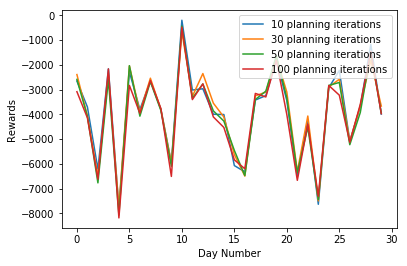

In [57]:
plt.figure()
plt.plot(rewards_plan_10, label = '10 planning iterations')
plt.plot(rewards_plan_30, label = "30 planning iterations")
plt.plot(rewards_plan_50, label = "50 planning iterations")
plt.plot(rewards_plan_100, label = "100 planning iterations")
plt.legend()
plt.xlabel("Day Number")
plt.ylabel("Rewards")


In [59]:
print(sum(rewards_plan_10))
print(sum(rewards_plan_30))    ## here, in 30 the planning model was allowed to train, and it 
print(sum(rewards_plan_50)) ## has the lowest overall rewards 
print(sum(rewards_plan_100))

-117021.11855134189
-116192.64809836443
-119356.09972273273
-122087.17951700819


In [114]:
plt.figure()
plt.plot(reward_planning_50[1200:], label = "reward when planning model trains")
plt.show()

<Figure size 432x288 with 1 Axes>


## Planning model trains

In [95]:
rewards_plan_10_train,_,_,_,_, planning_rewards_10 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 10,
         train_planning_model_with_new_data = True,   
         )

rewards_plan_30_train, _,_,_,_, planning_rewards_30 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 30,
         train_planning_model_with_new_data = True,   
         )

rewards_plan_50_train,_,_,_,_, planning_rewards_50 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 50,
         train_planning_model_with_new_data = True,   
         )

rewards_plan_100_train,_,_,_,_, planning_rewards_100 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 100,
         train_planning_model_with_new_data = True,   
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(18458200.0, 18735080.0, 113.42548370361328, -0.0)
--------------------
--------------------
 planning step 1
(18365322.0, 18653892.0, 130.5730743408203, -0.04927534982562065)
--------------------
--------------------
 planning step 2
(18426324.0, 18736970.0, 123.01703643798828, -0.09096065908670425)
--------------------
--------------------
 planning step 3
(18337858.0, 18660148.0, 135.24420166015625, -0.14268597960472107)
--------------------
--------------------
 planning step 4
(18430616.0, 18766876.0, 133.48556518554688, -0.18367041647434235)
--------------------
--------------------
 planning step 5
(18211236.0, 18558998.0, 133.1405487060547, -0.219

(59430580.0, 60055296.0, 266.78839111328125, -2.878559112548828)
--------------------
Saved model to disk
--------------------------------------------------------------------------------
Day: 37
Loaded model from disk
--------------------
 planning step 0
(9357129.0, 9581742.0, 248.17434692382812, -2.7679924964904785)
--------------------
--------------------
 planning step 1
(45596584.0, 46153336.0, 253.9574737548828, -2.745779514312744)
--------------------
--------------------
 planning step 2
(22622652.0, 23140074.0, 283.71246337890625, -2.7769722938537598)
--------------------
--------------------
 planning step 3
(21659112.0, 22168842.0, 287.916015625, -2.855247735977173)
--------------------
--------------------
 planning step 4
(45252576.0, 45830124.0, 269.4041442871094, -3.0679357051849365)
--------------------
--------------------
 planning step 5
(9367808.0, 9614834.0, 258.724609375, -3.040363073348999)
--------------------
--------------------
 planning step 6
(9318423.0, 9

Saved model to disk
--------------------------------------------------------------------------------
Day: 43
Loaded model from disk
--------------------
 planning step 0
(14697714.0, 15522344.0, 395.000732421875, -5.082108974456787)
--------------------
--------------------
 planning step 1
(21389998.0, 22548392.0, 439.5514221191406, -5.3189473152160645)
--------------------
--------------------
 planning step 2
(12934949.0, 13576654.0, 353.17333984375, -5.18247652053833)
--------------------
--------------------
 planning step 3
(28654300.0, 29768522.0, 383.7851257324219, -5.668691158294678)
--------------------
--------------------
 planning step 4
(14633959.0, 15496157.0, 409.8768310546875, -5.381405830383301)
--------------------
--------------------
 planning step 5
(23533490.0, 24802570.0, 432.9045104980469, -4.775946617126465)
--------------------
--------------------
 planning step 6
(7635410.0, 8230093.5, 375.30621337890625, -5.3682332038879395)
--------------------
----------

Loaded model from disk
--------------------
 planning step 0
(17087376.0, 19122522.0, 613.0106811523438, -7.068931579589844)
--------------------
--------------------
 planning step 1
(11877507.0, 13369999.0, 554.2652587890625, -7.363745212554932)
--------------------
--------------------
 planning step 2
(11678252.0, 13781005.0, 768.431396484375, -8.112955093383789)
--------------------
--------------------
 planning step 3
(11596762.0, 13723308.0, 756.7772216796875, -7.261150360107422)
--------------------
--------------------
 planning step 4
(11762239.0, 13307637.0, 555.7371826171875, -6.8462700843811035)
--------------------
--------------------
 planning step 5
(8010771.0, 9237679.0, 572.2581787109375, -7.582248210906982)
--------------------
--------------------
 planning step 6
(13126297.0, 15093403.0, 687.9058837890625, -7.9793548583984375)
--------------------
--------------------
 planning step 7
(11470755.0, 13707452.0, 799.334228515625, -8.087639808654785)
----------------

(49925432.0, 57255320.0, 1017.8792724609375, -7.034756660461426)
--------------------
--------------------
 planning step 2
(29764404.0, 37089416.0, 1273.64794921875, -7.646001815795898)
--------------------
--------------------
 planning step 3
(5289855.0, 7573492.0, 933.7447509765625, -7.65152645111084)
--------------------
--------------------
 planning step 4
(29585020.0, 37091164.0, 1307.7713623046875, -8.195399284362793)
--------------------
--------------------
 planning step 5
(18660232.0, 24941802.0, 1335.6376953125, -6.573883056640625)
--------------------
--------------------
 planning step 6
(9351427.0, 12473858.0, 951.2926635742188, -7.79524564743042)
--------------------
--------------------
 planning step 7
(5475732.5, 7927204.0, 980.0318603515625, -8.283382415771484)
--------------------
--------------------
 planning step 8
(18821524.0, 24345618.0, 1204.383544921875, -8.255895614624023)
--------------------
--------------------
 planning step 9
(31334302.0, 39631992.0,

Loaded model from disk
--------------------
 planning step 0
(18047258.0, 18394382.0, 268.3472595214844, -0.0)
--------------------
--------------------
 planning step 1
(18028172.0, 18392732.0, 260.47052001953125, -0.06064678728580475)
--------------------
--------------------
 planning step 2
(17876124.0, 18256230.0, 252.7173309326172, -0.11499989777803421)
--------------------
--------------------
 planning step 3
(15020626.0, 15388345.0, 250.4001922607422, -0.1676107496023178)
--------------------
--------------------
 planning step 4
(17903782.0, 18318534.0, 251.94461059570312, -0.22190095484256744)
--------------------
--------------------
 planning step 5
(17774898.0, 18205406.0, 256.29876708984375, -0.2796986699104309)
--------------------
--------------------
 planning step 6
(14310346.0, 14716361.0, 254.89578247070312, -0.32820338010787964)
--------------------
--------------------
 planning step 7
(14784889.0, 15212820.0, 251.619873046875, -0.3703590929508209)
--------------

(14181377.0, 15782217.0, 417.39044189453125, -2.9330530166625977)
--------------------
--------------------
 planning step 5
(37479816.0, 40015936.0, 442.28546142578125, -3.5204081535339355)
--------------------
--------------------
 planning step 6
(37409708.0, 39987740.0, 437.700927734375, -3.405898332595825)
--------------------
--------------------
 planning step 7
(16571411.0, 18833536.0, 532.8529052734375, -3.892970561981201)
--------------------
--------------------
 planning step 8
(16092714.0, 17961686.0, 454.17486572265625, -3.3762104511260986)
--------------------
--------------------
 planning step 9
(12286481.0, 13969538.0, 449.4085998535156, -3.187953472137451)
--------------------
--------------------
 planning step 10
(16467657.0, 18842942.0, 553.0148315429688, -4.1386895179748535)
--------------------
--------------------
 planning step 11
(17079324.0, 19542094.0, 554.4749755859375, -4.114813804626465)
--------------------
--------------------
 planning step 12
(170446

(10763421.0, 18530192.0, 1278.2523193359375, -4.060113906860352)
--------------------
--------------------
 planning step 10
(10725889.0, 18610900.0, 1277.9820556640625, -3.487443685531616)
--------------------
--------------------
 planning step 11
(29962430.0, 39640132.0, 1042.787109375, -3.5926575660705566)
--------------------
--------------------
 planning step 12
(10805820.0, 18983590.0, 1329.444580078125, -4.19815731048584)
--------------------
--------------------
 planning step 13
(8722673.0, 14558456.0, 1101.6092529296875, -4.215208053588867)
--------------------
--------------------
 planning step 14
(29638694.0, 39731520.0, 1094.437744140625, -4.102255344390869)
--------------------
--------------------
 planning step 15
(10210997.0, 18616718.0, 1371.2667236328125, -3.753279685974121)
--------------------
--------------------
 planning step 16
(34163336.0, 45557748.0, 1130.185302734375, -3.7709171772003174)
--------------------
--------------------
 planning step 17
(853961

(2039173.5, 8764304.0, 1858.23681640625, -5.24970006942749)
--------------------
--------------------
 planning step 15
(23089338.0, 43593336.0, 2122.93505859375, -3.62044358253479)
--------------------
--------------------
 planning step 16
(2986490.25, 13681353.0, 2326.12451171875, -3.8857123851776123)
--------------------
--------------------
 planning step 17
(5455791.0, 17313636.0, 2209.114501953125, -5.879034519195557)
--------------------
--------------------
 planning step 18
(4021944.0, 18759252.0, 2764.811767578125, -5.726334095001221)
--------------------
--------------------
 planning step 19
(20693880.0, 41078556.0, 2209.2890625, -4.292026519775391)
--------------------
--------------------
 planning step 20
(18131014.0, 37341592.0, 2214.541259765625, -4.8762006759643555)
--------------------
--------------------
 planning step 21
(1681629.25, 8616789.0, 1968.1854248046875, -4.575690746307373)
--------------------
--------------------
 planning step 22
(5237756.5, 21571638

(2752977.0, 21200566.0, 3546.595458984375, -5.7399678230285645)
--------------------
--------------------
 planning step 20
(2149929.75, 19606276.0, 3574.666748046875, -6.182195663452148)
--------------------
--------------------
 planning step 21
(58128.19921875, 6532607.0, 3360.63037109375, -5.88648796081543)
--------------------
--------------------
 planning step 22
(2030.1888427734375, 7617336.0, 3369.0546875, -4.928060531616211)
--------------------
--------------------
 planning step 23
(266814.375, 9693861.0, 3120.90673828125, -4.194573402404785)
--------------------
--------------------
 planning step 24
(2548290.0, 21256558.0, 3636.42626953125, -5.699484348297119)
--------------------
--------------------
 planning step 25
(1812228.0, 14866042.0, 3019.79296875, -4.142395973205566)
--------------------
--------------------
 planning step 26
(136527.90625, 13551167.0, 3970.11767578125, -4.832045555114746)
--------------------
--------------------
 planning step 27
(2659132.25, 

(1284364.625, 18128268.0, 3952.1005859375, -6.602336406707764)
--------------------
--------------------
 planning step 25
(872607.3125, 16555966.0, 3983.55517578125, -6.18744421005249)
--------------------
--------------------
 planning step 26
(6807490.0, 40375136.0, 4712.01806640625, -5.621354103088379)
--------------------
--------------------
 planning step 27
(146437.390625, 14150903.0, 5220.8701171875, -6.125995635986328)
--------------------
--------------------
 planning step 28
(672894.1875, 7644342.0, 4545.4697265625, -6.668413162231445)
--------------------
--------------------
 planning step 29
(8944723.0, 46419336.0, 4831.06298828125, -6.171018123626709)
--------------------
Saved model to disk
--------------------------------------------------------------------------------
Day: 42
Loaded model from disk
--------------------
 planning step 0
(6758850.0, 40981340.0, 4799.21923828125, -6.669616222381592)
--------------------
--------------------
 planning step 1
(6679115.5,

(1312244.125, 7647390.5, 5419.80615234375, -7.395121097564697)
--------------------
Saved model to disk
--------------------------------------------------------------------------------
Day: 44
Loaded model from disk
--------------------
 planning step 0
(857771.75, 19120768.0, 4821.12451171875, -8.445563316345215)
--------------------
--------------------
 planning step 1
(1002919.125, 18040588.0, 7302.1943359375, -10.426321983337402)
--------------------
--------------------
 planning step 2
(1185276.625, 7861824.5, 5427.1787109375, -6.593017578125)
--------------------
--------------------
 planning step 3
(1125237.125, 26867154.0, 5782.3984375, -8.275927543640137)
--------------------
--------------------
 planning step 4
(776849.4375, 18462674.0, 4833.29443359375, -8.331184387207031)
--------------------
--------------------
 planning step 5
(1200042.125, 27061860.0, 5799.0654296875, -8.209952354431152)
--------------------
--------------------
 planning step 6
(4166039.75, 3423754

(633079.75, 7774859.5, 5985.02392578125, -11.205072402954102)
--------------------
--------------------
 planning step 4
(134794.390625, 18671582.0, 7798.2509765625, -12.254341125488281)
--------------------
--------------------
 planning step 5
(1830887.75, 19212830.0, 5084.72265625, -9.637100219726562)
--------------------
--------------------
 planning step 6
(1960108.0, 26799852.0, 6355.67236328125, -11.489752769470215)
--------------------
--------------------
 planning step 7
(11138743.0, 50442704.0, 6368.109375, -11.495002746582031)
--------------------
--------------------
 planning step 8
(2261653.25, 5996730.5, 6672.3212890625, -9.884604454040527)
--------------------
--------------------
 planning step 9
(5661374.5, 37373240.0, 6298.86572265625, -8.56856632232666)
--------------------
--------------------
 planning step 10
(1835372.75, 18981704.0, 5138.767578125, -10.81525993347168)
--------------------
--------------------
 planning step 11
(1183554.875, 12099461.0, 7742.54

(718207.4375, 8350303.5, 7909.8935546875, -12.491458892822266)
--------------------
--------------------
 planning step 10
(2362148.25, 24023170.0, 7099.03271484375, -12.370269775390625)
--------------------
--------------------
 planning step 11
(176789.859375, 14273801.0, 8877.08984375, -11.580083847045898)
--------------------
--------------------
 planning step 12
(4969899.5, 31622148.0, 7240.2802734375, -11.36228084564209)
--------------------
--------------------
 planning step 13
(5431196.0, 32742112.0, 7245.69970703125, -10.902249336242676)
--------------------
--------------------
 planning step 14
(1410057.625, 21129716.0, 7385.25244140625, -14.629108428955078)
--------------------
--------------------
 planning step 15
(1870598.5, 16885084.0, 5925.9482421875, -10.837589263916016)
--------------------
--------------------
 planning step 16
(47055.9453125, 8404388.0, 6786.060546875, -11.174649238586426)
--------------------
--------------------
 planning step 17
(766811.5, 111

(883980.0625, 2475648.75, 7684.33642578125, -15.036477088928223)
--------------------
--------------------
 planning step 15
(2649683.0, 18527076.0, 8148.33642578125, -14.898469924926758)
--------------------
--------------------
 planning step 16
(2653408.75, 14271487.0, 6536.77099609375, -11.645045280456543)
--------------------
--------------------
 planning step 17
(1140534.25, 4936600.5, 10044.6982421875, -16.06589126586914)
--------------------
--------------------
 planning step 18
(3174243.25, 2473588.75, 10323.6591796875, -14.712965965270996)
--------------------
--------------------
 planning step 19
(4575.18798828125, 5292624.0, 7476.0634765625, -13.53349781036377)
--------------------
--------------------
 planning step 20
(3213.638671875, 5238591.0, 7476.72900390625, -13.299047470092773)
--------------------
--------------------
 planning step 21
(516078.78125, 10859339.0, 8195.908203125, -13.072755813598633)
--------------------
--------------------
 planning step 22
(171

(10164415.0, 23141160.0, 8710.3974609375, -17.195186614990234)
--------------------
--------------------
 planning step 20
(824568.625, 6452592.0, 8743.546875, -16.660133361816406)
--------------------
--------------------
 planning step 21
(10074183.0, 22939942.0, 8774.115234375, -17.098190307617188)
--------------------
--------------------
 planning step 22
(2039589.875, 7700167.0, 7361.12548828125, -17.010068893432617)
--------------------
--------------------
 planning step 23
(3145229.5, 11625949.0, 8607.00390625, -15.238112449645996)
--------------------
--------------------
 planning step 24
(1038181.875, 561718.0625, 9661.083984375, -14.762803077697754)
--------------------
--------------------
 planning step 25
(1551975.75, 296780.21875, 9710.4677734375, -16.277650833129883)
--------------------
--------------------
 planning step 26
(1240874.125, 843174.125, 10978.7734375, -17.118755340576172)
--------------------
--------------------
 planning step 27
(3563832.25, 12364842.

(38287.86328125, 459358.3125, 8921.2236328125, -16.00696563720703)
--------------------
--------------------
 planning step 25
(1621921.625, 4978548.5, 9190.4912109375, -15.473467826843262)
--------------------
--------------------
 planning step 26
(661758.4375, 71707.3203125, 10718.267578125, -18.49225425720215)
--------------------
--------------------
 planning step 27
(653370.6875, 75429.6171875, 10742.7919921875, -17.720218658447266)
--------------------
--------------------
 planning step 28
(5952227.5, 1345328.125, 12484.62890625, -16.61325454711914)
--------------------
--------------------
 planning step 29
(1267047.0, 2802.172119140625, 10760.4716796875, -15.996438980102539)
--------------------
Saved model to disk
--------------------------------------------------------------------------------
Day: 55
Loaded model from disk
--------------------
 planning step 0
(433947.6875, 2740040.0, 9910.3017578125, -16.9395751953125)
--------------------
--------------------
 planning s

(117548.53125, 127163.9765625, 9707.744140625, -16.49359893798828)
--------------------
Saved model to disk
--------------------------------------------------------------------------------
Day: 57
Loaded model from disk
--------------------
 planning step 0
(4247258.0, 1203591.125, 13214.8701171875, -20.011425018310547)
--------------------
--------------------
 planning step 1
(40493.30859375, 1178132.125, 12723.0927734375, -17.632781982421875)
--------------------
--------------------
 planning step 2
(88637.0390625, 89392.828125, 9692.2724609375, -20.00594139099121)
--------------------
--------------------
 planning step 3
(3350826.75, 1096497.375, 13282.7705078125, -20.27420425415039)
--------------------
--------------------
 planning step 4
(2372087.25, 4123679.75, 8663.8828125, -18.436691284179688)
--------------------
--------------------
 planning step 5
(251229.046875, 1157070.0, 10753.970703125, -19.246257781982422)
--------------------
--------------------
 planning step 6

(8508553.0, 6306313.0, 14567.4736328125, -20.389455795288086)
--------------------
--------------------
 planning step 4
(2530150.0, 3388763.25, 9620.8583984375, -18.257585525512695)
--------------------
--------------------
 planning step 5
(4692812.5, 5981287.0, 9231.3896484375, -18.38681983947754)
--------------------
--------------------
 planning step 6
(6520118.0, 4874410.0, 12012.4423828125, -15.944778442382812)
--------------------
--------------------
 planning step 7
(988797.1875, 1843731.75, 11739.337890625, -17.638322830200195)
--------------------
--------------------
 planning step 8
(3484752.0, 4607135.0, 10285.623046875, -14.43154525756836)
--------------------
--------------------
 planning step 9
(5459.2470703125, 14586.9306640625, 9981.529296875, -21.288938522338867)
--------------------
--------------------
 planning step 10
(2756118.75, 1513524.625, 13992.552734375, -20.938112258911133)
--------------------
--------------------
 planning step 11
(14135.4453125, 452

(16785938.0, 18340730.0, 107.74821472167969, -0.23177675902843475)
--------------------
--------------------
 planning step 7
(16741663.0, 18277244.0, 117.44850158691406, -0.28675565123558044)
--------------------
--------------------
 planning step 8
(16659920.0, 18172956.0, 109.86927795410156, -0.30249735713005066)
--------------------
--------------------
 planning step 9
(16766828.0, 18267718.0, 113.41720581054688, -0.3432311713695526)
--------------------
--------------------
 planning step 10
(16813108.0, 18294750.0, 119.2198486328125, -0.3915034234523773)
--------------------
--------------------
 planning step 11
(16716018.0, 18184440.0, 120.12885284423828, -0.4275127947330475)
--------------------
--------------------
 planning step 12
(16704116.0, 18161730.0, 133.98013305664062, -0.5074995160102844)
--------------------
--------------------
 planning step 13
(16604582.0, 18044488.0, 125.21532440185547, -0.5080506205558777)
--------------------
--------------------
 planning s

(16662590.0, 16908496.0, 148.53997802734375, -2.9980227947235107)
--------------------
--------------------
 planning step 22
(16834320.0, 17065290.0, 147.98951721191406, -3.0254251956939697)
--------------------
--------------------
 planning step 23
(16722896.0, 16941130.0, 135.87734985351562, -2.8049845695495605)
--------------------
--------------------
 planning step 24
(16708331.0, 16911322.0, 139.46664428710938, -2.9189436435699463)
--------------------
--------------------
 planning step 25
(17686784.0, 18067066.0, 142.45388793945312, -3.0394692420959473)
--------------------
--------------------
 planning step 26
(16710115.0, 16887966.0, 146.3916473388672, -3.1445279121398926)
--------------------
--------------------
 planning step 27
(16817424.0, 16980142.0, 138.9248046875, -3.0149083137512207)
--------------------
--------------------
 planning step 28
(16588454.0, 16737885.0, 130.00010681152344, -2.8465559482574463)
--------------------
--------------------
 planning step 

(18985372.0, 18985376.0, 142.24093627929688, -5.130337238311768)
--------------------
--------------------
 planning step 37
(40031276.0, 40031276.0, 150.29534912109375, -5.4818010330200195)
--------------------
--------------------
 planning step 38
(17633376.0, 17633380.0, 141.7672119140625, -5.183192253112793)
--------------------
--------------------
 planning step 39
(37227532.0, 37227540.0, 127.98892974853516, -4.671151638031006)
--------------------
--------------------
 planning step 40
(16832060.0, 16832064.0, 128.35464477539062, -4.717239856719971)
--------------------
--------------------
 planning step 41
(37682724.0, 37682728.0, 154.15411376953125, -5.787676811218262)
--------------------
--------------------
 planning step 42
(16758431.0, 16758435.0, 156.55950927734375, -5.923591613769531)
--------------------
--------------------
 planning step 43
(39780744.0, 39780748.0, 140.9070281982422, -5.32403039932251)
--------------------
--------------------
 planning step 44
(3

(8321496.5, 8321501.0, 138.6124267578125, -7.186394214630127)
--------------------
--------------------
 planning step 1
(8240694.0, 8240698.0, 130.5924835205078, -6.768316268920898)
--------------------
--------------------
 planning step 2
(18020568.0, 18020572.0, 131.94277954101562, -6.876803398132324)
--------------------
--------------------
 planning step 3
(40220164.0, 40220176.0, 140.9324493408203, -7.420830249786377)
--------------------
--------------------
 planning step 4
(18116262.0, 18116266.0, 151.99649047851562, -8.088115692138672)
--------------------
--------------------
 planning step 5
(16853780.0, 16853788.0, 159.84494018554688, -8.576387405395508)
--------------------
--------------------
 planning step 6
(8536592.0, 8536596.0, 144.3525848388672, -7.720764636993408)
--------------------
--------------------
 planning step 7
(18529242.0, 18529246.0, 138.39698791503906, -7.410215854644775)
--------------------
--------------------
 planning step 8
(7672052.0, 767205

(8330860.5, 8330864.5, 146.66015625, -9.893756866455078)
--------------------
--------------------
 planning step 17
(17901374.0, 17901382.0, 160.4624786376953, -10.936567306518555)
--------------------
--------------------
 planning step 18
(17826982.0, 17826986.0, 144.21397399902344, -9.781529426574707)
--------------------
--------------------
 planning step 19
(12862548.0, 12862553.0, 157.650634765625, -10.803877830505371)
--------------------
--------------------
 planning step 20
(15460278.0, 15460284.0, 162.57301330566406, -11.20415210723877)
--------------------
--------------------
 planning step 21
(59043764.0, 59043772.0, 143.8939971923828, -9.857612609863281)
--------------------
--------------------
 planning step 22
(48547200.0, 48547212.0, 158.6471405029297, -10.988277435302734)
--------------------
--------------------
 planning step 23
(40384752.0, 40384764.0, 146.09559631347656, -10.088635444641113)
--------------------
--------------------
 planning step 24
(17904150

(13004215.0, 13004222.0, 150.05099487304688, -12.337373733520508)
--------------------
--------------------
 planning step 32
(46441976.0, 46441988.0, 165.90878295898438, -13.782059669494629)
--------------------
--------------------
 planning step 33
(8438848.0, 8438852.0, 145.2828369140625, -11.977229118347168)
--------------------
--------------------
 planning step 34
(59350360.0, 59350376.0, 133.3474884033203, -10.94042682647705)
--------------------
--------------------
 planning step 35
(59940252.0, 59940264.0, 162.00515747070312, -13.541279792785645)
--------------------
--------------------
 planning step 36
(37713800.0, 37713812.0, 147.2145538330078, -12.245734214782715)
--------------------
--------------------
 planning step 37
(57393696.0, 57393712.0, 142.8096160888672, -11.8802490234375)
--------------------
--------------------
 planning step 38
(13339551.0, 13339558.0, 142.37484741210938, -11.871706008911133)
--------------------
--------------------
 planning step 39
(

(19915898.0, 19915906.0, 155.36114501953125, -15.019255638122559)
--------------------
--------------------
 planning step 47
(8276648.5, 8276654.0, 148.1787872314453, -14.301881790161133)
--------------------
--------------------
 planning step 48
(59837108.0, 59837120.0, 163.80699157714844, -15.970881462097168)
--------------------
--------------------
 planning step 49
(40461476.0, 40461488.0, 163.22659301757812, -15.945345878601074)
--------------------
Saved model to disk
--------------------------------------------------------------------------------
Day: 39
Loaded model from disk
--------------------
 planning step 0
(22435232.0, 22435242.0, 161.26498413085938, -15.774320602416992)
--------------------
--------------------
 planning step 1
(13390482.0, 13390489.0, 167.26914978027344, -16.442668914794922)
--------------------
--------------------
 planning step 2
(8160552.0, 8160557.5, 160.11447143554688, -15.722957611083984)
--------------------
--------------------
 planning st

(8558036.0, 8558042.0, 171.43038940429688, -19.083969116210938)
--------------------
--------------------
 planning step 11
(7993001.5, 7993007.0, 156.18072509765625, -17.2960205078125)
--------------------
--------------------
 planning step 12
(49447328.0, 49447340.0, 161.3524932861328, -17.9487361907959)
--------------------
--------------------
 planning step 13
(18469266.0, 18469274.0, 155.28407287597656, -17.25383758544922)
--------------------
--------------------
 planning step 14
(15543670.0, 15543678.0, 148.30494689941406, -16.446395874023438)
--------------------
--------------------
 planning step 15
(27568996.0, 27569006.0, 169.2733612060547, -19.004613876342773)
--------------------
--------------------
 planning step 16
(14892450.0, 14892458.0, 167.09158325195312, -18.776439666748047)
--------------------
--------------------
 planning step 17
(18599820.0, 18599830.0, 172.74203491210938, -19.495119094848633)
--------------------
--------------------
 planning step 18
(82

(22486976.0, 22486986.0, 166.0329132080078, -20.656465530395508)
--------------------
--------------------
 planning step 26
(39211912.0, 39211928.0, 156.17495727539062, -19.36637306213379)
--------------------
--------------------
 planning step 27
(13272527.0, 13272534.0, 175.67478942871094, -22.017807006835938)
--------------------
--------------------
 planning step 28
(6031993.5, 6031999.5, 161.92604064941406, -20.20182228088379)
--------------------
--------------------
 planning step 29
(7928515.5, 7928522.5, 161.5737762451172, -20.18621826171875)
--------------------
--------------------
 planning step 30
(13499977.0, 13499986.0, 153.13577270507812, -19.0783634185791)
--------------------
--------------------
 planning step 31
(7026651.5, 7026658.0, 165.92672729492188, -20.83830451965332)
--------------------
--------------------
 planning step 32
(49807244.0, 49807260.0, 161.34274291992188, -20.249731063842773)
--------------------
--------------------
 planning step 33
(47991

(13524663.0, 13524672.0, 177.13088989257812, -24.42323112487793)
--------------------
--------------------
 planning step 41
(7080227.0, 7080233.5, 178.8498077392578, -24.713428497314453)
--------------------
--------------------
 planning step 42
(13967492.0, 13967501.0, 165.640869140625, -22.788576126098633)
--------------------
--------------------
 planning step 43
(27232702.0, 27232712.0, 175.25282287597656, -24.2501163482666)
--------------------
--------------------
 planning step 44
(18149240.0, 18149248.0, 180.490234375, -25.064552307128906)
--------------------
--------------------
 planning step 45
(14798410.0, 14798417.0, 176.497314453125, -24.50521469116211)
--------------------
--------------------
 planning step 46
(8463535.0, 8463541.0, 175.42825317382812, -24.380666732788086)
--------------------
--------------------
 planning step 47
(6092815.0, 6092819.5, 181.50267028808594, -25.323701858520508)
--------------------
--------------------
 planning step 48
(12952631.0,

(12965123.0, 12965132.0, 182.312255859375, -27.40781021118164)
--------------------
--------------------
 planning step 5
(8436107.0, 8436113.0, 177.02024841308594, -26.586849212646484)
--------------------
--------------------
 planning step 6
(6300985.0, 6300990.0, 171.49154663085938, -25.72552490234375)
--------------------
--------------------
 planning step 7
(16065853.0, 16065861.0, 177.26634216308594, -26.69162940979004)
--------------------
--------------------
 planning step 8
(27187360.0, 27187370.0, 168.07186889648438, -25.23396110534668)
--------------------
--------------------
 planning step 9
(13520015.0, 13520022.0, 162.8211212158203, -24.412425994873047)
--------------------
--------------------
 planning step 10
(46801484.0, 46801500.0, 174.72357177734375, -26.375507354736328)
--------------------
--------------------
 planning step 11
(12977683.0, 12977691.0, 163.30369567871094, -24.549449920654297)
--------------------
--------------------
 planning step 12
(1281701

(13110444.0, 13110451.0, 145.2073974609375, -23.06926727294922)
--------------------
--------------------
 planning step 20
(18197976.0, 18197990.0, 161.6360626220703, -25.954498291015625)
--------------------
--------------------
 planning step 21
(39544452.0, 39544464.0, 170.1536865234375, -27.46621322631836)
--------------------
--------------------
 planning step 22
(16369762.0, 16369772.0, 167.34097290039062, -27.003389358520508)
--------------------
--------------------
 planning step 23
(17427702.0, 17427710.0, 183.85462951660156, -29.916305541992188)
--------------------
--------------------
 planning step 24
(12042245.0, 12042254.0, 174.09402465820312, -28.239892959594727)
--------------------
--------------------
 planning step 25
(15520918.0, 15520928.0, 175.15928649902344, -28.455472946166992)
--------------------
--------------------
 planning step 26
(17195244.0, 17195252.0, 179.2028045654297, -29.193527221679688)
--------------------
--------------------
 planning step 2

(13189305.0, 13189314.0, 171.0133056640625, -29.348878860473633)
--------------------
--------------------
 planning step 35
(17471760.0, 17471768.0, 187.68795776367188, -32.473724365234375)
--------------------
--------------------
 planning step 36
(7089105.0, 7089111.5, 167.8263397216797, -28.811052322387695)
--------------------
--------------------
 planning step 37
(13580407.0, 13580416.0, 191.34539794921875, -33.215240478515625)
--------------------
--------------------
 planning step 38
(6721048.5, 6721055.0, 169.62139892578125, -29.199302673339844)
--------------------
--------------------
 planning step 39
(21567506.0, 21567516.0, 173.94024658203125, -30.03191566467285)
--------------------
--------------------
 planning step 40
(38120472.0, 38120488.0, 173.23519897460938, -29.928268432617188)
--------------------
--------------------
 planning step 41
(12949107.0, 12949116.0, 183.00347900390625, -31.781103134155273)
--------------------
--------------------
 planning step 42

(8507257.0, 8507264.0, 172.81858825683594, -31.421215057373047)
--------------------
Saved model to disk
--------------------------------------------------------------------------------
Day: 48
Loaded model from disk
--------------------
 planning step 0
(21673576.0, 21673584.0, 189.4209442138672, -34.715850830078125)
--------------------
--------------------
 planning step 1
(27779458.0, 27779468.0, 158.4991912841797, -28.649478912353516)
--------------------
--------------------
 planning step 2
(23940952.0, 23940966.0, 168.64846801757812, -30.67437744140625)
--------------------
--------------------
 planning step 3
(27709346.0, 27709356.0, 182.27264404296875, -33.3885612487793)
--------------------
--------------------
 planning step 4
(12940123.0, 12940132.0, 193.3645477294922, -35.60703659057617)
--------------------
--------------------
 planning step 5
(46978676.0, 46978688.0, 168.8824005126953, -30.79479217529297)
--------------------
--------------------
 planning step 6
(854

(26907528.0, 26907538.0, 184.8986053466797, -35.52826690673828)
--------------------
--------------------
 planning step 14
(18335762.0, 18335774.0, 163.4892120361328, -31.11640167236328)
--------------------
--------------------
 planning step 15
(13647921.0, 13647930.0, 194.81427001953125, -37.638206481933594)
--------------------
--------------------
 planning step 16
(20117310.0, 20117324.0, 174.0824737548828, -33.36189270019531)
--------------------
--------------------
 planning step 17
(28089906.0, 28089918.0, 180.3018035888672, -34.678977966308594)
--------------------
--------------------
 planning step 18
(6172674.5, 6172681.0, 177.45208740234375, -34.11221694946289)
--------------------
--------------------
 planning step 19
(12879636.0, 12879645.0, 187.635986328125, -36.25691223144531)
--------------------
--------------------
 planning step 20
(40764360.0, 40764372.0, 171.52774047851562, -32.92924499511719)
--------------------
--------------------
 planning step 21
(18483

(6147230.0, 6147236.0, 194.2217559814453, -39.2761344909668)
--------------------
--------------------
 planning step 30
(17421016.0, 17421028.0, 202.35025024414062, -41.073028564453125)
--------------------
--------------------
 planning step 31
(28136456.0, 28136466.0, 183.62730407714844, -37.02350997924805)
--------------------
--------------------
 planning step 32
(8329503.5, 8329512.0, 192.20809936523438, -38.920108795166016)
--------------------
--------------------
 planning step 33
(6935381.5, 6935389.0, 182.39402770996094, -36.80656433105469)
--------------------
--------------------
 planning step 34
(6823637.0, 6823644.5, 171.5331573486328, -34.4612922668457)
--------------------
--------------------
 planning step 35
(6012069.5, 6012076.5, 200.04083251953125, -40.713260650634766)
--------------------
--------------------
 planning step 36
(8623540.0, 8623548.0, 173.6448211669922, -34.970890045166016)
--------------------
--------------------
 planning step 37
(6174235.0, 6

(7075426.0, 7075434.0, 205.03785705566406, -43.5102424621582)
--------------------
--------------------
 planning step 46
(13203752.0, 13203763.0, 192.32203674316406, -40.6409912109375)
--------------------
--------------------
 planning step 47
(24963924.0, 24963938.0, 201.48399353027344, -42.7558479309082)
--------------------
--------------------
 planning step 48
(12350646.0, 12350655.0, 184.13400268554688, -38.825130462646484)
--------------------
--------------------
 planning step 49
(9695247.0, 9695255.0, 187.0839385986328, -39.52338790893555)
--------------------
Saved model to disk
--------------------------------------------------------------------------------
Day: 52
Loaded model from disk
--------------------
 planning step 0
(17281226.0, 17281238.0, 195.0023193359375, -41.35749816894531)
--------------------
--------------------
 planning step 1
(21723510.0, 21723524.0, 191.60775756835938, -40.60794448852539)
--------------------
--------------------
 planning step 2
(145

(13361292.0, 13361301.0, 191.32801818847656, -42.02364730834961)
--------------------
--------------------
 planning step 11
(17119552.0, 17119564.0, 205.33543395996094, -45.3740119934082)
--------------------
--------------------
 planning step 12
(13079358.0, 13079367.0, 194.5366668701172, -42.835208892822266)
--------------------
--------------------
 planning step 13
(6289247.0, 6289254.5, 176.96945190429688, -38.68421936035156)
--------------------
--------------------
 planning step 14
(52759796.0, 52759816.0, 200.9864501953125, -44.419403076171875)
--------------------
--------------------
 planning step 15
(13308850.0, 13308859.0, 173.5910186767578, -37.92488098144531)
--------------------
--------------------
 planning step 16
(24469596.0, 24469610.0, 184.4179229736328, -40.52500915527344)
--------------------
--------------------
 planning step 17
(7489430.5, 7489437.0, 206.02175903320312, -45.69619369506836)
--------------------
--------------------
 planning step 18
(687144

(17526218.0, 17526226.0, 204.91909790039062, -46.9483642578125)
--------------------
--------------------
 planning step 27
(6107448.0, 6107455.5, 212.51695251464844, -48.84828186035156)
--------------------
--------------------
 planning step 28
(9605003.0, 9605010.0, 205.94454956054688, -47.252384185791016)
--------------------
--------------------
 planning step 29
(17544604.0, 17544616.0, 215.8104705810547, -49.71500778198242)
--------------------
--------------------
 planning step 30
(18584764.0, 18584776.0, 200.28640747070312, -45.90558624267578)
--------------------
--------------------
 planning step 31
(47385632.0, 47385652.0, 205.8382568359375, -47.303489685058594)
--------------------
--------------------
 planning step 32
(47370392.0, 47370412.0, 210.4290771484375, -48.465187072753906)
--------------------
--------------------
 planning step 33
(8197824.5, 8197833.0, 196.82449340820312, -45.1236572265625)
--------------------
--------------------
 planning step 34
(2082866

(23436614.0, 23436628.0, 219.83567810058594, -52.421112060546875)
--------------------
--------------------
 planning step 43
(39688776.0, 39688796.0, 217.7424774169922, -51.912025451660156)
--------------------
--------------------
 planning step 44
(18361414.0, 18361422.0, 200.36427307128906, -47.48974609375)
--------------------
--------------------
 planning step 45
(23003762.0, 23003776.0, 212.87428283691406, -50.71755599975586)
--------------------
--------------------
 planning step 46
(8721885.0, 8721893.0, 214.5760498046875, -51.17912673950195)
--------------------
--------------------
 planning step 47
(12046929.0, 12046939.0, 218.3540496826172, -52.173519134521484)
--------------------
--------------------
 planning step 48
(8618837.0, 8618845.0, 207.24038696289062, -49.34895324707031)
--------------------
--------------------
 planning step 49
(12168046.0, 12168055.0, 182.88140869140625, -43.12178421020508)
--------------------
Saved model to disk
--------------------------

(6939188.0, 6939194.5, 200.8699951171875, -48.98638916015625)
--------------------
--------------------
 planning step 7
(13140163.0, 13140172.0, 196.92010498046875, -47.96552276611328)
--------------------
--------------------
 planning step 8
(7162816.0, 7162823.5, 222.14488220214844, -54.64517593383789)
--------------------
--------------------
 planning step 9
(18684488.0, 18684496.0, 209.10275268554688, -51.22480773925781)
--------------------
--------------------
 planning step 10
(28421680.0, 28421696.0, 216.41310119628906, -53.1789436340332)
--------------------
--------------------
 planning step 11
(27891262.0, 27891276.0, 198.25672912597656, -48.40291213989258)
--------------------
--------------------
 planning step 12
(47296388.0, 47296408.0, 220.34910583496094, -54.266963958740234)
--------------------
--------------------
 planning step 13
(18808666.0, 18808680.0, 203.93289184570312, -49.94743728637695)
--------------------
--------------------
 planning step 14
(4104368

(41741252.0, 41741272.0, 218.8982696533203, -55.236995697021484)
--------------------
--------------------
 planning step 22
(35207252.0, 35207264.0, 209.0717010498047, -52.59009552001953)
--------------------
--------------------
 planning step 23
(31559302.0, 31559318.0, 177.3452911376953, -43.99047088623047)
--------------------
--------------------
 planning step 24
(6423063.0, 6423069.0, 192.92373657226562, -48.24215316772461)
--------------------
--------------------
 planning step 25
(20328786.0, 20328800.0, 198.91064453125, -49.888916015625)
--------------------
--------------------
 planning step 26
(20943628.0, 20943642.0, 176.26878356933594, -43.74846649169922)
--------------------
--------------------
 planning step 27
(38250896.0, 38250908.0, 173.79039001464844, -43.090484619140625)
--------------------
--------------------
 planning step 28
(20312182.0, 20312196.0, 220.73162841796875, -55.88732147216797)
--------------------
--------------------
 planning step 29
(3621894

(9504163.0, 9504172.0, 208.19723510742188, -53.627716064453125)
--------------------
--------------------
 planning step 37
(27906152.0, 27906168.0, 205.53123474121094, -52.90441131591797)
--------------------
--------------------
 planning step 38
(9356933.0, 9356940.0, 212.19847106933594, -54.78318786621094)
--------------------
--------------------
 planning step 39
(18335862.0, 18335876.0, 222.2847900390625, -57.6172981262207)
--------------------
--------------------
 planning step 40
(18586792.0, 18586804.0, 210.05023193359375, -54.224273681640625)
--------------------
--------------------
 planning step 41
(6015261.5, 6015269.0, 191.62599182128906, -49.10037612915039)
--------------------
--------------------
 planning step 42
(11369513.0, 11369523.0, 213.2484893798828, -55.1575813293457)
--------------------
--------------------
 planning step 43
(27865784.0, 27865800.0, 200.12991333007812, -51.51231002807617)
--------------------
--------------------
 planning step 44
(3607573

Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(14601765.0, 14323144.0, 234.7225341796875, -0.0)
--------------------
--------------------
 planning step 1
(14558564.0, 14276531.0, 233.20106506347656, -0.05851005017757416)
--------------------
--------------------
 planning step 2
(14588342.0, 14302139.0, 231.51004028320312, -0.1154460534453392)
--------------------
--------------------
 planning step 3
(14600354.0, 14310108.0, 229.5167999267578, -0.1705203801393509)
--------------------
--------------------
 planning step 4
(14569797.0, 14275905.0, 224.45343017578125, -0.22013165056705475)
--------------------
--------------------
 planning step 5
(14590365.0, 14292269.0, 223.43374633789062, -0.27211254835128784)
--------------------
--------------------
 planning step 6

(16220609.0, 15383017.0, 301.867431640625, -3.483159303665161)
--------------------
--------------------
 planning step 65
(16229975.0, 15366607.0, 304.9814147949219, -3.532785415649414)
--------------------
--------------------
 planning step 66
(14427868.0, 13591996.0, 301.3246765136719, -3.4436519145965576)
--------------------
--------------------
 planning step 67
(16226444.0, 15309292.0, 308.74261474609375, -3.5787148475646973)
--------------------
--------------------
 planning step 68
(16236331.0, 15291191.0, 316.0431213378906, -3.7055795192718506)
--------------------
--------------------
 planning step 69
(16230787.0, 15257673.0, 316.9146423339844, -3.7043726444244385)
--------------------
--------------------
 planning step 70
(14438150.0, 13496848.0, 308.6534729003906, -3.507815361022949)
--------------------
--------------------
 planning step 71
(16256876.0, 15225737.0, 321.70013427734375, -3.750340461730957)
--------------------
--------------------
 planning step 72
(16

(16455351.0, 13477910.0, 586.8615112304688, -7.111835479736328)
--------------------
--------------------
 planning step 31
(16462108.0, 13442905.0, 591.0889892578125, -7.112844467163086)
--------------------
--------------------
 planning step 32
(16439517.0, 13381141.0, 583.1101684570312, -6.65188455581665)
--------------------
--------------------
 planning step 33
(16498747.0, 13392837.0, 605.2034301757812, -7.322140693664551)
--------------------
--------------------
 planning step 34
(15068573.0, 12066688.0, 606.6795654296875, -7.210748672485352)
--------------------
--------------------
 planning step 35
(16405528.0, 13224752.0, 609.3204956054688, -7.140676021575928)
--------------------
--------------------
 planning step 36
(14721983.0, 11676758.0, 621.115234375, -7.422501087188721)
--------------------
--------------------
 planning step 37
(14734253.0, 11647459.0, 628.9525146484375, -7.551498889923096)
--------------------
--------------------
 planning step 38
(16512506.0, 

(23273826.0, 14076551.0, 1279.222412109375, -10.882706642150879)
--------------------
--------------------
 planning step 98
(24180942.0, 14666706.0, 1276.68115234375, -10.011277198791504)
--------------------
--------------------
 planning step 99
(17292700.0, 9908184.0, 1216.9849853515625, -10.958327293395996)
--------------------
Saved model to disk
--------------------------------------------------------------------------------
Day: 33
Loaded model from disk
--------------------
 planning step 0
(17311402.0, 9843744.0, 1229.494140625, -11.011327743530273)
--------------------
--------------------
 planning step 1
(24237688.0, 14398414.0, 1323.30224609375, -10.524187088012695)
--------------------
--------------------
 planning step 2
(23345780.0, 13624618.0, 1335.60986328125, -10.478280067443848)
--------------------
--------------------
 planning step 3
(23299722.0, 13484606.0, 1359.427490234375, -11.072261810302734)
--------------------
--------------------
 planning step 4
(1736

(24908142.0, 7592500.5, 2429.90576171875, -13.093878746032715)
--------------------
--------------------
 planning step 63
(16820876.0, 4143362.5, 2268.6103515625, -14.25131893157959)
--------------------
--------------------
 planning step 64
(46521500.0, 25880376.0, 1926.8057861328125, -13.322502136230469)
--------------------
--------------------
 planning step 65
(25041408.0, 7297508.5, 2503.712890625, -13.545961380004883)
--------------------
--------------------
 planning step 66
(18935896.0, 4973980.0, 2323.88037109375, -14.013439178466797)
--------------------
--------------------
 planning step 67
(26094578.0, 7579926.0, 2551.50048828125, -13.605252265930176)
--------------------
--------------------
 planning step 68
(26096188.0, 7446107.0, 2560.723876953125, -12.834063529968262)
--------------------
--------------------
 planning step 69
(17019706.0, 3741137.0, 2387.330078125, -14.073793411254883)
--------------------
--------------------
 planning step 70
(26195588.0, 72302

(50963472.0, 15590560.0, 3376.9091796875, -16.014238357543945)
--------------------
--------------------
 planning step 29
(19667710.0, 342187.59375, 4060.802978515625, -17.674766540527344)
--------------------
--------------------
 planning step 30
(21905942.0, 656331.375, 4082.51708984375, -17.840402603149414)
--------------------
--------------------
 planning step 31
(28359188.0, 1067639.875, 4486.29052734375, -16.17243194580078)
--------------------
--------------------
 planning step 32
(19878906.0, 275082.3125, 4137.7646484375, -17.969091415405273)
--------------------
--------------------
 planning step 33
(13363100.0, 188087.390625, 3435.318603515625, -18.256587982177734)
--------------------
--------------------
 planning step 34
(28676752.0, 958400.875, 4583.74072265625, -16.779277801513672)
--------------------
--------------------
 planning step 35
(22221220.0, 513261.6875, 4220.03173828125, -18.174020767211914)
--------------------
--------------------
 planning step 36
(

(35333260.0, 24061.189453125, 5980.755859375, -20.039670944213867)
--------------------
--------------------
 planning step 95
(58326304.0, 10348263.0, 4592.22607421875, -18.699771881103516)
--------------------
--------------------
 planning step 96
(34454620.0, 1724.3580322265625, 6033.6025390625, -20.177278518676758)
--------------------
--------------------
 planning step 97
(34412352.0, 132.30615234375, 6059.8115234375, -20.19827651977539)
--------------------
--------------------
 planning step 98
(34634304.0, 47.83802795410156, 6080.3310546875, -19.746068954467773)
--------------------
--------------------
 planning step 99
(34649708.0, 175.627197265625, 6104.2275390625, -19.967700958251953)
--------------------
Saved model to disk
--------------------------------------------------------------------------------
Day: 35
Loaded model from disk
--------------------
 planning step 0
(35889600.0, 3361.62158203125, 6118.00537109375, -19.61719512939453)
--------------------
-----------

(67076932.0, 7265657.0, 5654.4072265625, -18.913433074951172)
--------------------
--------------------
 planning step 60
(67636120.0, 7371800.5, 5691.6103515625, -19.21510124206543)
--------------------
--------------------
 planning step 61
(42951652.0, 521091.53125, 7473.2265625, -19.921344757080078)
--------------------
--------------------
 planning step 62
(44242516.0, 441521.96875, 7472.62109375, -18.956544876098633)
--------------------
--------------------
 planning step 63
(36054772.0, 380819.75, 6808.32666015625, -20.76130485534668)
--------------------
--------------------
 planning step 64
(69767144.0, 7647844.5, 5747.267578125, -19.72052764892578)
--------------------
--------------------
 planning step 65
(23411994.0, 416816.5, 5682.37158203125, -22.20295524597168)
--------------------
--------------------
 planning step 66
(91586280.0, 11489561.0, 6368.05517578125, -20.980093002319336)
--------------------
--------------------
 planning step 67
(44029204.0, 576477.625, 

(55044040.0, 1416299.875, 8810.2392578125, -24.760059356689453)
--------------------
--------------------
 planning step 27
(114665824.0, 11872695.0, 7420.95703125, -22.49854850769043)
--------------------
--------------------
 planning step 28
(83794336.0, 6543326.5, 6764.24951171875, -24.711734771728516)
--------------------
--------------------
 planning step 29
(55677328.0, 1479784.375, 8876.66015625, -24.540340423583984)
--------------------
--------------------
 planning step 30
(56973248.0, 1378005.5, 8899.634765625, -24.69158363342285)
--------------------
--------------------
 planning step 31
(45692820.0, 1309603.125, 8077.72265625, -24.21128273010254)
--------------------
--------------------
 planning step 32
(45868772.0, 1299121.375, 8091.265625, -24.93113136291504)
--------------------
--------------------
 planning step 33
(49060768.0, 937752.0625, 8122.25, -23.470869064331055)
--------------------
--------------------
 planning step 34
(48832568.0, 821376.6875, 8094.396

(61737260.0, 371603.34375, 8658.7490234375, -25.947614669799805)
--------------------
--------------------
 planning step 95
(42173392.0, 275652.1875, 7205.6640625, -24.83127784729004)
--------------------
--------------------
 planning step 96
(70452400.0, 1006998.5, 9610.0341796875, -25.636255264282227)
--------------------
--------------------
 planning step 97
(62421056.0, 363159.25, 8724.9326171875, -26.897172927856445)
--------------------
--------------------
 planning step 98
(67963584.0, 96087.890625, 8760.33984375, -28.19268035888672)
--------------------
--------------------
 planning step 99
(62865736.0, 339368.8125, 8711.935546875, -27.391592025756836)
--------------------
Saved model to disk
--------------------------------------------------------------------------------
Day: 37
Loaded model from disk
--------------------
 planning step 0
(62919352.0, 337803.875, 8730.9453125, -26.572622299194336)
--------------------
--------------------
 planning step 1
(102019136.0, 84

(86016208.0, 1049784.375, 10507.083984375, -30.7485294342041)
--------------------
--------------------
 planning step 61
(53965676.0, 138338.59375, 7899.92236328125, -30.2979679107666)
--------------------
--------------------
 planning step 62
(119410232.0, 9595402.0, 8037.8701171875, -30.866365432739258)
--------------------
--------------------
 planning step 63
(81527584.0, 141194.671875, 9600.3134765625, -30.95248031616211)
--------------------
--------------------
 planning step 64
(54677324.0, 122232.1796875, 7927.40478515625, -30.663631439208984)
--------------------
--------------------
 planning step 65
(88586040.0, 933454.125, 10562.1572265625, -31.327213287353516)
--------------------
--------------------
 planning step 66
(55084156.0, 111261.3359375, 7940.947265625, -31.082656860351562)
--------------------
--------------------
 planning step 67
(86089200.0, 20065.109375, 9630.9765625, -31.468236923217773)
--------------------
--------------------
 planning step 68
(12187

(180916576.0, 17065274.0, 9505.123046875, -33.76399230957031)
--------------------
--------------------
 planning step 26
(115288640.0, 138596.96875, 11322.388671875, -33.98297882080078)
--------------------
--------------------
 planning step 27
(67476216.0, 16440.298828125, 8528.953125, -33.989830017089844)
--------------------
--------------------
 planning step 28
(181843744.0, 16864450.0, 9564.373046875, -33.991275787353516)
--------------------
--------------------
 planning step 29
(104736832.0, 3465.345703125, 10384.748046875, -33.538360595703125)
--------------------
--------------------
 planning step 30
(116521992.0, 178962.046875, 11432.8779296875, -34.54895782470703)
--------------------
--------------------
 planning step 31
(106527520.0, 902275.5, 11452.9033203125, -33.740596771240234)
--------------------
--------------------
 planning step 32
(105919696.0, 941011.75, 11469.4541015625, -33.37004852294922)
--------------------
--------------------
 planning step 33
(1059

(124783168.0, 70103.421875, 11123.9970703125, -37.283058166503906)
--------------------
--------------------
 planning step 92
(137105232.0, 80917.46875, 12205.208984375, -36.12411880493164)
--------------------
--------------------
 planning step 93
(89218392.0, 100782.6875, 9343.9130859375, -36.93641662597656)
--------------------
--------------------
 planning step 94
(159948192.0, 12079256.0, 9335.8408203125, -37.455989837646484)
--------------------
--------------------
 planning step 95
(89342368.0, 91803.671875, 9367.7041015625, -37.51069641113281)
--------------------
--------------------
 planning step 96
(83039208.0, 5475.85546875, 9223.53125, -36.99785614013672)
--------------------
--------------------
 planning step 97
(118929888.0, 11047.775390625, 11192.0751953125, -36.40955352783203)
--------------------
--------------------
 planning step 98
(162797488.0, 12865049.0, 9389.412109375, -37.32695007324219)
--------------------
--------------------
 planning step 99
(139542

(107151088.0, 30904.541015625, 10749.9306640625, -40.469913482666016)
--------------------
--------------------
 planning step 57
(145626176.0, 3343058.75, 14080.619140625, -40.029598236083984)
--------------------
--------------------
 planning step 58
(135091840.0, 890024.5625, 12753.2705078125, -40.5230712890625)
--------------------
--------------------
 planning step 59
(135358912.0, 871796.0625, 12751.626953125, -39.89562225341797)
--------------------
--------------------
 planning step 60
(98844840.0, 224672.296875, 10598.3056640625, -40.03365707397461)
--------------------
--------------------
 planning step 61
(137671520.0, 626895.875, 12743.3349609375, -39.76715850830078)
--------------------
--------------------
 planning step 62
(162975472.0, 1185548.75, 14072.138671875, -39.58896255493164)
--------------------
--------------------
 planning step 63
(109463192.0, 4183.58837890625, 10747.4453125, -40.239654541015625)
--------------------
--------------------
 planning step 

(185664704.0, 5452977.5, 11517.7890625, -43.59263229370117)
--------------------
--------------------
 planning step 22
(127887160.0, 225440.421875, 11059.4560546875, -43.31562423706055)
--------------------
--------------------
 planning step 23
(169321040.0, 1647016.25, 14488.3115234375, -43.36001205444336)
--------------------
--------------------
 planning step 24
(116477744.0, 4639.02001953125, 10909.115234375, -42.90352249145508)
--------------------
--------------------
 planning step 25
(143018880.0, 4321758.0, 10106.7607421875, -43.63387680053711)
--------------------
--------------------
 planning step 26
(170281776.0, 1581581.375, 14525.4033203125, -43.308502197265625)
--------------------
--------------------
 planning step 27
(117407344.0, 7111.06787109375, 10936.6630859375, -43.18745803833008)
--------------------
--------------------
 planning step 28
(171087680.0, 1595188.75, 14536.4130859375, -42.35774612426758)
--------------------
--------------------
 planning step 

(215024736.0, 1948248.875, 16284.5322265625, -45.3712272644043)
--------------------
--------------------
 planning step 88
(151659376.0, 6946.01806640625, 12458.77734375, -45.854915618896484)
--------------------
--------------------
 planning step 89
(232940832.0, 8899693.0, 12455.87890625, -46.18429183959961)
--------------------
--------------------
 planning step 90
(236965952.0, 9571241.0, 12482.4267578125, -46.641029357910156)
--------------------
--------------------
 planning step 91
(136998240.0, 210542.96875, 12346.4365234375, -46.030418395996094)
--------------------
--------------------
 planning step 92
(313900384.0, 16123464.0, 13846.9794921875, -46.999664306640625)
--------------------
--------------------
 planning step 93
(187822240.0, 986087.8125, 14926.984375, -46.51914596557617)
--------------------
--------------------
 planning step 94
(197111584.0, 5358963.0, 16542.169921875, -46.478511810302734)
--------------------
--------------------
 planning step 95
(16868

(269205536.0, 10765147.0, 13318.326171875, -49.9031982421875)
--------------------
--------------------
 planning step 54
(217260432.0, 789475.625, 15813.6513671875, -48.48398971557617)
--------------------
--------------------
 planning step 55
(180189232.0, 81308.515625, 13375.1318359375, -50.17970275878906)
--------------------
--------------------
 planning step 56
(270266912.0, 10638389.0, 13369.3427734375, -49.872432708740234)
--------------------
--------------------
 planning step 57
(244443824.0, 3530329.0, 13983.6474609375, -48.225563049316406)
--------------------
--------------------
 planning step 58
(161329936.0, 133981.734375, 13249.98828125, -49.3873176574707)
--------------------
--------------------
 planning step 59
(182006864.0, 66075.1015625, 13468.95703125, -49.90232467651367)
--------------------
--------------------
 planning step 60
(219484912.0, 864015.625, 15979.94921875, -50.021785736083984)
--------------------
--------------------
 planning step 61
(352043

(274606592.0, 4735775.0, 14632.9423828125, -52.460296630859375)
--------------------
--------------------
 planning step 20
(209488784.0, 447960.90625, 14044.328125, -52.96804428100586)
--------------------
--------------------
 planning step 21
(210124272.0, 456964.125, 14057.61328125, -52.5395393371582)
--------------------
--------------------
 planning step 22
(258630656.0, 4440058.0, 18430.359375, -53.34069061279297)
--------------------
--------------------
 planning step 23
(186306448.0, 2583.99462890625, 13883.7392578125, -52.71011734008789)
--------------------
--------------------
 planning step 24
(259591952.0, 4362268.5, 18430.548828125, -47.623695373535156)
--------------------
--------------------
 planning step 25
(258302240.0, 4698462.5, 18428.181640625, -52.178916931152344)
--------------------
--------------------
 planning step 26
(212209184.0, 554766.0, 14061.19140625, -52.85386657714844)
--------------------
--------------------
 planning step 27
(289004192.0, 1339

(208469344.0, 1884.35693359375, 14662.2412109375, -55.015625)
--------------------
--------------------
 planning step 87
(305890656.0, 4987161.5, 15496.6201171875, -55.06600570678711)
--------------------
--------------------
 planning step 88
(286446496.0, 5422612.5, 19458.916015625, -55.29528045654297)
--------------------
--------------------
 planning step 89
(320338208.0, 1712279.625, 19450.0234375, -55.95705795288086)
--------------------
--------------------
 planning step 90
(436908480.0, 21760084.0, 16365.916015625, -54.40105056762695)
--------------------
--------------------
 planning step 91
(254032512.0, 7067845.5, 13525.6259765625, -56.576045989990234)
--------------------
--------------------
 planning step 92
(304432352.0, 13329.423828125, 17761.3125, -56.915348052978516)
--------------------
--------------------
 planning step 93
(200640000.0, 5699335.5, 16795.6171875, -56.09156036376953)
--------------------
--------------------
 planning step 94
(338282560.0, 139804

(477693440.0, 21994928.0, 17296.35546875, -58.827720642089844)
--------------------
--------------------
 planning step 53
(339634880.0, 5269230.5, 16380.365234375, -58.64745330810547)
--------------------
--------------------
 planning step 54
(230792880.0, 47127.15234375, 15533.9736328125, -57.816715240478516)
--------------------
--------------------
 planning step 55
(331932544.0, 191073.140625, 18864.69921875, -58.68247604370117)
--------------------
--------------------
 planning step 56
(346493280.0, 1584.879638671875, 18901.416015625, -58.91560745239258)
--------------------
--------------------
 planning step 57
(226019600.0, 6777856.5, 17888.47265625, -59.887786865234375)
--------------------
--------------------
 planning step 58
(272117696.0, 799199.3125, 15849.1005859375, -58.901756286621094)
--------------------
--------------------
 planning step 59
(342482144.0, 4862537.5, 16543.17578125, -57.643646240234375)
--------------------
--------------------
 planning step 60
(

(305612416.0, 35852.53515625, 17483.21484375, -61.18069076538086)
--------------------
--------------------
 planning step 19
(307671744.0, 97563.5, 17475.7109375, -60.734928131103516)
--------------------
--------------------
 planning step 20
(323286944.0, 5358605.5, 15916.796875, -61.807273864746094)
--------------------
--------------------
 planning step 21
(393758528.0, 7826432.5, 22892.71484375, -61.915836334228516)
--------------------
--------------------
 planning step 22
(387821472.0, 6272471.5, 17439.830078125, -61.77337646484375)
--------------------
--------------------
 planning step 23
(362348992.0, 13337889.0, 22885.06640625, -62.01621627807617)
--------------------
--------------------
 planning step 24
(393799776.0, 607398.0, 20878.5859375, -62.80034255981445)
--------------------
--------------------
 planning step 25
(379574720.0, 1347032.25, 20855.203125, -62.86239242553711)
--------------------
--------------------
 planning step 26
(360214304.0, 1936696.25, 2061

(581395392.0, 20460074.0, 19770.71875, -65.93154907226562)
--------------------
--------------------
 planning step 87
(439899104.0, 4954719.5, 23459.5859375, -65.90835571289062)
--------------------
--------------------
 planning step 88
(289847424.0, 8688816.0, 20231.826171875, -65.75967407226562)
--------------------
--------------------
 planning step 89
(449702560.0, 3939077.5, 23447.23046875, -65.00041961669922)
--------------------
--------------------
 planning step 90
(421954432.0, 4606070.5, 18654.24609375, -65.72062683105469)
--------------------
--------------------
 planning step 91
(302498368.0, 5802.4521484375, 17648.203125, -65.5)
--------------------
--------------------
 planning step 92
(303200608.0, 2222.054443359375, 17638.447265625, -65.28866577148438)
--------------------
--------------------
 planning step 93
(586809920.0, 21934806.0, 19719.73046875, -65.42056274414062)
--------------------
--------------------
 planning step 94
(445189472.0, 11450478.0, 17843.3

(336059936.0, 28642.2578125, 18676.259765625, -68.02447509765625)
--------------------
--------------------
 planning step 54
(487927360.0, 60299.0234375, 22593.033203125, -68.25687408447266)
--------------------
--------------------
 planning step 55
(477351072.0, 229091.234375, 22566.494140625, -69.33682250976562)
--------------------
--------------------
 planning step 56
(447727072.0, 3132215.5, 19655.4453125, -69.36360168457031)
--------------------
--------------------
 planning step 57
(392600864.0, 1585263.0, 18814.9296875, -67.76679229736328)
--------------------
--------------------
 planning step 58
(467425664.0, 5130464.0, 19616.287109375, -68.20043182373047)
--------------------
--------------------
 planning step 59
(492228896.0, 3072.233642578125, 22507.458984375, -69.63397216796875)
--------------------
--------------------
 planning step 60
(447282272.0, 743875.9375, 22278.998046875, -69.96426391601562)
--------------------
--------------------
 planning step 61
(49232

(372999584.0, 241182.65625, 19979.14453125, -71.38481903076172)
--------------------
--------------------
 planning step 21
(509888256.0, 2970034.75, 21125.330078125, -71.70425415039062)
--------------------
--------------------
 planning step 22
(489838912.0, 17961820.0, 26563.025390625, -69.43341827392578)
--------------------
--------------------
 planning step 23
(436328384.0, 751184.4375, 20291.951171875, -72.37688446044922)
--------------------
--------------------
 planning step 24
(364456736.0, 12701372.0, 22911.708984375, -68.66070556640625)
--------------------
--------------------
 planning step 25
(537390912.0, 10214928.0, 20247.6015625, -70.0891342163086)
--------------------
--------------------
 planning step 26
(513732672.0, 3103770.0, 21173.69921875, -72.33660888671875)
--------------------
--------------------
 planning step 27
(452392704.0, 9251471.0, 18497.421875, -72.28785705566406)
--------------------
--------------------
 planning step 28
(514699712.0, 3055852.2

(561125696.0, 445193.90625, 24631.6640625, -75.7770004272461)
--------------------
--------------------
 planning step 89
(415082272.0, 872078.75, 21479.59765625, -74.3156509399414)
--------------------
--------------------
 planning step 90
(498331232.0, 7681450.5, 19822.634765625, -74.22134399414062)
--------------------
--------------------
 planning step 91
(609110144.0, 13008110.0, 28560.966796875, -75.20568084716797)
--------------------
--------------------
 planning step 92
(488088576.0, 302401.1875, 21814.904296875, -74.63191223144531)
--------------------
--------------------
 planning step 93
(597620096.0, 8598571.0, 21789.8046875, -75.76008605957031)
--------------------
--------------------
 planning step 94
(565739136.0, 1598856.5, 22789.5625, -73.70481872558594)
--------------------
--------------------
 planning step 95
(549475072.0, 4845372.5, 25917.779296875, -75.75272369384766)
--------------------
--------------------
 planning step 96
(551809280.0, 24178196.0, 2868

(603338368.0, 31077576.0, 30412.96484375, -77.0579833984375)
--------------------
--------------------
 planning step 56
(605944832.0, 6684366.0, 27482.234375, -78.74626922607422)
--------------------
--------------------
 planning step 57
(845879168.0, 13375106.0, 25602.50390625, -78.72108459472656)
--------------------
--------------------
 planning step 58
(622686912.0, 1145903.375, 24163.42578125, -78.591552734375)
--------------------
--------------------
 planning step 59
(625443904.0, 4945255.0, 27434.6328125, -77.97700500488281)
--------------------
--------------------
 planning step 60
(624861248.0, 1277006.0, 24149.75390625, -79.34827423095703)
--------------------
--------------------
 planning step 61
(846915968.0, 13188204.0, 25568.63671875, -78.44999694824219)
--------------------
--------------------
 planning step 62
(611301504.0, 15534976.0, 21065.015625, -79.20744323730469)
--------------------
--------------------
 planning step 63
(613579584.0, 15729838.0, 21087.99

(676276160.0, 1505160.0, 27515.25, -81.39571380615234)
--------------------
--------------------
 planning step 23
(747441856.0, 13271.3095703125, 27735.716796875, -80.34541320800781)
--------------------
--------------------
 planning step 24
(520993184.0, 22760.908203125, 22847.37109375, -80.1592788696289)
--------------------
--------------------
 planning step 25
(510798656.0, 10068722.0, 26058.720703125, -81.48861694335938)
--------------------
--------------------
 planning step 26
(680672192.0, 29462378.0, 20939.935546875, -79.50750732421875)
--------------------
--------------------
 planning step 27
(512435168.0, 9238216.0, 25964.189453125, -82.4398422241211)
--------------------
--------------------
 planning step 28
(679257856.0, 13846422.0, 30072.38671875, -82.77214813232422)
--------------------
--------------------
 planning step 29
(708238016.0, 376437.375, 27406.732421875, -82.32190704345703)
--------------------
--------------------
 planning step 30
(698275584.0, 6236

(765969536.0, 19563102.0, 23465.998046875, -84.62277221679688)
--------------------
--------------------
 planning step 91
(730703808.0, 7617319.5, 24557.3359375, -83.21549987792969)
--------------------
--------------------
 planning step 92
(802677760.0, 5228136.0, 30905.958984375, -83.89662170410156)
--------------------
--------------------
 planning step 93
(722485568.0, 648836.5625, 27972.98828125, -84.07674407958984)
--------------------
--------------------
 planning step 94
(813168512.0, 4697937.5, 30978.0, -85.9697265625)
--------------------
--------------------
 planning step 95
(581464384.0, 709220.5625, 23559.318359375, -83.96528625488281)
--------------------
--------------------
 planning step 96
(729426176.0, 33187636.0, 21541.12890625, -85.91587829589844)
--------------------
--------------------
 planning step 97
(778969280.0, 20581498.0, 23659.48046875, -84.64210510253906)
--------------------
--------------------
 planning step 98
(730624064.0, 32666650.0, 21604.96

(791831488.0, 22230.111328125, 28580.81640625, -86.58167266845703)
--------------------
--------------------
 planning step 58
(1052777792.0, 22144064.0, 27870.125, -88.31636047363281)
--------------------
--------------------
 planning step 59
(817070208.0, 34911896.0, 22976.548828125, -89.3121566772461)
--------------------
--------------------
 planning step 60
(855648192.0, 18361710.0, 25259.01171875, -86.76264190673828)
--------------------
--------------------
 planning step 61
(795836032.0, 85701.421875, 28801.35546875, -88.50121307373047)
--------------------
--------------------
 planning step 62
(721069888.0, 15849761.0, 23172.42578125, -89.41199493408203)
--------------------
--------------------
 planning step 63
(882071680.0, 11663145.0, 33413.6171875, -88.77796936035156)
--------------------
--------------------
 planning step 64
(602929152.0, 288593.5, 25255.638671875, -89.40892791748047)
--------------------
--------------------
 planning step 65
(872226112.0, 13634585.

(643231808.0, 15453559.0, 29594.1015625, -90.6789321899414)
--------------------
--------------------
 planning step 25
(638284800.0, 306001.28125, 25911.453125, -92.1220932006836)
--------------------
--------------------
 planning step 26
(654655808.0, 20194.51953125, 25896.62890625, -88.31279754638672)
--------------------
--------------------
 planning step 27
(953950528.0, 9864225.0, 34328.65625, -91.00706481933594)
--------------------
--------------------
 planning step 28
(855812608.0, 32844316.0, 23825.4921875, -91.14989471435547)
--------------------
--------------------
 planning step 29
(848721664.0, 2506482.75, 31012.22265625, -89.23994445800781)
--------------------
--------------------
 planning step 30
(1145743744.0, 25805884.0, 28948.298828125, -91.96442413330078)
--------------------
--------------------
 planning step 31
(895707840.0, 40917612.0, 23838.015625, -92.52772521972656)
--------------------
--------------------
 planning step 32
(959562176.0, 9567712.0, 343

(989963136.0, 34412432.0, 25906.541015625, -94.56124877929688)
--------------------
--------------------
 planning step 93
(989290112.0, 34051896.0, 25926.818359375, -94.63285064697266)
--------------------
--------------------
 planning step 94
(999014656.0, 4689931.5, 34079.046875, -93.67082214355469)
--------------------
--------------------
 planning step 95
(691217408.0, 7823799.0, 29395.7890625, -94.1584701538086)
--------------------
--------------------
 planning step 96
(954620416.0, 5500.0185546875, 31191.259765625, -96.00747680664062)
--------------------
--------------------
 planning step 97
(912723648.0, 11037929.0, 27200.89453125, -95.57960510253906)
--------------------
--------------------
 planning step 98
(730560064.0, 1870996.5, 25971.46484375, -95.11431121826172)
--------------------
--------------------
 planning step 99
(936872384.0, 6733.61279296875, 30913.859375, -95.15312194824219)
--------------------
Saved model to disk
--------------------------------------

(887079104.0, 4036591.0, 28079.361328125, -94.26150512695312)
--------------------
--------------------
 planning step 60
(778773632.0, 74015.875, 27949.1015625, -97.58968353271484)
--------------------
--------------------
 planning step 61
(941375296.0, 33341016.0, 36767.81640625, -96.67021942138672)
--------------------
--------------------
 planning step 62
(980154048.0, 37413196.0, 25508.861328125, -98.75993347167969)
--------------------
--------------------
 planning step 63
(743382272.0, 16479620.0, 31639.955078125, -97.89340209960938)
--------------------
--------------------
 planning step 64
(977015424.0, 5513911.0, 29226.732421875, -98.65373229980469)
--------------------
--------------------
 planning step 65
(1071453888.0, 13125520.0, 36671.12890625, -97.8468246459961)
--------------------
--------------------
 planning step 66
(945366592.0, 31042266.0, 36635.2890625, -98.44335174560547)
--------------------
--------------------
 planning step 67
(786376192.0, 322173.75, 

(1356957056.0, 29808038.0, 31551.712890625, -101.97911834716797)
--------------------
--------------------
 planning step 26
(1018073216.0, 5662280.5, 29849.736328125, -101.14350128173828)
--------------------
--------------------
 planning step 27
(1037368832.0, 2261.262451171875, 32581.748046875, -102.48174285888672)
--------------------
--------------------
 planning step 28
(1038624448.0, 12431.37890625, 32663.939453125, -102.08397674560547)
--------------------
--------------------
 planning step 29
(1107737600.0, 888748.125, 32662.9765625, -101.52277374267578)
--------------------
--------------------
 planning step 30
(1133496064.0, 26458284.0, 28847.13671875, -101.688720703125)
--------------------
--------------------
 planning step 31
(1040822016.0, 5541371.0, 30231.66796875, -101.85181427001953)
--------------------
--------------------
 planning step 32
(1042499072.0, 5237411.0, 30321.18359375, -101.22003936767578)
--------------------
--------------------
 planning step 33

(1123262080.0, 2829058.25, 32161.134765625, -104.33692932128906)
--------------------
--------------------
 planning step 93
(1189641216.0, 45659452.0, 28058.548828125, -103.25086975097656)
--------------------
--------------------
 planning step 94
(1033829632.0, 2436690.5, 30920.16015625, -104.47183990478516)
--------------------
--------------------
 planning step 95
(864040896.0, 27324306.0, 34948.91015625, -104.25244903564453)
--------------------
--------------------
 planning step 96
(1104235776.0, 49632576.0, 40601.515625, -104.10586547851562)
--------------------
--------------------
 planning step 97
(1240886784.0, 2354138.75, 37087.40234375, -104.08393096923828)
--------------------
--------------------
 planning step 98
(1131956864.0, 2749767.25, 32313.7578125, -104.5600357055664)
--------------------
--------------------
 planning step 99
(1142249088.0, 35557088.0, 28163.357421875, -105.19584655761719)
--------------------
Saved model to disk
------------------------------

(1210816768.0, 5247517.5, 32839.9765625, -107.72789001464844)
--------------------
--------------------
 planning step 59
(1121302528.0, 1535726.0, 32578.404296875, -106.44502258300781)
--------------------
--------------------
 planning step 60
(1208258432.0, 347473.40625, 35682.95703125, -107.56368255615234)
--------------------
--------------------
 planning step 61
(1320015616.0, 949414.25, 37614.41015625, -105.66497039794922)
--------------------
--------------------
 planning step 62
(1119943936.0, 5654103.5, 31421.744140625, -107.71607971191406)
--------------------
--------------------
 planning step 63
(1201712640.0, 12192073.0, 31325.44140625, -106.82030487060547)
--------------------
--------------------
 planning step 64
(1301795712.0, 1653052.625, 37597.01953125, -106.6318359375)
--------------------
--------------------
 planning step 65
(1128192000.0, 1921304.625, 32533.759765625, -106.35987091064453)
--------------------
--------------------
 planning step 66
(112463475

(1314250496.0, 47712856.0, 29683.681640625, -110.33723449707031)
--------------------
--------------------
 planning step 25
(1415884032.0, 1240378.125, 39059.0546875, -110.23112487792969)
--------------------
--------------------
 planning step 26
(1317015680.0, 6809429.0, 34020.83203125, -110.71915435791016)
--------------------
--------------------
 planning step 27
(1244523776.0, 50476252.0, 42720.95703125, -110.3727035522461)
--------------------
--------------------
 planning step 28
(1319852672.0, 7215939.0, 33988.0390625, -112.458740234375)
--------------------
--------------------
 planning step 29
(1472558208.0, 15484471.0, 42651.90625, -111.92806243896484)
--------------------
--------------------
 planning step 30
(1271307776.0, 4356123.5, 33909.02734375, -111.17866516113281)
--------------------
--------------------
 planning step 31
(1429261440.0, 32766792.0, 32413.369140625, -108.17082977294922)
--------------------
--------------------
 planning step 32
(1278707200.0, 4

(1404498304.0, 46979564.0, 30969.416015625, -113.9223861694336)
--------------------
--------------------
 planning step 92
(1073473664.0, 28960142.0, 38493.7421875, -114.42985534667969)
--------------------
--------------------
 planning step 93
(1074407296.0, 29176794.0, 38525.76171875, -113.631103515625)
--------------------
--------------------
 planning step 94
(1784430848.0, 21788620.0, 37742.55859375, -113.0233383178711)
--------------------
--------------------
 planning step 95
(1288561536.0, 704714.3125, 35392.53125, -109.44275665283203)
--------------------
--------------------
 planning step 96
(1358811648.0, 57539216.0, 44789.69140625, -112.32112884521484)
--------------------
--------------------
 planning step 97
(1353114368.0, 2243056.25, 35634.83984375, -114.25945281982422)
--------------------
--------------------
 planning step 98
(1329581440.0, 63227284.0, 44757.828125, -112.52510833740234)
--------------------
--------------------
 planning step 99
(1355862912.0, 2

(1609798656.0, 20876404.0, 45048.16015625, -118.05149841308594)
--------------------
--------------------
 planning step 58
(1574868224.0, 1256071.75, 38914.0390625, -115.7455062866211)
--------------------
--------------------
 planning step 59
(1430671872.0, 5534752.5, 35820.51953125, -115.31439971923828)
--------------------
--------------------
 planning step 60
(1405283072.0, 29973808.0, 32366.44140625, -116.71432495117188)
--------------------
--------------------
 planning step 61
(1628580864.0, 19293026.0, 45103.8359375, -117.69290924072266)
--------------------
--------------------
 planning step 62
(1592023680.0, 80856800.0, 31263.54296875, -117.522216796875)
--------------------
--------------------
 planning step 63
(1593650688.0, 80834040.0, 31284.2265625, -117.14400482177734)
--------------------
--------------------
 planning step 64
(1507554432.0, 61603092.0, 31338.0546875, -118.91389465332031)
--------------------
--------------------
 planning step 65
(1414229504.0, 5

(1651506048.0, 3453369.0, 42729.734375, -119.70687103271484)
--------------------
--------------------
 planning step 24
(1645725568.0, 34167860.0, 46774.48828125, -120.01180267333984)
--------------------
--------------------
 planning step 25
(1488194560.0, 29271904.0, 33532.7890625, -121.5763931274414)
--------------------
--------------------
 planning step 26
(1782110208.0, 15818642.0, 46558.3984375, -120.19644927978516)
--------------------
--------------------
 planning step 27
(1678825728.0, 1337510.375, 40186.890625, -121.5729751586914)
--------------------
--------------------
 planning step 28
(1680742784.0, 1516967.5, 40134.30078125, -121.29810333251953)
--------------------
--------------------
 planning step 29
(1522346368.0, 6099009.0, 36910.265625, -119.02997589111328)
--------------------
--------------------
 planning step 30
(1683469184.0, 1778045.125, 40068.32421875, -122.2414779663086)
--------------------
--------------------
 planning step 31
(1457158528.0, 39983

(1331777024.0, 4660235.5, 34713.296875, -124.97112274169922)
--------------------
--------------------
 planning step 91
(1800330112.0, 64269720.0, 34786.04296875, -122.80328369140625)
--------------------
--------------------
 planning step 92
(1809346560.0, 1321332.25, 41756.78515625, -122.14232635498047)
--------------------
--------------------
 planning step 93
(1774348800.0, 115766296.0, 31735.76171875, -122.6517333984375)
--------------------
--------------------
 planning step 94
(1628310016.0, 1140699.125, 39654.23828125, -121.83961486816406)
--------------------
--------------------
 planning step 95
(1803886080.0, 63201632.0, 34898.1796875, -123.96495819091797)
--------------------
--------------------
 planning step 96
(1722226688.0, 16794980.0, 45970.54296875, -124.6143569946289)
--------------------
--------------------
 planning step 97
(1810867840.0, 851402.6875, 41996.38671875, -122.0120620727539)
--------------------
--------------------
 planning step 98
(1635821696.

(2136855296.0, 29392746.0, 40885.69921875, -128.00357055664062)
--------------------
--------------------
 planning step 57
(1720230656.0, 23971390.0, 36957.0625, -125.02835845947266)
--------------------
--------------------
 planning step 58
(1753618304.0, 71634536.0, 33787.265625, -124.04914855957031)
--------------------
--------------------
 planning step 59
(1881305216.0, 758069.5, 44593.73828125, -125.11528015136719)
--------------------
--------------------
 planning step 60
(1711383808.0, 6067177.0, 44213.421875, -126.36717224121094)
--------------------
--------------------
 planning step 61
(1348735360.0, 4274.912109375, 36983.7265625, -127.37299346923828)
--------------------
--------------------
 planning step 62
(1759407872.0, 67746464.0, 34095.6640625, -126.25188446044922)
--------------------
--------------------
 planning step 63
(2149136640.0, 24017082.0, 41528.6875, -125.80926513671875)
--------------------
--------------------
 planning step 64
(1763222144.0, 658292

(1423497216.0, 127334.671875, 37565.78125, -128.46835327148438)
--------------------
--------------------
 planning step 23
(1733612160.0, 14826049.0, 37893.546875, -126.81485748291016)
--------------------
--------------------
 planning step 24
(1984419200.0, 23524508.0, 49790.48828125, -130.14662170410156)
--------------------
--------------------
 planning step 25
(2298996736.0, 37686312.0, 42000.4453125, -128.85018920898438)
--------------------
--------------------
 planning step 26
(1972124928.0, 85206.9765625, 44504.89453125, -131.21951293945312)
--------------------
--------------------
 planning step 27
(1690562432.0, 4314773.0, 39428.90625, -131.75852966308594)
--------------------
--------------------
 planning step 28
(1485635968.0, 1227361.0, 37830.671875, -130.55706787109375)
--------------------
--------------------
 planning step 29
(1950326016.0, 2198014.75, 43073.890625, -130.32244873046875)
--------------------
--------------------
 planning step 30
(1985580032.0, 10

(1857175296.0, 3422948.0, 41630.32421875, -127.52346801757812)
--------------------
--------------------
 planning step 91
(2002627840.0, 12402255.0, 41630.11328125, -133.1771697998047)
--------------------
--------------------
 planning step 92
(1833017216.0, 81092912.0, 52223.57421875, -134.5010986328125)
--------------------
--------------------
 planning step 93
(1862319360.0, 4246900.0, 41496.5859375, -133.84881591796875)
--------------------
--------------------
 planning step 94
(1835560192.0, 77780136.0, 52056.29296875, -130.52825927734375)
--------------------
--------------------
 planning step 95
(1837382144.0, 75461800.0, 51946.04296875, -130.88775634765625)
--------------------
--------------------
 planning step 96
(1804675200.0, 3385973.75, 41033.11328125, -132.95484924316406)
--------------------
--------------------
 planning step 97
(1992826496.0, 83648176.0, 35897.9375, -133.92294311523438)
--------------------
--------------------
 planning step 98
(2156791040.0, 43

(2109520000.0, 1037899.3125, 47233.90625, -135.85791015625)
--------------------
--------------------
 planning step 57
(2202687488.0, 355062.375, 46737.10546875, -136.3391876220703)
--------------------
--------------------
 planning step 58
(2030435968.0, 19127126.0, 41077.640625, -132.9185791015625)
--------------------
--------------------
 planning step 59
(1883555200.0, 55206060.0, 36384.09765625, -136.92929077148438)
--------------------
--------------------
 planning step 60
(2206970368.0, 327492.40625, 46803.33203125, -135.27224731445312)
--------------------
--------------------
 planning step 61
(1660053504.0, 1861146.125, 39789.70703125, -135.41476440429688)
--------------------
--------------------
 planning step 62
(1948903168.0, 7964257.0, 41732.90625, -134.8230438232422)
--------------------
--------------------
 planning step 63
(1887822336.0, 53903644.0, 36523.59765625, -137.63172912597656)
--------------------
--------------------
 planning step 64
(1923259008.0, 688

(1665502336.0, 28797730.0, 46601.51953125, -139.13165283203125)
--------------------
--------------------
 planning step 23
(2167148032.0, 87215680.0, 37635.10546875, -137.9272003173828)
--------------------
--------------------
 planning step 24
(2129256448.0, 10923567.0, 43263.87890625, -139.23519897460938)
--------------------
--------------------
 planning step 25
(2314996480.0, 115440080.0, 37803.35546875, -142.17027282714844)
--------------------
--------------------
 planning step 26
(2309255936.0, 37060604.0, 54564.125, -137.91781616210938)
--------------------
--------------------
 planning step 27
(1967132800.0, 2104959.0, 43312.16015625, -140.4495849609375)
--------------------
--------------------
 planning step 28
(2063224064.0, 79501952.0, 54765.15625, -139.48150634765625)
--------------------
--------------------
 planning step 29
(1970071552.0, 1905586.125, 43413.98828125, -139.8359832763672)
--------------------
--------------------
 planning step 30
(1677401344.0, 342

(2328433408.0, 16569765.0, 44619.9609375, -142.65008544921875)
--------------------
--------------------
 planning step 90
(2138795136.0, 4712783.0, 44515.40234375, -143.62283325195312)
--------------------
--------------------
 planning step 91
(2111383424.0, 89721520.0, 55857.4296875, -142.33717346191406)
--------------------
--------------------
 planning step 92
(1774559360.0, 29866738.0, 48025.1328125, -142.06182861328125)
--------------------
--------------------
 planning step 93
(2170397440.0, 20686222.0, 42337.91796875, -136.3496551513672)
--------------------
--------------------
 planning step 94
(2141781632.0, 80276632.0, 55548.20703125, -141.3623504638672)
--------------------
--------------------
 planning step 95
(2404427520.0, 2438623.75, 47906.77734375, -141.8040771484375)
--------------------
--------------------
 planning step 96
(2570487552.0, 17431146.0, 55315.765625, -144.5177001953125)
--------------------
--------------------
 planning step 97
(2104801280.0, 431

In [129]:

plt.figure()
plt.plot(planning_rewards_10)
# plt.plot(planning_rewards_30, label = "rewards 30 iterations")
# plt.plot(planning_rewards_50, label = "rewards 50 iterations")
# plt.plot(planning_rewards_100, label = "rewards 100 iterations")
# plt.legend()
plt.show()

<Figure size 432x288 with 1 Axes>


## Trying out planning iterations in a one day scenario

In [94]:
rewards_plan_oneday_10, _, _, _, _, planning_rewards_oneday_10  = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         one_day = True,
         planning_model = True,
         planning_iterations = 10,
         train_planning_model_with_new_data = False,   
         )

rewards_plan_oneday_30, _, _, _, _, planning_rewards_oneday_30  = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         one_day = True,
         planning_model = True,
         planning_iterations = 30,
         train_planning_model_with_new_data = False,   
         )

rewards_plan_oneday_50, _, _, _, _, planning_rewards_oneday_50  = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         one_day = True,
         planning_model = True,
         planning_iterations = 50,
         train_planning_model_with_new_data = False,   
         )

rewards_plan_oneday_100, _, _, _, _, planning_rewards_oneday_100  = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         one_day = True,
         planning_model = True,
         planning_iterations = 100,
         train_planning_model_with_new_data = False,   
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(59354.41796875, 25791.009765625, 119.36029815673828, -0.0)
--------------------
--------------------
 planning step 1
(56127.109375, 24876.263671875, 109.0294189453125, -0.03974607214331627)
--------------------
--------------------
 planning step 2
(51487.26171875, 22966.732421875, 117.05854797363281, -0.08327951282262802)
--------------------
--------------------
 planning step 3
(51117.59765625, 23883.2265625, 114.83958435058594, -0.12176123261451721)
--------------------
--------------------
 planning step 4
(49236.3984375, 24793.673828125, 123.20551300048828, -0.1706317812204361)
--------------------
--------------------
 planning step 5
(47871.5234

(13959.5078125, 10965.7509765625, 157.8963623046875, -1.7897318601608276)
--------------------
--------------------
 planning step 6
(11725.0869140625, 9532.046875, 169.1420440673828, -2.101710319519043)
--------------------
--------------------
 planning step 7
(13249.712890625, 10506.0830078125, 147.1165771484375, -1.8114324808120728)
--------------------
--------------------
 planning step 8
(15153.712890625, 12224.943359375, 155.60414123535156, -1.9713339805603027)
--------------------
--------------------
 planning step 9
(14958.0263671875, 11931.5556640625, 144.4652099609375, -1.7992228269577026)
--------------------
--------------------------------------------------------------------------------
Day: 37
Loaded model from disk
--------------------
 planning step 0
(16446.125, 13022.81640625, 156.83457946777344, -1.854234218597412)
--------------------
--------------------
 planning step 1
(12765.4072265625, 9740.056640625, 148.475830078125, -1.7203737497329712)
------------------

(10088.4970703125, 6863.41943359375, 180.12216186523438, -3.01220440864563)
--------------------
--------------------
 planning step 3
(6760.14599609375, 4623.65966796875, 189.70843505859375, -3.1077613830566406)
--------------------
--------------------
 planning step 4
(12984.0244140625, 9923.734375, 176.6980743408203, -3.3375723361968994)
--------------------
--------------------
 planning step 5
(6682.904296875, 4617.21240234375, 169.427734375, -3.1054728031158447)
--------------------
--------------------
 planning step 6
(7137.09912109375, 4623.3486328125, 166.5821533203125, -2.740046739578247)
--------------------
--------------------
 planning step 7
(12800.517578125, 10384.8310546875, 167.64065551757812, -3.0563390254974365)
--------------------
--------------------
 planning step 8
(11374.80859375, 8535.71484375, 169.49551391601562, -2.72843599319458)
--------------------
--------------------
 planning step 9
(5937.30126953125, 3850.037109375, 182.7086181640625, -3.1519303321

(7716.06591796875, 4741.53662109375, 220.62811279296875, -5.113431453704834)
--------------------
--------------------------------------------------------------------------------
Day: 48
Loaded model from disk
--------------------
 planning step 0
(1811.7015380859375, 265.20831298828125, 267.74285888671875, -5.064062118530273)
--------------------
--------------------
 planning step 1
(3551.483154296875, 861.271484375, 227.06689453125, -3.2071971893310547)
--------------------
--------------------
 planning step 2
(8983.4033203125, 5598.3154296875, 214.6434326171875, -4.609288215637207)
--------------------
--------------------
 planning step 3
(6672.892578125, 3783.593017578125, 199.52601623535156, -3.936154842376709)
--------------------
--------------------
 planning step 4
(4646.27490234375, 2052.46435546875, 250.0529022216797, -5.095561981201172)
--------------------
--------------------
 planning step 5
(4295.89990234375, 1897.866943359375, 246.661376953125, -4.3353681564331055)


(2996.00537109375, 729.7962036132812, 294.378173828125, -6.433446884155273)
--------------------
--------------------
 planning step 6
(1455.7503662109375, 250.81944274902344, 304.3288879394531, -7.058846950531006)
--------------------
--------------------
 planning step 7
(278.0338439941406, 2225.1181640625, 348.30133056640625, -7.067628860473633)
--------------------
--------------------
 planning step 8
(1749.076416015625, 207.89894104003906, 285.43634033203125, -5.845922946929932)
--------------------
--------------------
 planning step 9
(889.1327514648438, 65.47149658203125, 326.39447021484375, -5.609095096588135)
--------------------
--------------------------------------------------------------------------------
Day: 54
Loaded model from disk
--------------------
 planning step 0
(216.86669921875, 519.7628784179688, 350.40283203125, -7.008157730102539)
--------------------
--------------------
 planning step 1
(4213.732421875, 1908.337646484375, 275.5816345214844, -6.1975259780

(1244.02490234375, 1049.031005859375, 274.11016845703125, -7.453013896942139)
--------------------
--------------------
 planning step 2
(12.591690063476562, 654.0094604492188, 365.197265625, -6.540010929107666)
--------------------
--------------------
 planning step 3
(532.4681396484375, 366.5732421875, 304.19873046875, -7.910582065582275)
--------------------
--------------------
 planning step 4
(860.778076171875, 405.9158630371094, 313.6794128417969, -7.391493797302246)
--------------------
--------------------
 planning step 5
(27.7084903717041, 547.4069213867188, 309.5738525390625, -5.098766803741455)
--------------------
--------------------
 planning step 6
(280.5400085449219, 807.3840942382812, 377.774169921875, -9.03264045715332)
--------------------
--------------------
 planning step 7
(164.3658905029297, 567.8035278320312, 373.56494140625, -8.031047821044922)
--------------------
--------------------
 planning step 8
(86.9598388671875, 397.0951232910156, 351.8387451171875

(4826.73193359375, 43517.2421875, 408.96746826171875, -2.075622797012329)
--------------------
--------------------
 planning step 10
(476.98944091796875, 31908.75, 430.58184814453125, -1.944192886352539)
--------------------
--------------------
 planning step 11
(3512.455810546875, 39765.8359375, 403.6106262207031, -2.034463405609131)
--------------------
--------------------
 planning step 12
(3002.15576171875, 38429.6796875, 414.25592041015625, -2.160724401473999)
--------------------
--------------------
 planning step 13
(200.8377227783203, 30482.439453125, 439.40069580078125, -2.07759165763855)
--------------------
--------------------
 planning step 14
(2339.51171875, 36674.01953125, 404.8814697265625, -2.066166877746582)
--------------------
--------------------
 planning step 15
(2302.457763671875, 36833.3984375, 413.3408203125, -2.1928060054779053)
--------------------
--------------------
 planning step 16
(2258.43359375, 36858.1640625, 400.58746337890625, -2.03372049331665

(365.1005554199219, 14766.2548828125, 493.86474609375, -4.487339973449707)
--------------------
--------------------
 planning step 10
(6996.83642578125, 24670.876953125, 429.41900634765625, -4.698812007904053)
--------------------
--------------------
 planning step 11
(809.9572143554688, 6019.8095703125, 542.5658569335938, -4.70756721496582)
--------------------
--------------------
 planning step 12
(6768.150390625, 23907.310546875, 433.0450744628906, -4.808680057525635)
--------------------
--------------------
 planning step 13
(967.538818359375, 5373.5009765625, 547.6632080078125, -4.8252387046813965)
--------------------
--------------------
 planning step 14
(6635.93408203125, 23283.021484375, 433.56719970703125, -4.8343071937561035)
--------------------
--------------------
 planning step 15
(3291.631591796875, 18244.076171875, 463.3498229980469, -4.958789825439453)
--------------------
--------------------
 planning step 16
(1131.010009765625, 4656.09228515625, 553.4289550781

(5355.646484375, 8396.041015625, 473.32537841796875, -7.366152763366699)
--------------------
--------------------
 planning step 9
(2947.623779296875, 996.781005859375, 602.5394897460938, -7.4753289222717285)
--------------------
--------------------
 planning step 10
(495.2961120605469, 1216.8553466796875, 534.6893920898438, -7.536917209625244)
--------------------
--------------------
 planning step 11
(1779.03076171875, 2745.919189453125, 536.2131958007812, -7.725205421447754)
--------------------
--------------------
 planning step 12
(6077.8076171875, 7808.2744140625, 463.71337890625, -7.364567756652832)
--------------------
--------------------
 planning step 13
(2086.427490234375, 3093.234130859375, 490.068359375, -7.340003967285156)
--------------------
--------------------
 planning step 14
(1193.5245361328125, 1627.5172119140625, 528.710205078125, -7.594348430633545)
--------------------
--------------------
 planning step 15
(7702.6279296875, 9108.4912109375, 468.0818176269

(4556.16357421875, 5820.28173828125, 516.7569580078125, -10.147968292236328)
--------------------
--------------------
 planning step 8
(4064.42431640625, 5306.00732421875, 515.4998779296875, -10.034566879272461)
--------------------
--------------------
 planning step 9
(3374.72412109375, 1933.615966796875, 669.111572265625, -10.19625473022461)
--------------------
--------------------
 planning step 10
(2.5824317932128906, 441.6000671386719, 616.4334106445312, -10.41694164276123)
--------------------
--------------------
 planning step 11
(4286.49267578125, 5855.916015625, 572.5753784179688, -10.364167213439941)
--------------------
--------------------
 planning step 12
(13.482890129089355, 698.2186889648438, 618.8353271484375, -10.490927696228027)
--------------------
--------------------
 planning step 13
(308.2334899902344, 752.6907958984375, 601.4796142578125, -10.435153007507324)
--------------------
--------------------
 planning step 14
(4264.62255859375, 5678.73193359375, 52

(4916.3984375, 6317.615234375, 573.5604858398438, -13.086968421936035)
--------------------
--------------------
 planning step 7
(7777.33642578125, 5664.234375, 742.89111328125, -12.928698539733887)
--------------------
--------------------
 planning step 8
(4100.4345703125, 4525.39501953125, 593.0823974609375, -12.589371681213379)
--------------------
--------------------
 planning step 9
(3800.985107421875, 5083.3662109375, 628.6376342773438, -13.026796340942383)
--------------------
--------------------
 planning step 10
(3390.9189453125, 4609.27783203125, 632.7620239257812, -13.315900802612305)
--------------------
--------------------
 planning step 11
(1950.8660888671875, 2890.991943359375, 607.7127075195312, -12.809937477111816)
--------------------
--------------------
 planning step 12
(3827.48095703125, 5060.76708984375, 568.386962890625, -12.659727096557617)
--------------------
--------------------
 planning step 13
(139.9608612060547, 375.30902099609375, 664.0712280273438

(9336.5791015625, 8087.1181640625, 826.7408447265625, -15.701674461364746)
--------------------
--------------------
 planning step 6
(159.13182067871094, 39.886966705322266, 739.3065185546875, -15.824533462524414)
--------------------
--------------------
 planning step 7
(444.033935546875, 528.9143676757812, 696.9964599609375, -16.148088455200195)
--------------------
--------------------
 planning step 8
(8204.529296875, 8281.8447265625, 624.048095703125, -15.55848503112793)
--------------------
--------------------
 planning step 9
(928.3038330078125, 1392.375244140625, 683.4728393554688, -15.96054744720459)
--------------------
--------------------
 planning step 10
(1751.2237548828125, 1712.75439453125, 668.6370239257812, -15.712813377380371)
--------------------
--------------------
 planning step 11
(674.2269897460938, 209.12930297851562, 755.706298828125, -15.801859855651855)
--------------------
--------------------
 planning step 12
(1080.1236572265625, 1495.9505615234375, 6

(7878.43701171875, 7761.3046875, 724.0679931640625, -18.755828857421875)
--------------------
--------------------
 planning step 5
(1161.917724609375, 1080.8057861328125, 760.8748168945312, -18.68351936340332)
--------------------
--------------------
 planning step 6
(172.45794677734375, 174.7821502685547, 764.2408447265625, -18.970489501953125)
--------------------
--------------------
 planning step 7
(30.668367385864258, 24.073684692382812, 764.7669677734375, -18.94485092163086)
--------------------
--------------------
 planning step 8
(8222.0859375, 7867.60546875, 867.5258178710938, -18.890378952026367)
--------------------
--------------------
 planning step 9
(2988.92724609375, 3264.186279296875, 707.9027709960938, -19.09068489074707)
--------------------
--------------------
 planning step 10
(2757.5703125, 2662.318115234375, 718.7156982421875, -18.78230857849121)
--------------------
--------------------
 planning step 11
(900.7948608398438, 882.819580078125, 768.58264160156

(18523.80078125, 17491.3046875, 700.1019287109375, -19.423213958740234)
--------------------
--------------------
 planning step 4
(313.2191467285156, 368.1484375, 845.86572265625, -21.441661834716797)
--------------------
--------------------
 planning step 5
(372.5672912597656, 213.12008666992188, 849.2324829101562, -19.624977111816406)
--------------------
--------------------
 planning step 6
(17026.1875, 16177.1728515625, 964.9970703125, -21.04787826538086)
--------------------
--------------------
 planning step 7
(1247.9642333984375, 1339.8531494140625, 783.2454223632812, -21.633291244506836)
--------------------
--------------------
 planning step 8
(10337.8408203125, 10400.203125, 729.3464965820312, -21.502771377563477)
--------------------
--------------------
 planning step 9
(514.3377685546875, 506.9836120605469, 856.1103515625, -20.9394588470459)
--------------------
--------------------
 planning step 10
(4817.81201171875, 3823.5849609375, 759.0486450195312, -20.128793716

(1301.4725341796875, 996.4611206054688, 863.6234130859375, -23.812047958374023)
--------------------
--------------------
 planning step 4
(6721.8681640625, 5795.7685546875, 838.9752197265625, -24.394609451293945)
--------------------
--------------------
 planning step 5
(974.4121704101562, 1565.8675537109375, 932.1377563476562, -23.5268497467041)
--------------------
--------------------
 planning step 6
(15023.197265625, 17104.19921875, 1030.064208984375, -23.533323287963867)
--------------------
--------------------
 planning step 7
(857.4094848632812, 1598.15478515625, 937.3978881835938, -24.635557174682617)
--------------------
--------------------
 planning step 8
(9564.8017578125, 7950.80712890625, 790.472900390625, -24.62641143798828)
--------------------
--------------------
 planning step 9
(11469.4892578125, 9310.1416015625, 835.8438110351562, -24.903446197509766)
--------------------
--------------------
 planning step 10
(111.23271179199219, 302.6822509765625, 931.4487304

(22228.96484375, 24376.634765625, 806.135498046875, -26.480871200561523)
--------------------
--------------------
 planning step 3
(12050.9580078125, 14031.1865234375, 867.4022827148438, -26.03554916381836)
--------------------
--------------------
 planning step 4
(14230.623046875, 11069.0712890625, 1078.2099609375, -25.665456771850586)
--------------------
--------------------
 planning step 5
(25562.962890625, 20577.03125, 1109.990966796875, -27.353471755981445)
--------------------
--------------------
 planning step 6
(12776.0908203125, 14953.0771484375, 811.0608520507812, -24.659576416015625)
--------------------
--------------------
 planning step 7
(90.30915069580078, 456.26202392578125, 967.06298828125, -26.66325569152832)
--------------------
--------------------
 planning step 8
(22829.0078125, 18855.224609375, 1109.99365234375, -27.43439483642578)
--------------------
--------------------
 planning step 9
(8057.07861328125, 6385.935546875, 1079.712646484375, -25.9996395111

(1243.5179443359375, 1426.878662109375, 954.4146728515625, -27.013669967651367)
--------------------
--------------------
 planning step 3
(4040.656982421875, 3973.47705078125, 978.0137329101562, -28.382299423217773)
--------------------
--------------------
 planning step 4
(3892.1787109375, 3643.12890625, 938.1939086914062, -29.745450973510742)
--------------------
--------------------
 planning step 5
(3144.96142578125, 2867.3984375, 934.8470458984375, -29.144744873046875)
--------------------
--------------------
 planning step 6
(2720.490966796875, 2483.225341796875, 940.4683227539062, -27.506103515625)
--------------------
--------------------
 planning step 7
(20147.552734375, 19229.71875, 873.2388305664062, -29.52157211303711)
--------------------
--------------------
 planning step 8
(8214.5947265625, 7756.3154296875, 946.1995239257812, -30.403892517089844)
--------------------
--------------------
 planning step 9
(2268.681396484375, 2069.705810546875, 1066.778076171875, -30.

(22029.904296875, 17405.8125, 1256.5782470703125, -33.17821502685547)
--------------------
--------------------
 planning step 3
(34749.7265625, 38464.37109375, 915.5372314453125, -29.476654052734375)
--------------------
--------------------
 planning step 4
(30145.322265625, 32755.27734375, 935.2137451171875, -32.57048034667969)
--------------------
--------------------
 planning step 5
(29342.1171875, 32101.05078125, 939.5699462890625, -32.74224853515625)
--------------------
--------------------
 planning step 6
(9599.8017578125, 11714.6005859375, 1019.7266845703125, -33.320457458496094)
--------------------
--------------------
 planning step 7
(29987.7578125, 23278.091796875, 1281.5408935546875, -33.05664825439453)
--------------------
--------------------
 planning step 8
(3397.991943359375, 1647.698974609375, 1159.527099609375, -32.955909729003906)
--------------------
--------------------
 planning step 9
(1811.5404052734375, 3048.72607421875, 1079.403076171875, -32.8830070495

(18653.41796875, 16527.5625, 1325.128173828125, -36.072349548339844)
--------------------
--------------------
 planning step 3
(1611.122802734375, 2782.671875, 1118.2803955078125, -35.06985855102539)
--------------------
--------------------
 planning step 4
(11819.341796875, 14410.9443359375, 1005.9503173828125, -35.35818862915039)
--------------------
--------------------
 planning step 5
(0.001070261001586914, 80.43628692626953, 1106.6859130859375, -35.694889068603516)
--------------------
--------------------
 planning step 6
(3348.858642578125, 4932.1728515625, 1074.937255859375, -36.27024841308594)
--------------------
--------------------
 planning step 7
(3977.6025390625, 2562.217041015625, 1195.2847900390625, -36.428409576416016)
--------------------
--------------------
 planning step 8
(6573.77099609375, 4630.900390625, 1193.2127685546875, -35.56196594238281)
--------------------
--------------------
 planning step 9
(8226.7802734375, 5418.66357421875, 1206.6778564453125, -

(22835.83203125, 20651.376953125, 1381.1749267578125, -38.73603439331055)
--------------------
--------------------
 planning step 3
(4112.27392578125, 4681.001953125, 1142.73388671875, -35.191097259521484)
--------------------
--------------------
 planning step 4
(5996.0654296875, 6592.91650390625, 1154.0792236328125, -37.84513854980469)
--------------------
--------------------
 planning step 5
(34541.1875, 34639.72265625, 1366.021240234375, -37.46650695800781)
--------------------
--------------------
 planning step 6
(570.6365966796875, 481.71728515625, 1238.060546875, -38.940826416015625)
--------------------
--------------------
 planning step 7
(39804.0234375, 37464.90625, 1017.36767578125, -39.20506286621094)
--------------------
--------------------
 planning step 8
(24113.30859375, 25981.232421875, 1361.5902099609375, -38.377323150634766)
--------------------
--------------------
 planning step 9
(61517.92578125, 59205.75390625, 1001.8585205078125, -36.99932861328125)
------

(8509.9951171875, 10829.689453125, 1395.2716064453125, -41.63345718383789)
--------------------
--------------------
 planning step 3
(24257.6640625, 21404.490234375, 1099.8096923828125, -38.5648078918457)
--------------------
--------------------
 planning step 4
(15635.1484375, 12603.2138671875, 1142.31640625, -39.23112869262695)
--------------------
--------------------
 planning step 5
(62243.8828125, 56664.13671875, 1028.04443359375, -40.157981872558594)
--------------------
--------------------
 planning step 6
(56155.80859375, 53711.03125, 1055.0924072265625, -41.70330047607422)
--------------------
--------------------
 planning step 7
(57074.65234375, 55047.74609375, 1058.4456787109375, -41.917728424072266)
--------------------
--------------------
 planning step 8
(71544.0078125, 68564.3515625, 1009.8678588867188, -35.74256896972656)
--------------------
--------------------
 planning step 9
(11515.1865234375, 12317.1923828125, 1187.6324462890625, -40.81602096557617)
--------

(16820.59765625, 76.95044708251953, 306.9435119628906, -0.7755026817321777)
--------------------
--------------------
 planning step 32
(16218.49609375, 44.12445068359375, 314.0068054199219, -0.8479357957839966)
--------------------
--------------------
 planning step 33
(14720.6513671875, 0.3247344195842743, 320.29217529296875, -0.9170093536376953)
--------------------
--------------------
 planning step 34
(16260.5224609375, 28.664213180541992, 321.0660400390625, -0.9361631274223328)
--------------------
--------------------
 planning step 35
(15217.29296875, 3.1934871673583984, 308.22955322265625, -0.8230447173118591)
--------------------
--------------------
 planning step 36
(15118.3173828125, 0.5997408032417297, 326.4835510253906, -1.0166987180709839)
--------------------
--------------------
 planning step 37
(12581.6494140625, 87.47283935546875, 321.02020263671875, -0.981831967830658)
--------------------
--------------------
 planning step 38
(15000.29296875, 0.255184084177017

(1355.405029296875, 475.011962890625, 371.1368103027344, -2.609896183013916)
--------------------
--------------------
 planning step 42
(1227.653564453125, 398.96185302734375, 367.847412109375, -2.592416286468506)
--------------------
--------------------
 planning step 43
(1236.192626953125, 262.16162109375, 361.8924560546875, -2.5069425106048584)
--------------------
--------------------
 planning step 44
(1066.6199951171875, 229.73133850097656, 366.8697814941406, -2.7212908267974854)
--------------------
--------------------
 planning step 45
(4163.04345703125, 844.802734375, 314.68292236328125, -2.446821689605713)
--------------------
--------------------
 planning step 46
(941.0026245117188, 129.31427001953125, 346.4134216308594, -2.276196241378784)
--------------------
--------------------
 planning step 47
(949.2117309570312, 73.89896392822266, 359.0100402832031, -2.7170517444610596)
--------------------
--------------------
 planning step 48
(807.7509155273438, 70.854232788085

--------------------------------------------------------------------------------
Day: 34
Loaded model from disk
--------------------
 planning step 0
(594.9859619140625, 409.7640686035156, 341.88970947265625, -4.258172512054443)
--------------------
--------------------
 planning step 1
(2597.2177734375, 2081.298095703125, 319.63446044921875, -4.3265533447265625)
--------------------
--------------------
 planning step 2
(2374.9931640625, 1863.0625, 321.4084777832031, -4.391985893249512)
--------------------
--------------------
 planning step 3
(210.67767333984375, 488.6031799316406, 389.3691711425781, -4.433348655700684)
--------------------
--------------------
 planning step 4
(710.0538330078125, 476.5869445800781, 345.56298828125, -4.356088161468506)
--------------------
--------------------
 planning step 5
(2276.275390625, 1667.0042724609375, 325.79400634765625, -4.532745361328125)
--------------------
--------------------
 planning step 6
(1959.676513671875, 1350.09033203125, 3

(3371.45068359375, 2988.244873046875, 333.97296142578125, -5.966182231903076)
--------------------
--------------------
 planning step 10
(154.50851440429688, 78.67951965332031, 387.9251708984375, -6.038966178894043)
--------------------
--------------------
 planning step 11
(3168.6201171875, 2632.341552734375, 334.7610168457031, -5.900869846343994)
--------------------
--------------------
 planning step 12
(3126.9130859375, 2532.688232421875, 339.75439453125, -6.1491851806640625)
--------------------
--------------------
 planning step 13
(40.68265914916992, 4.016129493713379, 393.673583984375, -6.240016460418701)
--------------------
--------------------
 planning step 14
(1370.423095703125, 907.8309936523438, 363.7657470703125, -6.139896392822266)
--------------------
--------------------
 planning step 15
(1289.175537109375, 806.3048706054688, 366.3055419921875, -6.226320743560791)
--------------------
--------------------
 planning step 16
(1474.109619140625, 2428.3046875, 446.2

(1457.071044921875, 1933.0738525390625, 399.5964660644531, -7.81394624710083)
--------------------
--------------------
 planning step 20
(1133.9903564453125, 1561.168701171875, 399.5731201171875, -7.872251033782959)
--------------------
--------------------
 planning step 21
(1498.033447265625, 1966.0299072265625, 394.95294189453125, -7.563300132751465)
--------------------
--------------------
 planning step 22
(1537.6005859375, 1941.10595703125, 384.7757873535156, -7.742499828338623)
--------------------
--------------------
 planning step 23
(156.74859619140625, 442.3288879394531, 423.41357421875, -8.08675765991211)
--------------------
--------------------
 planning step 24
(1435.51904296875, 1737.61865234375, 398.4805908203125, -7.862455368041992)
--------------------
--------------------
 planning step 25
(1708.0316162109375, 1375.6474609375, 473.43798828125, -7.94153356552124)
--------------------
--------------------
 planning step 26
(3858.8408203125, 4059.833984375, 362.5511

(3716.068359375, 4062.657958984375, 398.117431640625, -9.429676055908203)
--------------------
--------------------
 planning step 29
(4312.12158203125, 3931.24560546875, 523.2361450195312, -9.311657905578613)
--------------------
--------------------
 planning step 30
(1019.7427368164062, 993.4846801757812, 443.44000244140625, -9.669428825378418)
--------------------
--------------------
 planning step 31
(3665.761474609375, 3828.394775390625, 528.4061279296875, -9.653973579406738)
--------------------
--------------------
 planning step 32
(776.2144775390625, 640.387451171875, 442.081787109375, -9.390042304992676)
--------------------
--------------------
 planning step 33
(3.943438768386841, 0.9365854263305664, 454.8992004394531, -7.990722179412842)
--------------------
--------------------
 planning step 34
(1027.4246826171875, 797.4298095703125, 443.0215148925781, -9.40900993347168)
--------------------
--------------------
 planning step 35
(1613.1151123046875, 1246.5028076171875

(384.8951110839844, 724.9845581054688, 485.692138671875, -11.181941032409668)
--------------------
--------------------
 planning step 38
(6125.77099609375, 5978.75634765625, 415.18231201171875, -11.099458694458008)
--------------------
--------------------
 planning step 39
(2003.9638671875, 2080.980712890625, 548.6383666992188, -11.24870491027832)
--------------------
--------------------
 planning step 40
(3519.7177734375, 4179.16015625, 451.1483154296875, -11.489304542541504)
--------------------
--------------------
 planning step 41
(368.16717529296875, 498.0791931152344, 480.9539489746094, -10.633033752441406)
--------------------
--------------------
 planning step 42
(390.2216491699219, 501.2471618652344, 477.1103210449219, -10.17598819732666)
--------------------
--------------------
 planning step 43
(3140.024169921875, 2515.064697265625, 455.34161376953125, -11.635416030883789)
--------------------
--------------------
 planning step 44
(7221.24951171875, 6056.64208984375, 

(582.8228149414062, 688.7581176757812, 525.6326904296875, -13.24880599975586)
--------------------
--------------------
 planning step 48
(4235.88916015625, 4234.27685546875, 476.21044921875, -12.967864990234375)
--------------------
--------------------
 planning step 49
(8493.9833984375, 8165.12548828125, 447.4568786621094, -13.022233009338379)
--------------------
--------------------------------------------------------------------------------
Day: 40
Loaded model from disk
--------------------
 planning step 0
(3632.751220703125, 4327.97607421875, 481.5151672363281, -12.730480194091797)
--------------------
--------------------
 planning step 1
(8257.7939453125, 8779.978515625, 454.0480651855469, -13.153876304626465)
--------------------
--------------------
 planning step 2
(8179.482421875, 8343.08984375, 450.9617919921875, -12.561543464660645)
--------------------
--------------------
 planning step 3
(3052.650146484375, 4376.66943359375, 611.3749389648438, -13.143035888671875)
-

(35.21043395996094, 36.70286178588867, 578.1968383789062, -14.617348670959473)
--------------------
--------------------
 planning step 7
(875.7015380859375, 1446.44091796875, 547.2325439453125, -14.512633323669434)
--------------------
--------------------
 planning step 8
(0.00037908926606178284, 38.592803955078125, 574.2005615234375, -14.060693740844727)
--------------------
--------------------
 planning step 9
(5284.2890625, 5344.61474609375, 651.3863525390625, -14.661759376525879)
--------------------
--------------------
 planning step 10
(1738.234375, 1642.5718994140625, 545.398681640625, -14.900534629821777)
--------------------
--------------------
 planning step 11
(7702.08154296875, 7399.7060546875, 489.9814453125, -14.65130615234375)
--------------------
--------------------
 planning step 12
(1856.26123046875, 1712.5699462890625, 539.9669189453125, -14.081269264221191)
--------------------
--------------------
 planning step 13
(4468.15234375, 4681.60302734375, 652.555664

(8571.7548828125, 9680.234375, 519.3223876953125, -15.67416763305664)
--------------------
--------------------
 planning step 17
(7945.8876953125, 8945.6279296875, 525.0364379882812, -16.336339950561523)
--------------------
--------------------
 planning step 18
(3109.107177734375, 3797.952880859375, 566.1981201171875, -16.35614013671875)
--------------------
--------------------
 planning step 19
(312.696533203125, 125.63722229003906, 626.6580200195312, -16.21360969543457)
--------------------
--------------------
 planning step 20
(175.06629943847656, 289.0020751953125, 625.0045776367188, -16.037139892578125)
--------------------
--------------------
 planning step 21
(2739.436767578125, 2292.78125, 572.20263671875, -16.63348960876465)
--------------------
--------------------
 planning step 22
(7575.44775390625, 7975.3544921875, 533.7996826171875, -16.546567916870117)
--------------------
--------------------
 planning step 23
(560.4963989257812, 419.74591064453125, 633.5994262695

(2234.956787109375, 2453.039306640625, 609.881103515625, -18.170204162597656)
--------------------
--------------------
 planning step 27
(3050.064208984375, 2408.770263671875, 609.23974609375, -17.980621337890625)
--------------------
--------------------
 planning step 28
(2867.81689453125, 2258.996337890625, 610.9420776367188, -18.189476013183594)
--------------------
--------------------
 planning step 29
(2294.888916015625, 1757.6866455078125, 611.9683227539062, -18.221071243286133)
--------------------
--------------------
 planning step 30
(2506.351806640625, 2774.072509765625, 609.9443969726562, -17.773723602294922)
--------------------
--------------------
 planning step 31
(2822.6611328125, 3083.282470703125, 612.4055786132812, -17.94161605834961)
--------------------
--------------------
 planning step 32
(1210.6929931640625, 799.0732421875, 608.7022705078125, -16.94690704345703)
--------------------
--------------------
 planning step 33
(594.3221435546875, 471.433715820312

(2376.34228515625, 2530.979248046875, 644.9247436523438, -19.108076095581055)
--------------------
--------------------
 planning step 37
(14588.951171875, 14504.904296875, 583.212890625, -19.652681350708008)
--------------------
--------------------
 planning step 38
(14120.3623046875, 13784.2275390625, 587.5342407226562, -19.882665634155273)
--------------------
--------------------
 planning step 39
(5639.4013671875, 5301.65576171875, 635.7479248046875, -19.877901077270508)
--------------------
--------------------
 planning step 40
(13470.6669921875, 12582.7490234375, 592.2445068359375, -19.398082733154297)
--------------------
--------------------
 planning step 41
(1394.902099609375, 1039.771240234375, 657.2838134765625, -18.101593017578125)
--------------------
--------------------
 planning step 42
(5515.12939453125, 4585.35791015625, 651.18212890625, -20.10972023010254)
--------------------
--------------------
 planning step 43
(10708.14453125, 7641.271484375, 609.36273193359

(4184.43310546875, 4181.33837890625, 687.4500732421875, -21.514392852783203)
--------------------
--------------------
 planning step 47
(11682.4111328125, 14354.041015625, 868.2388916015625, -21.7441349029541)
--------------------
--------------------
 planning step 48
(11825.0224609375, 11560.20703125, 644.305419921875, -21.818490982055664)
--------------------
--------------------
 planning step 49
(11012.0966796875, 11053.78125, 867.5618286132812, -21.42365074157715)
--------------------
--------------------------------------------------------------------------------
Day: 46
Loaded model from disk
--------------------
 planning step 0
(998.35791015625, 927.3407592773438, 721.7647705078125, -21.8882999420166)
--------------------
--------------------
 planning step 1
(840.6354370117188, 897.2518310546875, 771.6430053710938, -21.74526596069336)
--------------------
--------------------
 planning step 2
(145.56869506835938, 282.95782470703125, 766.0474243164062, -21.296554565429688)
-

(18013.837890625, 19611.96484375, 667.3621826171875, -23.478321075439453)
--------------------
--------------------
 planning step 7
(4679.974609375, 4272.4462890625, 739.9135131835938, -22.957481384277344)
--------------------
--------------------
 planning step 8
(2839.5615234375, 3496.018310546875, 749.7332763671875, -23.707015991210938)
--------------------
--------------------
 planning step 9
(116.9510726928711, 37.546287536621094, 798.233642578125, -23.119304656982422)
--------------------
--------------------
 planning step 10
(9960.79296875, 8703.908203125, 909.9335327148438, -23.39180564880371)
--------------------
--------------------
 planning step 11
(17045.068359375, 17771.03515625, 672.1890258789062, -23.00477409362793)
--------------------
--------------------
 planning step 12
(3.162640333175659, 3.715453863143921, 793.6602172851562, -22.083894729614258)
--------------------
--------------------
 planning step 13
(11530.53125, 10637.7744140625, 914.4346923828125, -23.3

(14042.5537109375, 11835.9365234375, 938.122802734375, -23.871259689331055)
--------------------
--------------------
 planning step 17
(3503.7744140625, 4331.8798828125, 777.9068603515625, -24.532997131347656)
--------------------
--------------------
 planning step 18
(8592.71484375, 9707.7822265625, 748.349365234375, -23.927162170410156)
--------------------
--------------------
 planning step 19
(10035.431640625, 10864.9580078125, 942.8353271484375, -25.133520126342773)
--------------------
--------------------
 planning step 20
(21665.36328125, 22954.708984375, 701.7794189453125, -25.276996612548828)
--------------------
--------------------
 planning step 21
(15.651334762573242, 4.287457466125488, 839.1348266601562, -25.017234802246094)
--------------------
--------------------
 planning step 22
(13289.38671875, 11693.2861328125, 949.9672241210938, -24.892261505126953)
--------------------
--------------------
 planning step 23
(2615.31982421875, 3056.407958984375, 751.3019409179

(0.016837850213050842, 72.5636978149414, 894.1156005859375, -26.948904037475586)
--------------------
--------------------
 planning step 27
(1031.7646484375, 1155.2281494140625, 831.0673828125, -26.05771827697754)
--------------------
--------------------
 planning step 28
(1484.64306640625, 1625.7030029296875, 836.6917724609375, -27.02307891845703)
--------------------
--------------------
 planning step 29
(946.8917846679688, 815.3562622070312, 895.8787841796875, -26.748973846435547)
--------------------
--------------------
 planning step 30
(13750.7978515625, 16197.984375, 1014.0261840820312, -26.34514808654785)
--------------------
--------------------
 planning step 31
(864.5265502929688, 786.9559326171875, 890.8801879882812, -25.843114852905273)
--------------------
--------------------
 planning step 32
(12854.6240234375, 12570.140625, 1005.6539306640625, -25.631561279296875)
--------------------
--------------------
 planning step 33
(14623.33984375, 17425.869140625, 1010.159

(1363.3780517578125, 1674.3450927734375, 964.311767578125, -27.7786808013916)
--------------------
--------------------
 planning step 37
(32731.466796875, 31893.91796875, 1096.847412109375, -27.825101852416992)
--------------------
--------------------
 planning step 38
(2994.909912109375, 2255.56591796875, 870.6869506835938, -28.33469009399414)
--------------------
--------------------
 planning step 39
(1174.689453125, 1657.2711181640625, 960.6392211914062, -27.6451416015625)
--------------------
--------------------
 planning step 40
(570.6919555664062, 760.7179565429688, 899.2574462890625, -28.670970916748047)
--------------------
--------------------
 planning step 41
(417.8785400390625, 622.1620483398438, 899.3340454101562, -29.071985244750977)
--------------------
--------------------
 planning step 42
(1636.0059814453125, 1181.1077880859375, 956.5244140625, -27.863903045654297)
--------------------
--------------------
 planning step 43
(5114.1181640625, 5889.962890625, 860.81

(14254.7626953125, 15880.8759765625, 1078.0924072265625, -29.4648494720459)
--------------------
--------------------
 planning step 47
(8628.6337890625, 7471.31494140625, 890.1112060546875, -29.511281967163086)
--------------------
--------------------
 planning step 48
(4824.677734375, 5137.111328125, 889.60986328125, -29.002084732055664)
--------------------
--------------------
 planning step 49
(8687.880859375, 7429.74755859375, 863.0380859375, -29.68122673034668)
--------------------
--------------------------------------------------------------------------------
Day: 52
Loaded model from disk
--------------------
 planning step 0
(11660.044921875, 10947.5400390625, 1091.562255859375, -30.297473907470703)
--------------------
--------------------
 planning step 1
(49.497718811035156, 14.172118186950684, 951.2513427734375, -28.450822830200195)
--------------------
--------------------
 planning step 2
(7234.1337890625, 5975.41064453125, 867.7120361328125, -29.62611198425293)
-----

(23514.474609375, 21372.85546875, 1134.526123046875, -32.42874526977539)
--------------------
--------------------
 planning step 7
(35049.90234375, 36260.65234375, 830.4407958984375, -31.669456481933594)
--------------------
--------------------
 planning step 8
(6607.11767578125, 7346.21826171875, 926.957275390625, -30.92070198059082)
--------------------
--------------------
 planning step 9
(22974.021484375, 21471.193359375, 832.8555908203125, -32.36970138549805)
--------------------
--------------------
 planning step 10
(13320.490234375, 14675.6279296875, 1122.649169921875, -30.17949104309082)
--------------------
--------------------
 planning step 11
(28.05106544494629, 0.9271583557128906, 993.18408203125, -30.225587844848633)
--------------------
--------------------
 planning step 12
(13830.6298828125, 15200.0126953125, 1120.2012939453125, -29.373737335205078)
--------------------
--------------------
 planning step 13
(25575.064453125, 26323.201171875, 832.158203125, -31.761

(36106.7265625, 41030.4296875, 1237.2359619140625, -33.593971252441406)
--------------------
--------------------
 planning step 18
(2405.8173828125, 2421.506103515625, 1086.1517333984375, -33.18296432495117)
--------------------
--------------------
 planning step 19
(3677.537109375, 3569.80712890625, 973.8892822265625, -32.61000061035156)
--------------------
--------------------
 planning step 20
(2040.404541015625, 1959.4833984375, 1087.887451171875, -33.687049865722656)
--------------------
--------------------
 planning step 21
(36254.75, 40248.11328125, 1230.7503662109375, -32.62665939331055)
--------------------
--------------------
 planning step 22
(4747.263671875, 3680.869140625, 972.0723876953125, -32.47283935546875)
--------------------
--------------------
 planning step 23
(2810.56591796875, 3017.867431640625, 1008.2552490234375, -33.05990219116211)
--------------------
--------------------
 planning step 24
(3640.57275390625, 2859.05078125, 972.543212890625, -33.4786109

(14789.96875, 15914.029296875, 977.9113159179688, -34.6712760925293)
--------------------
--------------------
 planning step 29
(18985.3046875, 20054.75390625, 1226.413818359375, -34.11088943481445)
--------------------
--------------------
 planning step 30
(7144.02587890625, 8093.7607421875, 1013.782470703125, -34.75203323364258)
--------------------
--------------------
 planning step 31
(127.60421752929688, 60.34854507446289, 1084.80224609375, -35.5089111328125)
--------------------
--------------------
 planning step 32
(2284.652099609375, 1957.44677734375, 1013.581787109375, -35.878623962402344)
--------------------
--------------------
 planning step 33
(15603.5380859375, 13437.923828125, 1234.8359375, -35.42835998535156)
--------------------
--------------------
 planning step 34
(28478.189453125, 25436.765625, 1233.1378173828125, -35.348411560058594)
--------------------
--------------------
 planning step 35
(6180.58544921875, 7237.51904296875, 1008.8228759765625, -34.593711

(42499.46875, 48056.78125, 1328.313720703125, -36.35083770751953)
--------------------
--------------------
 planning step 40
(1383.73193359375, 1836.8475341796875, 1161.78515625, -36.41014099121094)
--------------------
--------------------
 planning step 41
(35559.77734375, 39964.55859375, 1324.4136962890625, -36.156227111816406)
--------------------
--------------------
 planning step 42
(36520.0859375, 40388.14453125, 1317.7216796875, -35.61722946166992)
--------------------
--------------------
 planning step 43
(2258.012939453125, 2483.000244140625, 1078.77587890625, -36.02425765991211)
--------------------
--------------------
 planning step 44
(22350.796875, 20553.80078125, 961.8306884765625, -37.15729522705078)
--------------------
--------------------
 planning step 45
(37653.57421875, 38870.34765625, 958.899658203125, -36.68060302734375)
--------------------
--------------------
 planning step 46
(4014.5263671875, 4613.11572265625, 1028.1365966796875, -34.507808685302734)
--

--------------------------------------------------------------------------------
Day: 58
Loaded model from disk
--------------------
 planning step 0
(23420.39453125, 23509.8515625, 1001.3248291015625, -39.616851806640625)
--------------------
--------------------
 planning step 1
(42025.375, 45933.171875, 1364.8370361328125, -38.63072967529297)
--------------------
--------------------
 planning step 2
(37355.1640625, 40652.71484375, 1366.4083251953125, -39.51634216308594)
--------------------
--------------------
 planning step 3
(36260.328125, 38988.38671875, 1359.32666015625, -38.736934661865234)
--------------------
--------------------
 planning step 4
(100.03173828125, 236.4769744873047, 1194.08447265625, -39.17911911010742)
--------------------
--------------------
 planning step 5
(13282.6748046875, 14443.0693359375, 1070.51806640625, -38.580440521240234)
--------------------
--------------------
 planning step 6
(25690.490234375, 26481.06640625, 1340.4970703125, -38.231693267

(6178.685546875, 6510.6005859375, 1092.6474609375, -39.6440544128418)
--------------------
--------------------
 planning step 11
(144.2022247314453, 20.882177352905273, 1219.0595703125, -39.804012298583984)
--------------------
--------------------
 planning step 12
(0.04621030390262604, 62.36988830566406, 1226.681396484375, -40.93501663208008)
--------------------
--------------------
 planning step 13
(28056.69921875, 25403.814453125, 1013.5706787109375, -38.22376251220703)
--------------------
--------------------
 planning step 14
(1238.1171875, 684.8648071289062, 1148.867919921875, -40.32661056518555)
--------------------
--------------------
 planning step 15
(984.2604370117188, 931.7696533203125, 1238.3016357421875, -41.23735809326172)
--------------------
--------------------
 planning step 16
(44820.17578125, 44189.87109375, 1405.9912109375, -40.409385681152344)
--------------------
--------------------
 planning step 17
(36366.23828125, 40683.41015625, 1400.3642578125, -38.5

(24611.546875, 25527.4140625, 1081.6207275390625, -41.99088668823242)
--------------------
--------------------
 planning step 22
(59932.50390625, 55772.54296875, 1472.80859375, -40.43494415283203)
--------------------
--------------------
 planning step 23
(6147.32958984375, 4958.58740234375, 1300.225341796875, -42.947452545166016)
--------------------
--------------------
 planning step 24
(754.0494384765625, 661.7743530273438, 1185.4993896484375, -38.562782287597656)
--------------------
--------------------
 planning step 25
(36452.60546875, 36174.8125, 1449.677001953125, -41.19727325439453)
--------------------
--------------------
 planning step 26
(28065.0625, 30874.01171875, 1054.95263671875, -39.09839630126953)
--------------------
--------------------
 planning step 27
(33553.03125, 36916.05078125, 1060.4139404296875, -41.51469802856445)
--------------------
--------------------
 planning step 28
(31136.5234375, 29672.880859375, 1440.2347412109375, -42.199371337890625)
------

(170419.15625, 35214.23828125, 445.4916687011719, -1.9322189092636108)
--------------------
--------------------
 planning step 32
(168630.90625, 33494.44921875, 440.4346923828125, -1.9226657152175903)
--------------------
--------------------
 planning step 33
(168822.03125, 32679.720703125, 449.0247802734375, -2.04193377494812)
--------------------
--------------------
 planning step 34
(169120.4375, 31920.095703125, 451.748291015625, -2.105634927749634)
--------------------
--------------------
 planning step 35
(170384.78125, 31582.890625, 452.1941223144531, -2.1458053588867188)
--------------------
--------------------
 planning step 36
(171279.40625, 31100.244140625, 455.62274169921875, -2.2168796062469482)
--------------------
--------------------
 planning step 37
(167687.40625, 28725.80078125, 456.67852783203125, -2.261866569519043)
--------------------
--------------------
 planning step 38
(174288.890625, 30705.830078125, 461.8196716308594, -2.35180401802063)
---------------

(222955.765625, 7222.51513671875, 610.0778198242188, -5.809760570526123)
--------------------
--------------------
 planning step 95
(222995.765625, 6732.55615234375, 612.6035766601562, -5.868669509887695)
--------------------
--------------------
 planning step 96
(221446.703125, 6058.6279296875, 616.4022827148438, -5.9631195068359375)
--------------------
--------------------
 planning step 97
(225949.703125, 6476.48193359375, 610.611572265625, -5.788390159606934)
--------------------
--------------------
 planning step 98
(225947.1875, 6002.4521484375, 621.6887817382812, -6.088827133178711)
--------------------
--------------------
 planning step 99
(227571.15625, 5941.046875, 621.129638671875, -6.05982780456543)
--------------------
--------------------------------------------------------------------------------
Day: 32
Loaded model from disk
--------------------
 planning step 0
(224891.46875, 5078.49365234375, 627.3147583007812, -6.224899768829346)
--------------------
----------

(275847.15625, 2179.682861328125, 800.1868896484375, -9.689176559448242)
--------------------
--------------------
 planning step 57
(275416.375, 4944.75341796875, 677.289306640625, -9.50285530090332)
--------------------
--------------------
 planning step 58
(283783.75, 6152.81494140625, 674.7101440429688, -9.453559875488281)
--------------------
--------------------
 planning step 59
(271449.0, 4426.85791015625, 682.5209350585938, -9.855093955993652)
--------------------
--------------------
 planning step 60
(287547.03125, 6601.95947265625, 674.68017578125, -9.533324241638184)
--------------------
--------------------
 planning step 61
(286522.5, 6310.166015625, 668.4638671875, -9.276968955993652)
--------------------
--------------------
 planning step 62
(287490.4375, 1398.1546630859375, 801.86181640625, -10.02421760559082)
--------------------
--------------------
 planning step 63
(284532.1875, 5712.587890625, 673.5709838867188, -9.53587532043457)
--------------------
---------

(323585.5625, 3890.419921875, 851.2447509765625, -12.751020431518555)
--------------------
--------------------
 planning step 19
(329573.625, 4682.08740234375, 730.7216796875, -13.0733060836792)
--------------------
--------------------
 planning step 20
(308175.09375, 2268.922607421875, 721.6895141601562, -12.500088691711426)
--------------------
--------------------
 planning step 21
(298131.9375, 1430.70849609375, 722.9710083007812, -12.552046775817871)
--------------------
--------------------
 planning step 22
(303911.6875, 7316.4404296875, 845.1060180664062, -12.2069673538208)
--------------------
--------------------
 planning step 23
(301206.8125, 7976.7119140625, 845.4302978515625, -12.226520538330078)
--------------------
--------------------
 planning step 24
(309635.9375, 5125.88330078125, 692.786865234375, -12.315652847290039)
--------------------
--------------------
 planning step 25
(316674.5, 2663.193603515625, 720.8291625976562, -12.475423812866211)
-----------------

(368778.59375, 12164.2158203125, 706.7655639648438, -15.105779647827148)
--------------------
--------------------
 planning step 82
(360223.875, 10235.125, 710.4884643554688, -15.279731750488281)
--------------------
--------------------
 planning step 83
(383820.875, 1614.9075927734375, 869.8543701171875, -15.223687171936035)
--------------------
--------------------
 planning step 84
(371664.59375, 6116.8935546875, 742.4510498046875, -15.337085723876953)
--------------------
--------------------
 planning step 85
(375940.4375, 2683.023681640625, 875.7857666015625, -15.369916915893555)
--------------------
--------------------
 planning step 86
(380840.625, 2481.08447265625, 878.4813232421875, -15.46984577178955)
--------------------
--------------------
 planning step 87
(381976.5, 6869.43896484375, 745.1876831054688, -15.332121849060059)
--------------------
--------------------
 planning step 88
(391908.9375, 7853.244140625, 736.3815307617188, -14.652592658996582)
----------------

(452467.25, 8768.509765625, 793.0188598632812, -18.390104293823242)
--------------------
--------------------
 planning step 45
(469582.4375, 5128.55810546875, 828.9849853515625, -18.483091354370117)
--------------------
--------------------
 planning step 46
(460389.09375, 7770.9541015625, 980.8654174804688, -18.499956130981445)
--------------------
--------------------
 planning step 47
(463593.09375, 7616.15234375, 971.4942016601562, -17.48407745361328)
--------------------
--------------------
 planning step 48
(465112.0, 7344.4921875, 973.0858764648438, -17.641284942626953)
--------------------
--------------------
 planning step 49
(471609.96875, 4735.0341796875, 830.2313232421875, -18.475919723510742)
--------------------
--------------------
 planning step 50
(450682.59375, 7660.9609375, 776.625, -16.713220596313477)
--------------------
--------------------
 planning step 51
(457743.59375, 8506.0205078125, 797.3118286132812, -18.616113662719727)
--------------------
----------

(539823.8125, 12166.935546875, 1060.1590576171875, -21.35422706604004)
--------------------
--------------------
 planning step 8
(532413.1875, 23628.666015625, 795.9744262695312, -21.90912437438965)
--------------------
--------------------
 planning step 9
(529637.375, 23045.849609375, 777.64892578125, -19.965274810791016)
--------------------
--------------------
 planning step 10
(527679.9375, 22321.2421875, 795.5033569335938, -21.731796264648438)
--------------------
--------------------
 planning step 11
(548505.4375, 12151.8330078125, 1069.6180419921875, -21.91582679748535)
--------------------
--------------------
 planning step 12
(530910.25, 21761.09375, 798.2620849609375, -21.78973388671875)
--------------------
--------------------
 planning step 13
(565778.125, 3987.786865234375, 903.415771484375, -21.43008041381836)
--------------------
--------------------
 planning step 14
(548789.0625, 7820.06884765625, 870.1146240234375, -21.944299697875977)
--------------------
-----

(626325.1875, 32239.75390625, 1181.34814453125, -23.629743576049805)
--------------------
--------------------
 planning step 72
(628818.875, 30797.123046875, 1174.1226806640625, -23.102882385253906)
--------------------
--------------------
 planning step 73
(621014.8125, 2963.607421875, 956.0979614257812, -25.006969451904297)
--------------------
--------------------
 planning step 74
(639121.5625, 4685.1533203125, 937.134521484375, -23.245132446289062)
--------------------
--------------------
 planning step 75
(640930.125, 22046.068359375, 872.4398193359375, -24.69776725769043)
--------------------
--------------------
 planning step 76
(647364.9375, 5805.353515625, 936.583251953125, -23.575088500976562)
--------------------
--------------------
 planning step 77
(673167.0625, 2304.71484375, 983.2235107421875, -23.78220558166504)
--------------------
--------------------
 planning step 78
(621089.0, 18657.236328125, 865.2561645507812, -24.041255950927734)
--------------------
-----

(795729.75, 5929.59228515625, 1043.5465087890625, -28.48881721496582)
--------------------
--------------------
 planning step 35
(815833.3125, 7572.6962890625, 1044.4107666015625, -28.267253875732422)
--------------------
--------------------
 planning step 36
(802209.1875, 5534.12841796875, 1044.78662109375, -27.93454933166504)
--------------------
--------------------
 planning step 37
(755840.375, 4545.60205078125, 1028.41357421875, -28.365516662597656)
--------------------
--------------------
 planning step 38
(753292.5, 21419.88671875, 950.276123046875, -28.709840774536133)
--------------------
--------------------
 planning step 39
(801130.5625, 72.52314758300781, 1130.2821044921875, -28.489768981933594)
--------------------
--------------------
 planning step 40
(779285.625, 33743.296875, 1295.800537109375, -28.63590431213379)
--------------------
--------------------
 planning step 41
(831935.9375, 5832.18017578125, 1061.95263671875, -28.297643661499023)
--------------------


(896656.75, 41735.31640625, 1383.01416015625, -31.821556091308594)
--------------------
--------------------
 planning step 99
(907456.5, 457.64501953125, 1204.49462890625, -31.676496505737305)
--------------------
--------------------------------------------------------------------------------
Day: 37
Loaded model from disk
--------------------
 planning step 0
(882447.875, 26490.34375, 1009.1937255859375, -31.79637908935547)
--------------------
--------------------
 planning step 1
(946595.75, 40.684993743896484, 1195.9239501953125, -31.600618362426758)
--------------------
--------------------
 planning step 2
(948657.0, 99.12910461425781, 1194.262939453125, -31.769256591796875)
--------------------
--------------------
 planning step 3
(945529.625, 110.71833038330078, 1185.336669921875, -30.82799530029297)
--------------------
--------------------
 planning step 4
(920030.8125, 2035.092529296875, 1122.924560546875, -28.535064697265625)
--------------------
--------------------
 pl

(1021000.125, 10811.861328125, 1142.822509765625, -35.25717544555664)
--------------------
--------------------
 planning step 62
(1029062.875, 2364.212646484375, 1199.5068359375, -34.8821907043457)
--------------------
--------------------
 planning step 63
(1055764.0, 3596.08984375, 1198.0648193359375, -34.424102783203125)
--------------------
--------------------
 planning step 64
(1054909.0, 3308.2998046875, 1207.346923828125, -35.61119842529297)
--------------------
--------------------
 planning step 65
(1053105.375, 2951.8369140625, 1197.238525390625, -33.69070053100586)
--------------------
--------------------
 planning step 66
(1055152.5, 20.13261604309082, 1260.0625, -35.62916564941406)
--------------------
--------------------
 planning step 67
(1067584.125, 65.58390045166016, 1263.0537109375, -35.762611389160156)
--------------------
--------------------
 planning step 68
(1051732.625, 2175.159912109375, 1201.31201171875, -33.34542465209961)
--------------------
----------

(1163958.375, 40836.5078125, 1521.4798583984375, -38.59272003173828)
--------------------
--------------------
 planning step 25
(1202424.375, 8801.529296875, 1242.8228759765625, -38.559268951416016)
--------------------
--------------------
 planning step 26
(1106516.0, 32144.283203125, 1112.931640625, -38.32938766479492)
--------------------
--------------------
 planning step 27
(1185924.75, 36945.9375, 1522.460693359375, -38.56180191040039)
--------------------
--------------------
 planning step 28
(1232913.875, 11123.16796875, 1246.69580078125, -38.97426223754883)
--------------------
--------------------
 planning step 29
(1227032.5, 10752.99609375, 1246.218994140625, -38.76949691772461)
--------------------
--------------------
 planning step 30
(1141481.25, 7824.646484375, 1219.689453125, -38.70885467529297)
--------------------
--------------------
 planning step 31
(1234888.25, 209.23170471191406, 1334.0128173828125, -38.32009506225586)
--------------------
-----------------

(1275574.5, 41477.7578125, 1159.205322265625, -39.930145263671875)
--------------------
--------------------
 planning step 89
(1321676.875, 36550.41796875, 1581.9500732421875, -41.840789794921875)
--------------------
--------------------
 planning step 90
(1275353.875, 39451.84375, 1159.32763671875, -39.116146087646484)
--------------------
--------------------
 planning step 91
(1346025.125, 13272.8291015625, 1286.6787109375, -41.542579650878906)
--------------------
--------------------
 planning step 92
(1394960.0, 10350.77734375, 1324.8060302734375, -42.265045166015625)
--------------------
--------------------
 planning step 93
(1286071.5, 36521.671875, 1189.007568359375, -41.93450927734375)
--------------------
--------------------
 planning step 94
(1321532.375, 58480.3125, 1620.417724609375, -39.357582092285156)
--------------------
--------------------
 planning step 95
(1309652.875, 6618.19580078125, 1308.3873291015625, -42.364280700683594)
--------------------
------------

(1501140.375, 59582.83203125, 1706.8548583984375, -42.584041595458984)
--------------------
--------------------
 planning step 53
(1503462.75, 48815.05078125, 1250.0191650390625, -44.014122009277344)
--------------------
--------------------
 planning step 54
(1612629.625, 12909.4482421875, 1401.79345703125, -44.73976135253906)
--------------------
--------------------
 planning step 55
(1484979.375, 7712.4716796875, 1379.763916015625, -45.44658660888672)
--------------------
--------------------
 planning step 56
(1443147.375, 34750.06640625, 1256.35888671875, -43.479366302490234)
--------------------
--------------------
 planning step 57
(1597739.5, 8455.376953125, 1398.3355712890625, -41.159725189208984)
--------------------
--------------------
 planning step 58
(1505675.75, 75459.7265625, 1739.662353515625, -43.983917236328125)
--------------------
--------------------
 planning step 59
(1512796.75, 40625.66796875, 1263.629638671875, -43.50105667114258)
--------------------
----

(1712557.875, 111758.6484375, 1893.05322265625, -48.618675231933594)
--------------------
--------------------
 planning step 16
(1687595.375, 2223.09033203125, 1502.259765625, -48.071128845214844)
--------------------
--------------------
 planning step 17
(1660090.375, 28488.59375, 1363.8538818359375, -46.86357116699219)
--------------------
--------------------
 planning step 18
(1716897.125, 109298.765625, 1890.594482421875, -48.31761169433594)
--------------------
--------------------
 planning step 19
(1672421.0, 29581.1875, 1373.425048828125, -49.19655990600586)
--------------------
--------------------
 planning step 20
(1759099.375, 6022.8740234375, 1499.4927978515625, -48.94900894165039)
--------------------
--------------------
 planning step 21
(1737014.0, 101837.1015625, 1885.4652099609375, -48.498802185058594)
--------------------
--------------------
 planning step 22
(1703401.625, 3652.36669921875, 1494.092529296875, -48.10610580444336)
--------------------
------------

(1917427.75, 86746.140625, 1924.0789794921875, -49.250282287597656)
--------------------
--------------------
 planning step 80
(1920673.5, 88327.0859375, 1933.738037109375, -51.199058532714844)
--------------------
--------------------
 planning step 81
(2006211.125, 263.0993347167969, 1684.143310546875, -51.41791915893555)
--------------------
--------------------
 planning step 82
(1921223.0, 55014.7578125, 1406.966796875, -52.29078674316406)
--------------------
--------------------
 planning step 83
(1866182.75, 46041.30859375, 1400.6549072265625, -50.73725891113281)
--------------------
--------------------
 planning step 84
(1914131.75, 3941.945068359375, 1567.7879638671875, -49.899532318115234)
--------------------
--------------------
 planning step 85
(2015878.625, 390.4338684082031, 1697.847412109375, -52.33637237548828)
--------------------
--------------------
 planning step 86
(1941173.75, 56161.015625, 1415.14111328125, -51.82344055175781)
--------------------
----------

(2247987.75, 20056.568359375, 1621.62646484375, -55.00286865234375)
--------------------
--------------------
 planning step 43
(2193270.5, 6.733239650726318, 1741.5985107421875, -55.611995697021484)
--------------------
--------------------
 planning step 44
(2190365.25, 0.0037402063608169556, 1738.9681396484375, -54.71583557128906)
--------------------
--------------------
 planning step 45
(2147237.75, 76979.359375, 1454.9686279296875, -55.820796966552734)
--------------------
--------------------
 planning step 46
(2042232.875, 4111.82763671875, 1632.397705078125, -55.94057083129883)
--------------------
--------------------
 planning step 47
(2046706.0, 3913.5625, 1636.9862060546875, -56.302425384521484)
--------------------
--------------------
 planning step 48
(2216068.25, 12996.5849609375, 1638.7059326171875, -55.98699188232422)
--------------------
--------------------
 planning step 49
(2178212.5, 64601.9140625, 1989.619384765625, -55.019168853759766)
--------------------
--

(2494667.25, 124489.578125, 2201.717041015625, -59.297367095947266)
--------------------
--------------------
 planning step 6
(2493385.25, 3811.6455078125, 1787.4976806640625, -59.50945281982422)
--------------------
--------------------
 planning step 7
(2447635.75, 7579.66650390625, 1916.0010986328125, -59.035316467285156)
--------------------
--------------------
 planning step 8
(2244193.75, 28670.40234375, 1592.5577392578125, -58.925201416015625)
--------------------
--------------------
 planning step 9
(2296536.75, 1151.26513671875, 1739.030517578125, -57.497764587402344)
--------------------
--------------------
 planning step 10
(2275970.5, 32548.75, 1597.045166015625, -59.33745193481445)
--------------------
--------------------
 planning step 11
(2389575.25, 3126.600830078125, 1866.817626953125, -59.299556732177734)
--------------------
--------------------
 planning step 12
(2267191.5, 28720.650390625, 1599.1954345703125, -58.872127532958984)
--------------------
---------

(2580070.0, 65865.7265625, 2103.209228515625, -55.205318450927734)
--------------------
--------------------
 planning step 70
(2598692.0, 64586.15625, 2102.285400390625, -54.219974517822266)
--------------------
--------------------
 planning step 71
(2440327.5, 69794.453125, 1538.4298095703125, -55.2970085144043)
--------------------
--------------------
 planning step 72
(2564048.5, 23771.224609375, 1687.288330078125, -55.262596130371094)
--------------------
--------------------
 planning step 73
(2556919.0, 22315.15234375, 1688.1160888671875, -54.871246337890625)
--------------------
--------------------
 planning step 74
(2568485.25, 1461.75537109375, 1804.3902587890625, -55.26576232910156)
--------------------
--------------------
 planning step 75
(2597977.25, 2223.9306640625, 1806.603271484375, -54.95673751831055)
--------------------
--------------------
 planning step 76
(2443453.0, 63674.1015625, 1545.01123046875, -53.927616119384766)
--------------------
------------------

(2762145.0, 51354.57421875, 2136.8701171875, -58.099788665771484)
--------------------
--------------------
 planning step 34
(2695358.25, 25746.419921875, 1726.9376220703125, -58.31983947753906)
--------------------
--------------------
 planning step 35
(2898479.25, 50389.6171875, 1722.812744140625, -58.136436462402344)
--------------------
--------------------
 planning step 36
(2901005.75, 51473.375, 1719.5645751953125, -57.716041564941406)
--------------------
--------------------
 planning step 37
(2787807.5, 55047.515625, 1679.081298828125, -58.002376556396484)
--------------------
--------------------
 planning step 38
(2749710.5, 50169.7109375, 2127.56689453125, -58.363101959228516)
--------------------
--------------------
 planning step 39
(2822273.75, 30350.853515625, 2098.2822265625, -58.079593658447266)
--------------------
--------------------
 planning step 40
(2661682.75, 894.5517578125, 1844.629638671875, -57.8490104675293)
--------------------
--------------------
 p

(3012965.0, 79549.8203125, 2264.619140625, -60.4752197265625)
--------------------
--------------------
 planning step 99
(3119373.75, 44630.171875, 1805.015869140625, -60.331939697265625)
--------------------
--------------------------------------------------------------------------------
Day: 44
Loaded model from disk
--------------------
 planning step 0
(2909442.75, 11661.78515625, 1846.097900390625, -59.91642379760742)
--------------------
--------------------
 planning step 1
(2910790.5, 22909.03125, 1799.823486328125, -60.10552215576172)
--------------------
--------------------
 planning step 2
(2986613.5, 3216.75341796875, 1922.607177734375, -60.67852783203125)
--------------------
--------------------
 planning step 3
(3192878.25, 60109.84765625, 2281.140380859375, -60.18122100830078)
--------------------
--------------------
 planning step 4
(2930328.75, 13963.8994140625, 1839.719970703125, -59.42638397216797)
--------------------
--------------------
 planning step 5
(31886

(3067115.5, 87124.8515625, 1713.0946044921875, -63.76089096069336)
--------------------
--------------------
 planning step 63
(3228494.0, 1464.5009765625, 2004.211669921875, -61.89122009277344)
--------------------
--------------------
 planning step 64
(3411097.0, 27849.1796875, 1932.233154296875, -62.5593376159668)
--------------------
--------------------
 planning step 65
(3264122.75, 98049.7109375, 2371.196044921875, -63.47401809692383)
--------------------
--------------------
 planning step 66
(3180517.0, 137659.65625, 2399.00390625, -61.66786575317383)
--------------------
--------------------
 planning step 67
(3056548.75, 75643.265625, 1721.462158203125, -61.589324951171875)
--------------------
--------------------
 planning step 68
(3386832.75, 39705.234375, 1895.9281005859375, -63.36361312866211)
--------------------
--------------------
 planning step 69
(3381210.75, 38259.3984375, 1895.1510009765625, -62.61894989013672)
--------------------
--------------------
 plannin

(3478429.0, 53.41375732421875, 2129.65478515625, -66.69276428222656)
--------------------
--------------------
 planning step 27
(3375008.5, 10417.6015625, 1996.7701416015625, -66.71022033691406)
--------------------
--------------------
 planning step 28
(3387043.5, 9334.1728515625, 2000.4505615234375, -66.58061981201172)
--------------------
--------------------
 planning step 29
(3390634.0, 8662.8330078125, 2001.35302734375, -65.629150390625)
--------------------
--------------------
 planning step 30
(3442744.25, 78514.8828125, 1826.6043701171875, -65.1882553100586)
--------------------
--------------------
 planning step 31
(3505255.5, 653.0857543945312, 2147.898193359375, -64.88654327392578)
--------------------
--------------------
 planning step 32
(3573002.25, 149243.390625, 2533.590087890625, -66.79496765136719)
--------------------
--------------------
 planning step 33
(3353834.75, 62212.85546875, 1838.06103515625, -65.34431457519531)
--------------------
------------------

(4040512.75, 81440.28125, 2551.803955078125, -66.798095703125)
--------------------
--------------------
 planning step 92
(3615027.75, 104462.8671875, 1837.9520263671875, -69.04415130615234)
--------------------
--------------------
 planning step 93
(3804463.5, 3006.97998046875, 2157.274658203125, -69.56266021728516)
--------------------
--------------------
 planning step 94
(3920980.0, 145587.703125, 1861.5078125, -68.70369720458984)
--------------------
--------------------
 planning step 95
(3872117.5, 17611.771484375, 2100.552734375, -69.44346618652344)
--------------------
--------------------
 planning step 96
(3651760.0, 3604.088134765625, 2232.0361328125, -69.48728942871094)
--------------------
--------------------
 planning step 97
(3984807.0, 53714.51171875, 2025.9044189453125, -68.37258911132812)
--------------------
--------------------
 planning step 98
(3941251.5, 34.383792877197266, 2232.088134765625, -67.21505737304688)
--------------------
--------------------
 pla

(4355178.5, 61374.80078125, 2109.810546875, -72.36872100830078)
--------------------
--------------------
 planning step 57
(4366082.5, 64163.140625, 2611.337646484375, -71.7872314453125)
--------------------
--------------------
 planning step 58
(4366358.0, 63987.5078125, 2609.1181640625, -71.25921630859375)
--------------------
--------------------
 planning step 59
(3978230.5, 22914.982421875, 2104.173095703125, -70.9481430053711)
--------------------
--------------------
 planning step 60
(3992677.75, 24361.181640625, 2105.32666015625, -71.60865020751953)
--------------------
--------------------
 planning step 61
(4314227.0, 85049.2734375, 2048.282958984375, -70.26567077636719)
--------------------
--------------------
 planning step 62
(4312718.0, 55262.9296875, 2099.2958984375, -69.37584686279297)
--------------------
--------------------
 planning step 63
(4249024.5, 3352.935791015625, 2266.08544921875, -71.52264404296875)
--------------------
--------------------
 planning st

(4372752.5, 92896.1484375, 2057.677490234375, -74.0907211303711)
--------------------
--------------------
 planning step 22
(4457829.0, 1315.88623046875, 2420.96142578125, -74.6879653930664)
--------------------
--------------------
 planning step 23
(4643121.0, 27496.091796875, 2260.510498046875, -74.19036102294922)
--------------------
--------------------
 planning step 24
(4711171.0, 14822.765625, 2320.39111328125, -74.23554229736328)
--------------------
--------------------
 planning step 25
(4517633.0, 203353.21875, 2843.430908203125, -74.27290344238281)
--------------------
--------------------
 planning step 26
(4645599.5, 27123.419921875, 2266.139404296875, -75.4018325805664)
--------------------
--------------------
 planning step 27
(4394059.5, 264329.03125, 2878.804931640625, -74.73726654052734)
--------------------
--------------------
 planning step 28
(4240448.0, 26004.869140625, 2490.276123046875, -75.13362884521484)
--------------------
--------------------
 planning

(4756811.0, 88787.703125, 2153.90283203125, -76.78614044189453)
--------------------
--------------------
 planning step 88
(4742410.0, 19700.75390625, 2313.949462890625, -78.51729583740234)
--------------------
--------------------
 planning step 89
(4496111.5, 92.68762969970703, 2385.76123046875, -78.06588745117188)
--------------------
--------------------
 planning step 90
(4699306.0, 219655.046875, 1977.3460693359375, -77.66425323486328)
--------------------
--------------------
 planning step 91
(4611752.0, 60638.703125, 2171.39306640625, -76.6833724975586)
--------------------
--------------------
 planning step 92
(4531207.5, 1.1713199615478516, 2403.17822265625, -77.69037628173828)
--------------------
--------------------
 planning step 93
(5054834.5, 63408.18359375, 2780.40380859375, -78.34523010253906)
--------------------
--------------------
 planning step 94
(4702555.5, 199492.75, 1988.4398193359375, -74.93666076660156)
--------------------
--------------------
 planning

(4884841.5, 27579.916015625, 2329.470947265625, -81.16217041015625)
--------------------
--------------------
 planning step 53
(5268841.5, 59090.1796875, 2329.00390625, -80.10674285888672)
--------------------
--------------------
 planning step 54
(4861546.0, 42763.63671875, 2279.275634765625, -81.48912811279297)
--------------------
--------------------
 planning step 55
(5016843.0, 514.689453125, 2544.58349609375, -80.2247543334961)
--------------------
--------------------
 planning step 56
(5053001.5, 6245.66845703125, 2447.648681640625, -80.81729888916016)
--------------------
--------------------
 planning step 57
(5215445.0, 206169.65625, 2112.607177734375, -80.52970886230469)
--------------------
--------------------
 planning step 58
(5120205.5, 25798.115234375, 2386.064208984375, -80.84308624267578)
--------------------
--------------------
 planning step 59
(4926065.5, 180475.40625, 2928.615478515625, -80.99259948730469)
--------------------
--------------------
 planning 

(5249801.0, 206457.75, 3030.00830078125, -83.89624786376953)
--------------------
--------------------
 planning step 18
(5308325.0, 195453.578125, 3030.544677734375, -83.91703796386719)
--------------------
--------------------
 planning step 19
(5620999.5, 45394.796875, 2441.04931640625, -83.57196044921875)
--------------------
--------------------
 planning step 20
(5635006.5, 80856.2265625, 2378.75732421875, -83.79383850097656)
--------------------
--------------------
 planning step 21
(5132284.5, 30841.138671875, 2379.761474609375, -84.00892639160156)
--------------------
--------------------
 planning step 22
(5661173.5, 82991.5390625, 2382.1064453125, -84.32071685791016)
--------------------
--------------------
 planning step 23
(5143442.0, 148396.96875, 2169.467529296875, -83.07891082763672)
--------------------
--------------------
 planning step 24
(5761156.5, 57359.6640625, 2449.135986328125, -83.59883880615234)
--------------------
--------------------
 planning step 25
(

(5847128.0, 19939.150390625, 2565.72509765625, -84.91459655761719)
--------------------
--------------------
 planning step 84
(5970993.0, 204311.828125, 2285.74560546875, -86.60901641845703)
--------------------
--------------------
 planning step 85
(6073410.0, 75536.9375, 2483.507568359375, -86.54277801513672)
--------------------
--------------------
 planning step 86
(5949843.0, 155178.671875, 3129.5458984375, -87.33698272705078)
--------------------
--------------------
 planning step 87
(6155626.5, 157231.609375, 3169.90625, -86.08338165283203)
--------------------
--------------------
 planning step 88
(6177512.5, 153181.84375, 3166.425537109375, -85.24105834960938)
--------------------
--------------------
 planning step 89
(5758062.0, 181629.4375, 2266.55224609375, -86.3758773803711)
--------------------
--------------------
 planning step 90
(6166140.0, 232859.375, 2289.553955078125, -85.07763671875)
--------------------
--------------------
 planning step 91
(6213162.5, 539

(6401751.0, 55443.69140625, 2587.64892578125, -87.43510437011719)
--------------------
--------------------
 planning step 49
(6413348.5, 18453.72265625, 2695.900634765625, -89.47159576416016)
--------------------
--------------------
 planning step 50
(6166978.0, 43.741947174072266, 2782.406494140625, -89.17314910888672)
--------------------
--------------------
 planning step 51
(5868799.5, 15403.197265625, 2586.29345703125, -85.86539459228516)
--------------------
--------------------
 planning step 52
(5854572.0, 14203.099609375, 2602.992919921875, -90.56671142578125)
--------------------
--------------------
 planning step 53
(6468487.0, 57769.34375, 2602.580322265625, -89.65030670166016)
--------------------
--------------------
 planning step 54
(6588779.5, 214710.515625, 2405.669921875, -90.48670196533203)
--------------------
--------------------
 planning step 55
(5957828.0, 14972.4140625, 2615.605712890625, -90.7520980834961)
--------------------
--------------------
 planni

(6902310.5, 343789.40625, 2346.482666015625, -92.69711303710938)
--------------------
--------------------
 planning step 15
(6709194.0, 295414.9375, 2354.74267578125, -93.50936126708984)
--------------------
--------------------
 planning step 16
(6187685.5, 1054.6478271484375, 2818.69140625, -92.35415649414062)
--------------------
--------------------
 planning step 17
(6414308.0, 666.28515625, 2862.4150390625, -92.22161865234375)
--------------------
--------------------
 planning step 18
(6928601.5, 110650.4375, 3269.85205078125, -92.57328033447266)
--------------------
--------------------
 planning step 19
(6209085.5, 49188.98046875, 2574.307861328125, -92.36605834960938)
--------------------
--------------------
 planning step 20
(6959982.0, 113510.59375, 3280.866455078125, -92.86412811279297)
--------------------
--------------------
 planning step 21
(6215822.0, 199453.5, 2348.7275390625, -91.71771240234375)
--------------------
--------------------
 planning step 22
(6376590

(6862249.5, 274517.15625, 3455.397216796875, -95.89891815185547)
--------------------
--------------------
 planning step 81
(6697811.0, 303449.8125, 3448.12646484375, -95.06070709228516)
--------------------
--------------------
 planning step 82
(6598639.5, 168887.484375, 2463.40185546875, -95.84798431396484)
--------------------
--------------------
 planning step 83
(6681264.5, 36286.53125, 2698.943603515625, -95.55191802978516)
--------------------
--------------------
 planning step 84
(7169652.0, 86.9365005493164, 2968.995849609375, -94.2873764038086)
--------------------
--------------------
 planning step 85
(6889087.0, 5263.544921875, 3002.53857421875, -93.82807922363281)
--------------------
--------------------
 planning step 86
(7056914.5, 175212.953125, 3369.231201171875, -92.18256378173828)
--------------------
--------------------
 planning step 87
(6969981.5, 4289.70654296875, 2881.21826171875, -96.28770446777344)
--------------------
--------------------
 planning ste

(7839678.5, 286531.25, 3643.858642578125, -95.90581512451172)
--------------------
--------------------
 planning step 46
(7015254.5, 9307.208984375, 2870.439453125, -99.12077331542969)
--------------------
--------------------
 planning step 47
(7731632.5, 12979.361328125, 2985.1123046875, -99.19593811035156)
--------------------
--------------------
 planning step 48
(7164580.0, 445258.0625, 3660.52587890625, -98.58811950683594)
--------------------
--------------------
 planning step 49
(7285098.0, 155997.8125, 2616.419677734375, -99.46053314208984)
--------------------
--------------------
 planning step 50
(7468882.0, 4445.041015625, 2986.039306640625, -99.6851577758789)
--------------------
--------------------
 planning step 51
(7215366.0, 427577.40625, 3657.198974609375, -98.83110046386719)
--------------------
--------------------
 planning step 52
(7623180.5, 15469.5654296875, 3206.053466796875, -100.01022338867188)
--------------------
--------------------
 planning step 53


(7865413.5, 22409.783203125, 3280.697265625, -102.87448120117188)
--------------------
--------------------
 planning step 11
(8128155.0, 9863.0693359375, 3274.69091796875, -102.19342803955078)
--------------------
--------------------
 planning step 12
(7993964.0, 50371.20703125, 2920.7158203125, -99.9970474243164)
--------------------
--------------------
 planning step 13
(7544523.0, 160161.765625, 2664.66748046875, -102.56858825683594)
--------------------
--------------------
 planning step 14
(8463474.0, 53651.16015625, 2995.12353515625, -100.03201293945312)
--------------------
--------------------
 planning step 15
(8305184.0, 38302.67578125, 3003.83251953125, -102.44550323486328)
--------------------
--------------------
 planning step 16
(8188112.5, 246855.65625, 3678.357421875, -100.80657958984375)
--------------------
--------------------
 planning step 17
(8076561.5, 316419.15625, 3726.0419921875, -101.35124969482422)
--------------------
--------------------
 planning ste

(8527948.0, 5668.4794921875, 3173.075927734375, -104.40190124511719)
--------------------
--------------------
 planning step 76
(9020033.0, 317650.84375, 3900.466064453125, -106.25460815429688)
--------------------
--------------------
 planning step 77
(8706737.0, 18219.462890625, 3413.8017578125, -104.43224334716797)
--------------------
--------------------
 planning step 78
(8870968.0, 27859.896484375, 3131.097412109375, -104.12805938720703)
--------------------
--------------------
 planning step 79
(8923673.0, 69918.4140625, 3052.45263671875, -104.97554016113281)
--------------------
--------------------
 planning step 80
(8403369.0, 30819.10546875, 3049.2646484375, -103.74877166748047)
--------------------
--------------------
 planning step 81
(8237186.0, 3338.983154296875, 3139.62255859375, -106.80628204345703)
--------------------
--------------------
 planning step 82
(8210322.0, 488930.75, 3888.88330078125, -103.20712280273438)
--------------------
--------------------
 pl

(8932306.0, 43127.3046875, 3114.4248046875, -107.11671447753906)
--------------------
--------------------
 planning step 41
(9427483.0, 84104.953125, 3112.48193359375, -106.67504119873047)
--------------------
--------------------
 planning step 42
(8451858.0, 15808.0283203125, 3122.331298828125, -109.6953125)
--------------------
--------------------
 planning step 43
(8781565.0, 29780.681640625, 3116.653564453125, -107.19607543945312)
--------------------
--------------------
 planning step 44
(8771534.0, 8890.3349609375, 3202.668701171875, -107.81449890136719)
--------------------
--------------------
 planning step 45
(9137691.0, 12568.34765625, 3237.876708984375, -105.03474426269531)
--------------------
--------------------
 planning step 46
(8617384.0, 35024.5390625, 3452.9052734375, -108.73646545410156)
--------------------
--------------------
 planning step 47
(9528698.0, 86251.6328125, 3129.961669921875, -108.37202453613281)
--------------------
--------------------
 planni

(9795430.0, 463.36346435546875, 3490.42578125, -109.93460845947266)
--------------------
--------------------
 planning step 6
(9089284.0, 54355.91796875, 3125.4404296875, -111.53767395019531)
--------------------
--------------------
 planning step 7
(9536976.0, 5012.81982421875, 3346.54150390625, -109.14105224609375)
--------------------
--------------------
 planning step 8
(9446414.0, 328500.25, 2844.03125, -111.54207611083984)
--------------------
--------------------
 planning step 9
(9696661.0, 271553.46875, 3976.07568359375, -110.63648223876953)
--------------------
--------------------
 planning step 10
(9125329.0, 263048.28125, 2847.658203125, -112.8373794555664)
--------------------
--------------------
 planning step 11
(9512261.0, 301649.8125, 3976.535888671875, -111.38481140136719)
--------------------
--------------------
 planning step 12
(10110388.0, 101006.4921875, 3199.914794921875, -110.89501953125)
--------------------
--------------------
 planning step 13
(931730

(9786263.0, 420588.96875, 4129.51513671875, -115.4413833618164)
--------------------
--------------------
 planning step 72
(9808097.0, 253683.390625, 2977.198486328125, -114.19723510742188)
--------------------
--------------------
 planning step 73
(9615102.0, 9949.916015625, 3349.205078125, -113.87844848632812)
--------------------
--------------------
 planning step 74
(9811914.0, 64594.40625, 3219.703125, -114.28890228271484)
--------------------
--------------------
 planning step 75
(10777919.0, 444598.875, 2961.72607421875, -112.99683380126953)
--------------------
--------------------
 planning step 76
(9853598.0, 272670.875, 2971.709228515625, -116.25254821777344)
--------------------
--------------------
 planning step 77
(10588117.0, 65771.5859375, 3344.96923828125, -113.70150756835938)
--------------------
--------------------
 planning step 78
(9992185.0, 366331.6875, 4095.259765625, -109.97559356689453)
--------------------
--------------------
 planning step 79
(1034760

(11360114.0, 348727.4375, 3133.443115234375, -116.4618148803711)
--------------------
--------------------
 planning step 37
(10366644.0, 26321.33984375, 3416.588134765625, -118.48075103759766)
--------------------
--------------------
 planning step 38
(10405887.0, 4640.84912109375, 3511.525146484375, -116.6009521484375)
--------------------
--------------------
 planning step 39
(11221051.0, 18957.17578125, 3568.04248046875, -117.35260009765625)
--------------------
--------------------
 planning step 40
(10196877.0, 172992.828125, 3131.240234375, -116.64913177490234)
--------------------
--------------------
 planning step 41
(10214091.0, 9706.146484375, 3451.1103515625, -116.57952880859375)
--------------------
--------------------
 planning step 42
(11065890.0, 241383.421875, 3185.29248046875, -115.31775665283203)
--------------------
--------------------
 planning step 43
(11062219.0, 41466.71875, 3889.362548828125, -118.72786712646484)
--------------------
--------------------
 

(10871260.0, 668.9472045898438, 3629.442138671875, -118.75469207763672)
--------------------
--------------------
 planning step 1
(12224351.0, 353636.375, 4451.71337890625, -119.66874694824219)
--------------------
--------------------
 planning step 2
(11829020.0, 9026.90234375, 3896.130126953125, -120.06026458740234)
--------------------
--------------------
 planning step 3
(11166665.0, 15781.2109375, 3562.345947265625, -117.33895874023438)
--------------------
--------------------
 planning step 4
(11659669.0, 27899.193359375, 3613.20703125, -121.43222045898438)
--------------------
--------------------
 planning step 5
(10965075.0, 41653.1640625, 3473.9150390625, -121.80943298339844)
--------------------
--------------------
 planning step 6
(12014896.0, 50845.95703125, 3607.031494140625, -121.68511962890625)
--------------------
--------------------
 planning step 7
(12302926.0, 16.96329689025879, 3869.40087890625, -118.67499542236328)
--------------------
--------------------
 

(12498352.0, 8253.91796875, 3988.4736328125, -120.83573150634766)
--------------------
--------------------
 planning step 66
(12725330.0, 68455.6875, 3657.038818359375, -119.82693481445312)
--------------------
--------------------
 planning step 67
(11601779.0, 31034.46484375, 3933.915771484375, -119.90511322021484)
--------------------
--------------------
 planning step 68
(12991648.0, 336410.46875, 4554.6435546875, -123.67865753173828)
--------------------
--------------------
 planning step 69
(11848727.0, 275135.84375, 3289.0283203125, -124.08679962158203)
--------------------
--------------------
 planning step 70
(12254210.0, 950.463623046875, 3832.255126953125, -123.79608154296875)
--------------------
--------------------
 planning step 71
(12536404.0, 392041.6875, 3283.10400390625, -123.10626983642578)
--------------------
--------------------
 planning step 72
(12397594.0, 428473.15625, 4548.92529296875, -124.81118774414062)
--------------------
--------------------
 plann

(13218263.0, 413692.6875, 3373.689453125, -128.1118927001953)
--------------------
--------------------
 planning step 31
(12416762.0, 53683.3984375, 3661.424560546875, -126.90254211425781)
--------------------
--------------------
 planning step 32
(12464468.0, 18768.064453125, 3762.58935546875, -126.80323028564453)
--------------------
--------------------
 planning step 33
(12674405.0, 564155.75, 4679.04052734375, -126.36249542236328)
--------------------
--------------------
 planning step 34
(13249621.0, 403390.59375, 3372.366455078125, -123.24678802490234)
--------------------
--------------------
 planning step 35
(13459519.0, 71782.65625, 3764.67236328125, -124.9541015625)
--------------------
--------------------
 planning step 36
(13231983.0, 393055.84375, 3387.830810546875, -126.73204803466797)
--------------------
--------------------
 planning step 37
(13060749.0, 496596.53125, 4698.91015625, -127.83312225341797)
--------------------
--------------------
 planning step 38


(13956895.0, 132.03109741210938, 4110.296875, -125.06744384765625)
--------------------
--------------------
 planning step 97
(13922644.0, 3658.300537109375, 4178.2890625, -130.52798461914062)
--------------------
--------------------
 planning step 98
(13430586.0, 16122.7998046875, 4176.67333984375, -129.96791076660156)
--------------------
--------------------
 planning step 99
(12867406.0, 316638.65625, 3402.17431640625, -130.4049530029297)
--------------------
--------------------------------------------------------------------------------
Day: 59
Loaded model from disk
--------------------
 planning step 0
(12787184.0, 5802.935546875, 3876.2783203125, -126.96780395507812)
--------------------
--------------------
 planning step 1
(14438666.0, 544784.9375, 3441.084716796875, -127.98765563964844)
--------------------
--------------------
 planning step 2
(13435049.0, 92835.8125, 3738.50634765625, -127.43900299072266)
--------------------
--------------------
 planning step 3
(14206

(15150479.0, 284.0492248535156, 4263.83984375, -131.6075897216797)
--------------------
--------------------
 planning step 62
(13846424.0, 570454.1875, 4871.234375, -133.9750213623047)
--------------------
--------------------
 planning step 63
(14109203.0, 110686.984375, 3811.608642578125, -131.5298309326172)
--------------------
--------------------
 planning step 64
(13827113.0, 563102.5625, 4857.396484375, -131.69065856933594)
--------------------
--------------------
 planning step 65
(13805924.0, 40104.265625, 3906.784423828125, -132.74420166015625)
--------------------
--------------------
 planning step 66
(14291654.0, 5810.45166015625, 4087.427490234375, -132.98709106445312)
--------------------
--------------------
 planning step 67
(14665014.0, 519961.0625, 3502.41357421875, -133.69216918945312)
--------------------
--------------------
 planning step 68
(14712662.0, 747.8408813476562, 4196.24755859375, -134.68238830566406)
--------------------
--------------------
 plannin

(15378532.0, 11685.208984375, 4423.51025390625, -137.2615203857422)
--------------------
--------------------
 planning step 27
(15202171.0, 364575.09375, 3692.145751953125, -135.09188842773438)
--------------------
--------------------
 planning step 28
(16068603.0, 7364.623046875, 4489.11181640625, -134.29147338867188)
--------------------
--------------------
 planning step 29
(14864135.0, 338295.03125, 3657.607421875, -133.58409118652344)
--------------------
--------------------
 planning step 30
(15333500.0, 603730.875, 5085.9814453125, -137.05337524414062)
--------------------
--------------------
 planning step 31
(14359389.0, 253903.546875, 3673.556640625, -135.20436096191406)
--------------------
--------------------
 planning step 32
(14883874.0, 831532.0625, 5159.39794921875, -135.75233459472656)
--------------------
--------------------
 planning step 33
(15840149.0, 113046.65625, 4045.42041015625, -136.8358154296875)
--------------------
--------------------
 planning ste

(16363591.0, 475401.5, 3761.451416015625, -138.58743286132812)
--------------------
--------------------
 planning step 93
(16948410.0, 572199.5625, 3766.792236328125, -138.82249450683594)
--------------------
--------------------
 planning step 94
(16689617.0, 77068.859375, 4207.10791015625, -139.60525512695312)
--------------------
--------------------
 planning step 95
(16449764.0, 127147.78125, 4100.33154296875, -136.89956665039062)
--------------------
--------------------
 planning step 96
(16126856.0, 94049.1328125, 4114.13037109375, -138.32275390625)
--------------------
--------------------
 planning step 97
(16762525.0, 582131.375, 5265.9306640625, -139.69862365722656)
--------------------
--------------------
 planning step 98
(15907858.0, 49950.83203125, 4604.1484375, -133.67579650878906)
--------------------
--------------------
 planning step 99
(16134689.0, 16287.1435546875, 4291.35107421875, -137.31307983398438)
--------------------
-------------------------------------